In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

from sklearn import preprocessing


In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
# train_df.head()

In [4]:
# train_df.info()

In [5]:
# test_df.info()

In [6]:
# Useful functions

def count(df, category):
    count = pd.DataFrame(df[category].groupby(df[category]).size())
    count[category] = count.index
    count = count.rename(columns = {0:'count'})  
    return count

def count_price(category):
    price = train_df[[category, 'SalePrice']].groupby(category, as_index=False).mean()
    count = pd.DataFrame(train_df[category].groupby(train_df[category]).size())
    count[category] = count.index
    count = count.rename(columns = {0:'count'})
    price = price.merge(count).sort_values(by = 'SalePrice')
    return price

def fs_map(category):
    key = list(count_price(category).sort_values(by='SalePrice')[category])
    value = [x+1 for x in range(len(key))]
    fs_map = dict(zip(key, value))
    train_df[category] = train_df[category].map(fs_map)
    test_df[category] = test_df[category].map(fs_map)
    
def train_test_count(category):
    test_count = count(test_df, category)
    test_count = test_count.rename(columns = {'count':'test_count'})
    train_count = count(train_df,category)
    train_count = train_count.rename(columns = {'count':'train_count'})
    A = train_count.merge(test_count,'outer')
    A = A[[category, 'train_count', 'test_count']]
    return A

def train_test_hist(category):
    f, ax1 = plt.subplots(1,1, figsize = [10,5])
    dn_train, dn_test = train_df[category].dropna(), test_df[category].dropna()
    ax1.hist(dn_train)
    ax1.hist(dn_test, alpha=0.5)
    ax1.set_title('Distribution of {} in train df & test df'.format(category))
    ax1.legend(['train df', 'test df'])

def fill_na(df, category):
    mean, std, num = df[category].mean(), df[category].std(), df[category].isnull().sum() 
    if mean-std<0:
        std = mean
    rn = np.random.randint(mean-std, mean+std, num)
    df[category][pd.isnull] = rn
    return df

def fill_na_cat(category, num_cat):
    a,b = (1460-train_df[category].count()), (1459-test_df[category].count())
    print(a,b)

    train_df[category][pd.isnull] = np.random.randint(1,1+num_cat,a)
    test_df[category][pd.isnull] = np.random.randint(1,1+num_cat,b)

    print(1460-train_df[category].count(), 1459-test_df[category].count())
    return (train_df, test_df)

def first_val(x):
    xcopy = x[:]
    n = 0
    while xcopy[0] != ',':
        xcopy, n = xcopy[1:], n+1
    return x[1:n]

def binning(category,num_bins):
    bins = pd.cut(train_df[category].sort_values(),num_bins)
    bins = sorted([float(first_val(x)) for x in set(bins)]) + [train_df[category].max()]
    if test_df[category].min() <= bins[0]:
        bins = [test_df[category].min()-1] + bins[1:]
    if test_df[category].max() >= bins[-1]:
        bins = bins[:-1] + [test_df[category].max()] 
    train_df[category] = pd.cut(train_df[category], bins, labels = [x+1 for x in range(len(bins)-1)])
    test_df[category] = pd.cut(test_df[category], bins, labels = [x+1 for x in range(len(bins)-1)])
    print('The bins are {}'.format(bins))
    return (train_df, test_df)

def bargraph(category):
    f, ax1 = plt.subplots(1, figsize = [20,5])
    sns.barplot(train_df[category], train_df.SalePrice, ax = ax1)

def multiple_graphs(category):
    f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (18,5))
    x = train_df[category].dropna().sort_values()
    y = train_df[[category,'SalePrice']].groupby(category).mean().dropna()
    y[category] = y.index
    y = y[[category, 'SalePrice']]
    sns.kdeplot(y, ax = ax1)
    sns.barplot(y[category], y.SalePrice, ax = ax2)
    sns.regplot(x=category, y="SalePrice", data=train_df, ax = ax3)
    
def category_mapping(category, the_map):
    train_df[category] = train_df[category].map(the_map)
    test_df[category] = test_df[category].map(the_map)    
    return train_test_count(category)

def nullcol():
    A = train_df.columns[train_df.isnull().sum() != 0]
    B = test_df.columns[test_df.isnull().sum() != 0]
    A.val = [train_df[a].isnull().sum() for a in A]
    B.val = [test_df[b].isnull().sum() for b in B]
    AA = pd.DataFrame(list(zip(A,A.val)), columns = ['columns', 'NaN of train_df'])
    BB = pd.DataFrame(list(zip(B,B.val)), columns = ['columns', 'NaN of test_df'])
    return pd.merge(AA, BB, on = 'columns', how = 'outer')

def datastructure(df):
    col = list(df.columns)[1:]
    dtype = [df[x].dtype for x in col]
    return pd.DataFrame.from_dict(list(zip(col, dtype)))

next_cat = (x for x in list(train_df.columns[1:]))

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-

In [9]:
test_df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities      ...       ScreenPorch PoolArea PoolQC  Fence  \
0         Lvl    AllPub      ...               120        0    NaN  MnPrv   
1         Lvl    AllPub      ...                 0        0    NaN    NaN   
2         Lvl    AllPub      ...                 0        0    NaN  MnPrv   
3         Lvl    AllPub      ...                 0        0    NaN    NaN   
4         HLS    AllPub      ...               144        0    NaN    NaN   

  MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  
0         NaN       0      6    2010        WD         Normal  
1        Gar2   12500      6    2010        WD         Normal  
2         NaN       0      3    2010        WD         Normal  
3         NaN       0      6    2010        WD         Normal  
4         NaN       0      1    2010        WD         Normal  

[5 rows x 80 columns]

In [10]:
test_df.tail()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1454  2915         160       RM         21.0     1936   Pave   NaN      Reg   
1455  2916         160       RM         21.0     1894   Pave   NaN      Reg   
1456  2917          20       RL        160.0    20000   Pave   NaN      Reg   
1457  2918          85       RL         62.0    10441   Pave   NaN      Reg   
1458  2919          60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities      ...       ScreenPorch PoolArea PoolQC  Fence  \
1454         Lvl    AllPub      ...                 0        0    NaN    NaN   
1455         Lvl    AllPub      ...                 0        0    NaN    NaN   
1456         Lvl    AllPub      ...                 0        0    NaN    NaN   
1457         Lvl    AllPub      ...                 0        0    NaN  MnPrv   
1458         Lvl    AllPub      ...                 0        0    NaN    NaN   

     MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  
1454         NaN       0      6    2006        WD         Normal  
1455         NaN       0      4    2006        WD        Abnorml  
1456         NaN       0      9    2006        WD        Abnorml  
1457        Shed     700      7    2006        WD         Normal  
1458         NaN       0     11    2006        WD         Normal  

[5 rows x 80 columns]

In [11]:
# train_df.drop('Id', 1, inplace=True)
# test_df.drop('Id', 1, inplace=True)

In [12]:
next(next_cat)

'MSSubClass'

In [13]:
# MSSubClass: Identifies the type of dwelling involved in the sale.

count_price('MSSubClass')

MSSubClass  SalePrice  count
1           30      95829     69
13         180     102300     10
3           45     108591     12
14         190     129613     30
10          90     133541     52
12         160     138647     63
4           50     143302    144
9           85     147810     20
2           40     156125      4
6           70     166772     60
8           80     169736     58
0           20     185224    536
7           75     192437     16
11         120     200779     87
5           60     239948    299

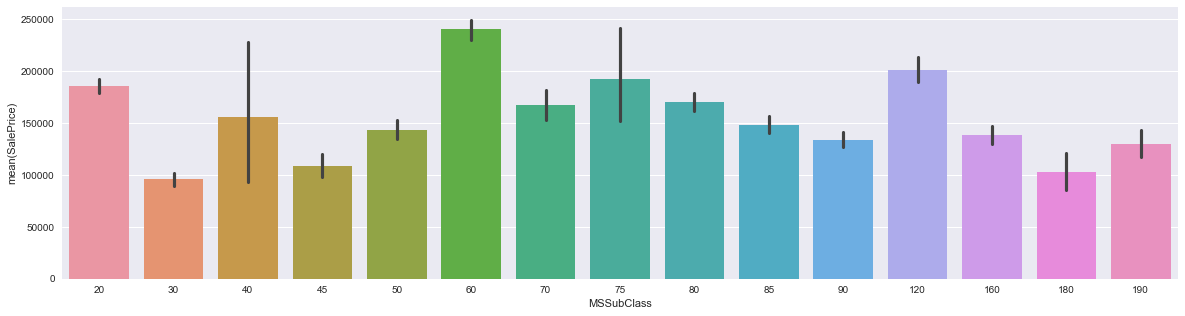

In [14]:
bargraph('MSSubClass')

In [15]:
train_test_count('MSSubClass')

MSSubClass  train_count  test_count
0           20        536.0         543
1           30         69.0          70
2           40          4.0           2
3           45         12.0           6
4           50        144.0         143
5           60        299.0         276
6           70         60.0          68
7           75         16.0           7
8           80         58.0          60
9           85         20.0          28
10          90         52.0          57
11         120         87.0          95
12         160         63.0          65
13         180         10.0           7
14         190         30.0          31
15         150          NaN           1

In [16]:
fs_map('MSSubClass')
test_df.MSSubClass[pd.isnull] = 6 # nan to the most frequent one
test_df.MSSubClass = test_df.MSSubClass.astype('int')
test_df.head()

/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          12       RH         80.0    11622   Pave   NaN      Reg   
1  1462          12       RL         81.0    14267   Pave   NaN      IR1   
2  1463          15       RL         74.0    13830   Pave   NaN      IR1   
3  1464          15       RL         78.0     9978   Pave   NaN      IR1   
4  1465          14       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities      ...       ScreenPorch PoolArea PoolQC  Fence  \
0         Lvl    AllPub      ...               120        0    NaN  MnPrv   
1         Lvl    AllPub      ...                 0        0    NaN    NaN   
2         Lvl    AllPub      ...                 0        0    NaN  MnPrv   
3         Lvl    AllPub      ...                 0        0    NaN    NaN   
4         HLS    AllPub      ...               144        0    NaN    NaN   

  MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  
0         NaN       0      6    2010        WD         Normal  
1        Gar2   12500      6    2010        WD         Normal  
2         NaN       0      3    2010        WD         Normal  
3         NaN       0      6    2010        WD         Normal  
4         NaN       0      1    2010        WD         Normal  

[5 rows x 80 columns]

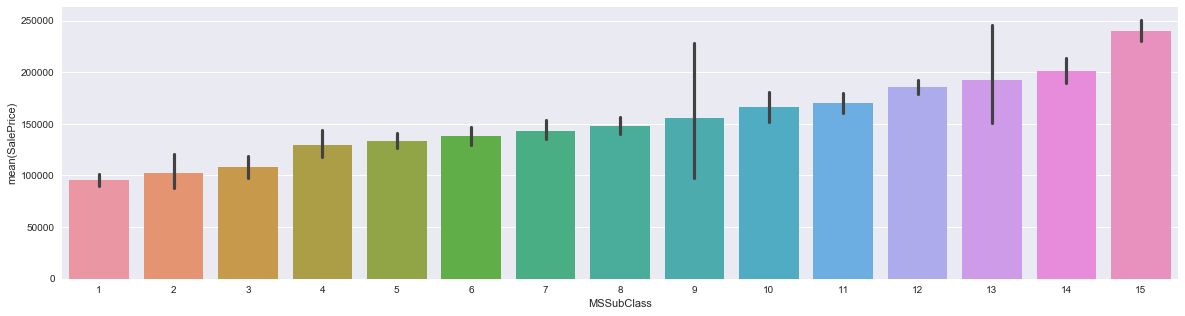

In [17]:
bargraph('MSSubClass')

In [18]:
count_price('MSSubClass')

MSSubClass  SalePrice  count
0            1      95829     69
1            2     102300     10
2            3     108591     12
3            4     129613     30
4            5     133541     52
5            6     138647     63
6            7     143302    144
7            8     147810     20
8            9     156125      4
9           10     166772     60
10          11     169736     58
11          12     185224    536
12          13     192437     16
13          14     200779     87
14          15     239948    299

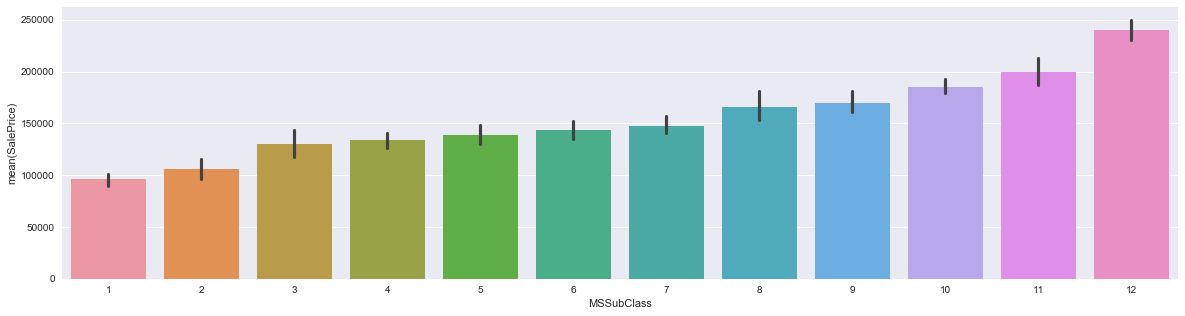

In [19]:
train_df.MSSubClass.replace(3,2,inplace = True)
train_df.MSSubClass.replace(9,10,inplace = True)
train_df.MSSubClass.replace(13,14,inplace = True)

test_df.MSSubClass.replace(3,2,inplace = True)
test_df.MSSubClass.replace(9,10,inplace = True)
test_df.MSSubClass.replace(13,14,inplace = True)

fs_map('MSSubClass')
bargraph('MSSubClass')

In [20]:
next(next_cat)

'MSZoning'

In [21]:
#MSZoning: Identifies the general zoning classification of the sale
train_test_count('MSZoning').sum()

MSZoning       C (all)FVRHRLRM
train_count               1460
test_count                1455
dtype: object

In [22]:
test_df.MSZoning[pd.isnull] = 'RL'

/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


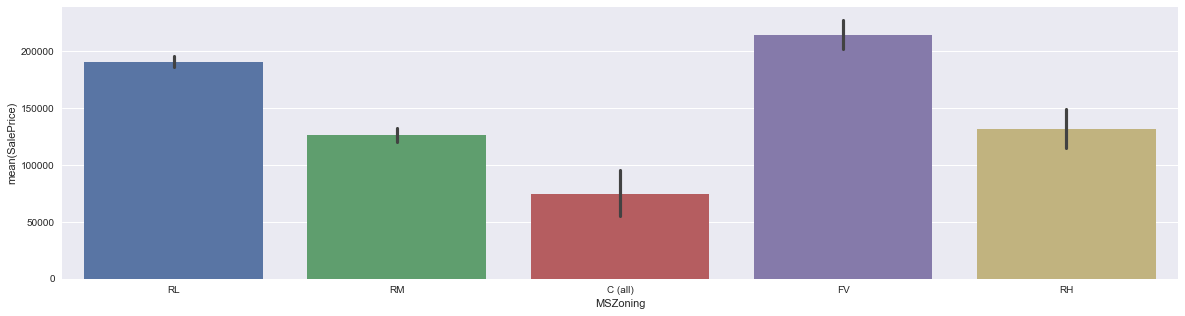

In [23]:
bargraph('MSZoning')

In [24]:
count_price('MSZoning')

MSZoning  SalePrice  count
0  C (all)      74528     10
4       RM     126316    218
2       RH     131558     16
3       RL     191004   1151
1       FV     214014     65

In [25]:
fs_map('MSZoning')

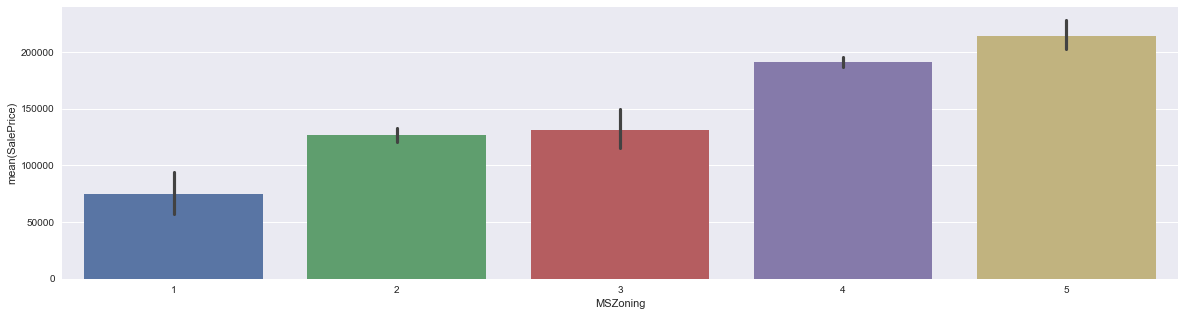

In [26]:
bargraph('MSZoning')

In [27]:
train_test_count('MSZoning')

MSZoning  train_count  test_count
0         1           10          15
1         2          218         242
2         3           16          10
3         4         1151        1118
4         5           65          74

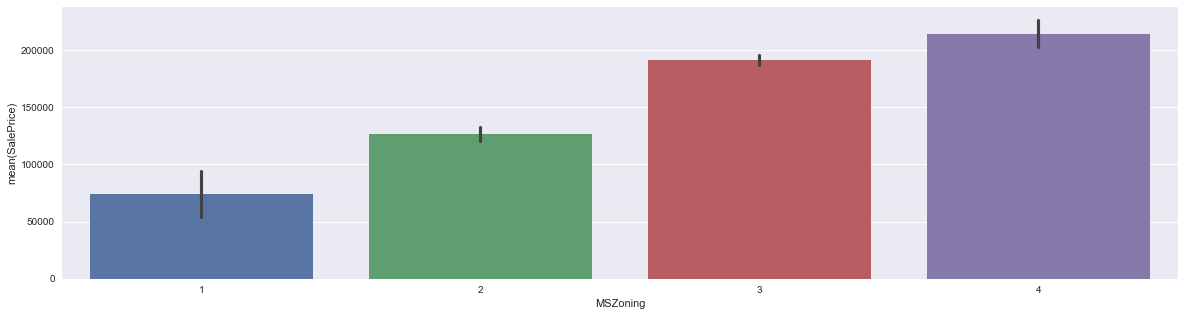

In [28]:
train_df.MSZoning.replace(3,2,inplace = True)
test_df.MSZoning.replace(3,2,inplace = True)
fs_map('MSZoning')
bargraph('MSZoning')

In [29]:
next(next_cat)

'LotFrontage'

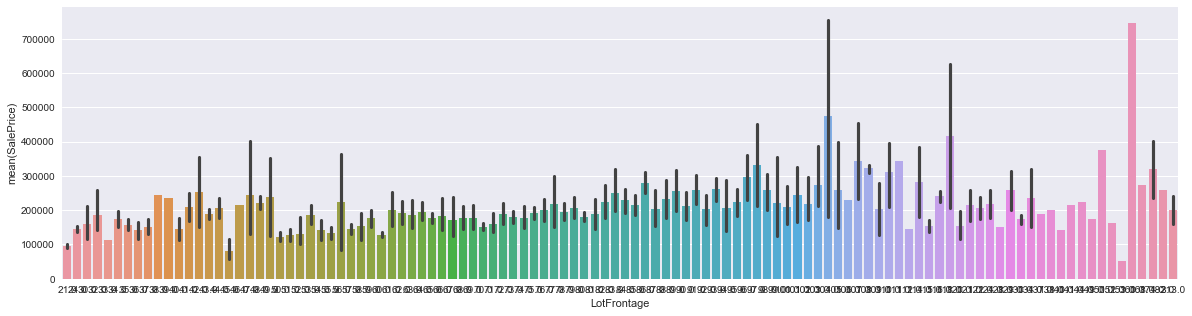

In [30]:
#LotFrontage: Linear feet of street connected to property

bargraph('LotFrontage')

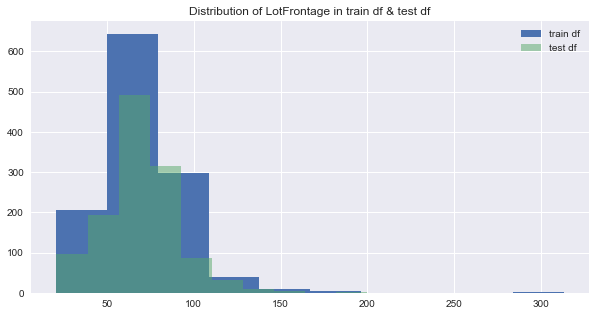

In [31]:
train_test_hist('LotFrontage')

In [32]:
count_price('LotFrontage').sort_values(by ='LotFrontage')

LotFrontage  SalePrice  count
0           21.0      94278     23
1           24.0     145226     19
2           30.0     160480      6
3           32.0     186700      5
4           33.0     113000      1
5           34.0     174950     10
6           35.0     156544      9
7           36.0     142083      6
8           37.0     150280      5
9           38.0     245500      1
10          39.0     236500      1
11          40.0     144776     12
12          41.0     208750      6
13          42.0     253475      4
14          43.0     187597     12
15          44.0     207100      9
16          45.0      80500      3
17          46.0     215000      1
18          47.0     243680      5
19          48.0     222347      6
20          49.0     239274      4
21          50.0     122563     57
22          51.0     128490     15
23          52.0     130807     14
24          53.0     185634     10
25          54.0     143016      6
26          55.0     132104     17
27          56.0     222810      5
28          57.0     144658     12
29          58.0     153267      7
..           ...        ...    ...
80         109.0     204500      2
81         110.0     311883      6
82         111.0     342643      1
83         112.0     145000      1
84         114.0     282450      2
85         115.0     152500      2
86         116.0     240000      2
87         118.0     415000      2
88         120.0     155104      7
89         121.0     214000      2
90         122.0     206500      2
91         124.0     218500      2
92         128.0     149500      1
93         129.0     258000      2
94         130.0     173250      3
95         134.0     234950      2
96         137.0     190000      1
97         138.0     200500      1
98         140.0     141000      1
99         141.0     215000      1
100        144.0     223500      1
101        149.0     174000      1
102        150.0     375000      1
103        152.0     164000      1
104        153.0      52500      1
105        160.0     745000      1
106        168.0     274725      1
107        174.0     319000      2
108        182.0     259000      1
109        313.0     201000      2

[110 rows x 3 columns]

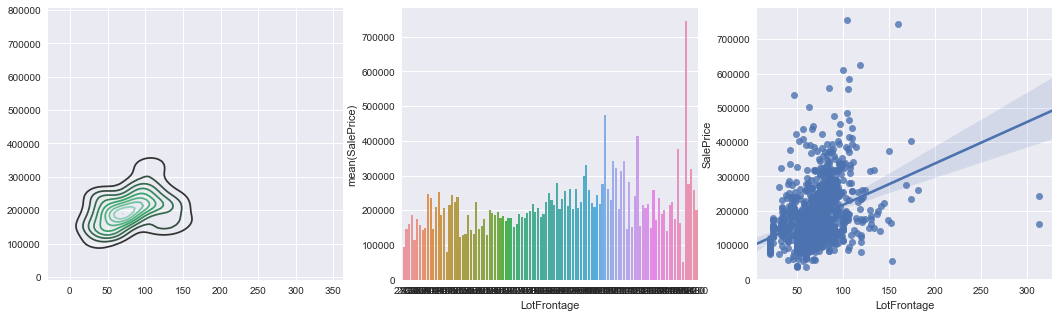

In [33]:
multiple_graphs('LotFrontage')

In [34]:
train_test_count('LotFrontage')

LotFrontage  train_count  test_count
0           21.0         23.0        27.0
1           24.0         19.0        30.0
2           30.0          6.0         5.0
3           32.0          5.0         3.0
4           33.0          1.0         2.0
5           34.0         10.0         6.0
6           35.0          9.0        10.0
7           36.0          6.0         2.0
8           37.0          5.0         2.0
9           38.0          1.0         3.0
10          39.0          1.0         5.0
11          40.0         12.0         4.0
12          41.0          6.0         8.0
13          42.0          4.0         8.0
14          43.0         12.0        11.0
15          44.0          9.0        10.0
16          45.0          3.0         7.0
17          46.0          1.0         2.0
18          47.0          5.0         3.0
19          48.0          6.0        10.0
20          49.0          4.0         1.0
21          50.0         57.0        60.0
22          51.0         15.0        12.0
23          52.0         14.0        14.0
24          53.0         10.0        14.0
25          54.0          6.0         4.0
26          55.0         17.0         7.0
27          56.0          5.0        14.0
28          57.0         12.0        14.0
29          58.0          7.0        10.0
..           ...          ...         ...
98         140.0          1.0         1.0
99         141.0          1.0         NaN
100        144.0          1.0         NaN
101        149.0          1.0         1.0
102        150.0          1.0         1.0
103        152.0          1.0         NaN
104        153.0          1.0         NaN
105        160.0          1.0         2.0
106        168.0          1.0         NaN
107        174.0          2.0         NaN
108        182.0          1.0         NaN
109        313.0          2.0         NaN
110         22.0          NaN         1.0
111         25.0          NaN         1.0
112         26.0          NaN         3.0
113         28.0          NaN         1.0
114         31.0          NaN         1.0
115        113.0          NaN         3.0
116        117.0          NaN         1.0
117        119.0          NaN         1.0
118        123.0          NaN         1.0
119        125.0          NaN         3.0
120        126.0          NaN         1.0
121        131.0          NaN         1.0
122        133.0          NaN         1.0
123        135.0          NaN         1.0
124        136.0          NaN         1.0
125        155.0          NaN         1.0
126        195.0          NaN         1.0
127        200.0          NaN         1.0

[128 rows x 3 columns]

In [35]:
train_df = fill_na(train_df, 'LotFrontage')
test_df = fill_na(test_df, 'LotFrontage')

/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(array([  42.,   37.,   73.,  388.,  570.,  285.,   51.,   12.,    0.,    2.]),
 array([ 3.04452244,  3.31469051,  3.58485859,  3.85502666,  4.12519474,
         4.39536281,  4.66553089,  4.93569896,  5.20586704,  5.47603512,
         5.74620319]),
 <a list of 10 Patch objects>)

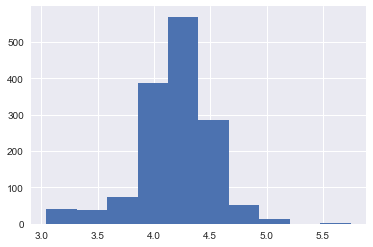

In [36]:
f, ax = plt.subplots(1,1)
ax.hist(np.log(train_df.LotFrontage))

In [37]:
train_df.LotFrontage = np.log(train_df.LotFrontage)
test_df.LotFrontage = np.log(test_df.LotFrontage)

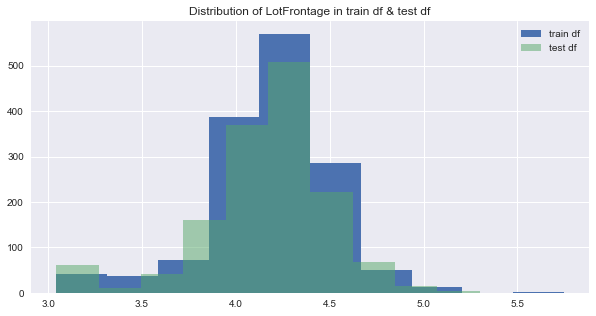

In [38]:
train_test_hist('LotFrontage')

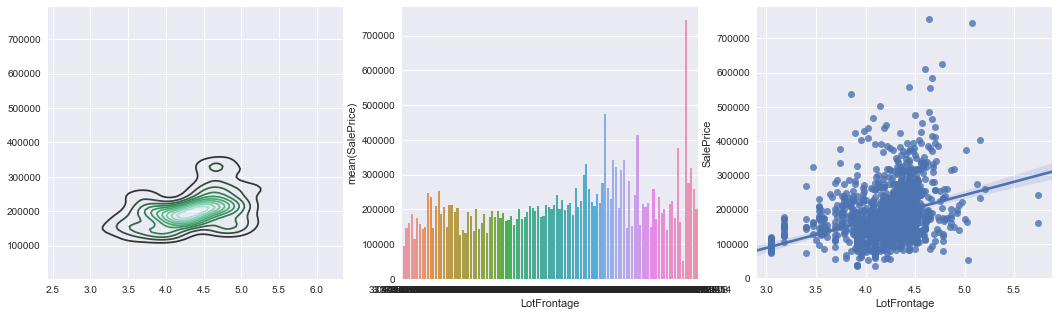

In [39]:
multiple_graphs('LotFrontage')

In [40]:
next(next_cat)

'LotArea'

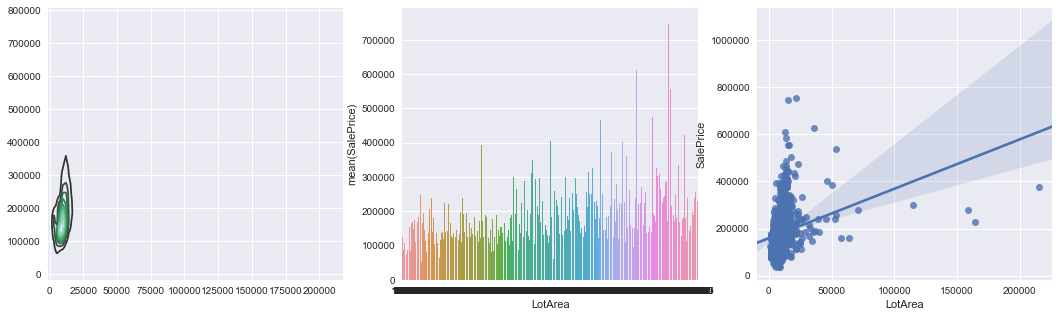

In [41]:
#LotArea: Lot size in square feet
multiple_graphs('LotArea')

In [42]:
train_test_count('LotArea')

LotArea  train_count  test_count
0        1300          1.0         NaN
1        1477          1.0         1.0
2        1491          1.0         NaN
3        1526          1.0         1.0
4        1533          2.0         2.0
5        1596          1.0         1.0
6        1680         10.0         8.0
7        1869          1.0         NaN
8        1890          2.0         4.0
9        1920          1.0         NaN
10       1936          1.0         1.0
11       1950          1.0         NaN
12       1953          1.0         NaN
13       1974          1.0         1.0
14       2001          1.0         NaN
15       2016          1.0         NaN
16       2117          3.0         1.0
17       2160          1.0         2.0
18       2217          1.0         NaN
19       2268          1.0         NaN
20       2280          3.0         6.0
21       2289          1.0         NaN
22       2308          2.0         2.0
23       2368          1.0         NaN
24       2448          1.0         1.0
25       2500          1.0         NaN
26       2522          3.0         1.0
27       2544          1.0         3.0
28       2572          1.0         NaN
29       2592          1.0         NaN
...       ...          ...         ...
1921    21281          NaN         1.0
1922    21299          NaN         1.0
1923    21370          NaN         1.0
1924    21533          NaN         1.0
1925    21579          NaN         1.0
1926    22002          NaN         1.0
1927    22136          NaN         1.0
1928    22692          NaN         1.0
1929    23303          NaN         1.0
1930    23580          NaN         1.0
1931    23730          NaN         1.0
1932    23920          NaN         1.0
1933    24572          NaN         1.0
1934    25485          NaN         1.0
1935    26073          NaN         1.0
1936    26400          NaN         1.0
1937    27697          NaN         1.0
1938    31220          NaN         1.0
1939    31250          NaN         1.0
1940    33120          NaN         1.0
1941    33983          NaN         1.0
1942    39290          NaN         1.0
1943    39384          NaN         1.0
1944    41600          NaN         1.0
1945    43500          NaN         1.0
1946    47007          NaN         1.0
1947    47280          NaN         1.0
1948    50102          NaN         1.0
1949    51974          NaN         1.0
1950    56600          NaN         1.0

[1951 rows x 3 columns]

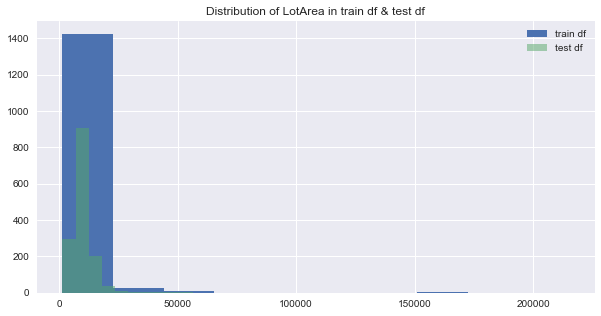

In [43]:
train_test_hist('LotArea')

#Not useng it because it's not very correlating with price
train_df.drop('LotArea', 1, inplace = True)
test_df.drop('LotArea', 1, inplace = True)

In [44]:
next(next_cat)

'Street'

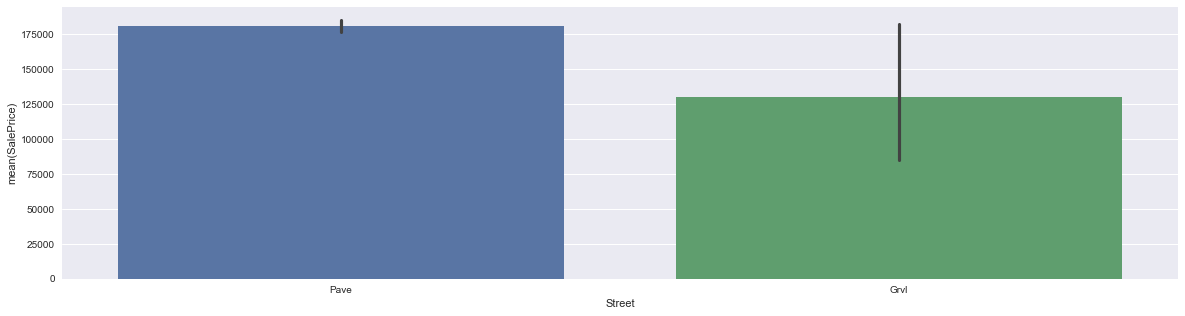

In [45]:
#Street: Type of road access to property
bargraph('Street')

In [46]:
train_test_count('Street')

Street  train_count  test_count
0   Grvl            6           6
1   Pave         1454        1453

In [47]:
#Not useng it because it's too biased
train_df.drop('Street', 1, inplace = True)
test_df.drop('Street', 1, inplace = True)

In [48]:
next(next_cat)

'Alley'

In [49]:
#Alley
#Not useng it, not enough data
train_df.drop('Alley', 1, inplace = True)
test_df.drop('Alley', 1, inplace = True)

In [50]:
next(next_cat)

'LotShape'

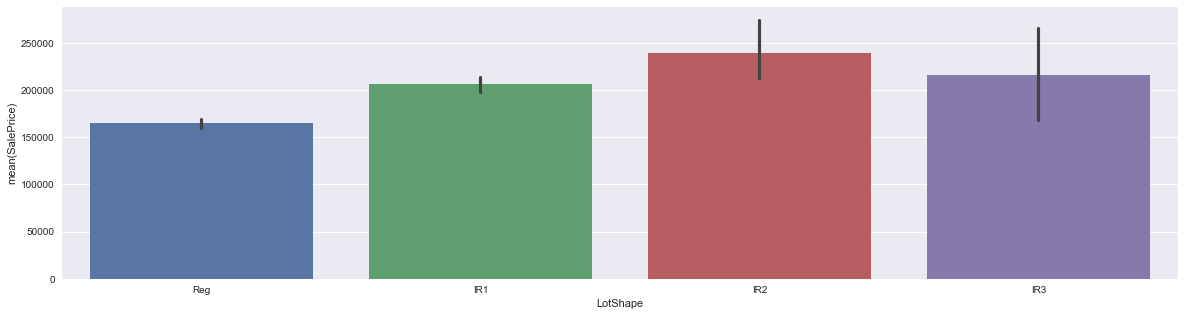

In [51]:
#LotShape: General shape of property

bargraph('LotShape')

In [52]:
train_test_count('LotShape')

LotShape  train_count  test_count
0      IR1          484         484
1      IR2           41          35
2      IR3           10           6
3      Reg          925         934

In [53]:
lotshape_map = {'Reg':1, 'IR1':2, 'IR2':3, 'IR3':3}
train_df.LotShape = train_df.LotShape.map(lotshape_map)
test_df.LotShape = test_df.LotShape.map(lotshape_map)
train_test_count('LotShape')

LotShape  train_count  test_count
0         1          925         934
1         2          484         484
2         3           51          41

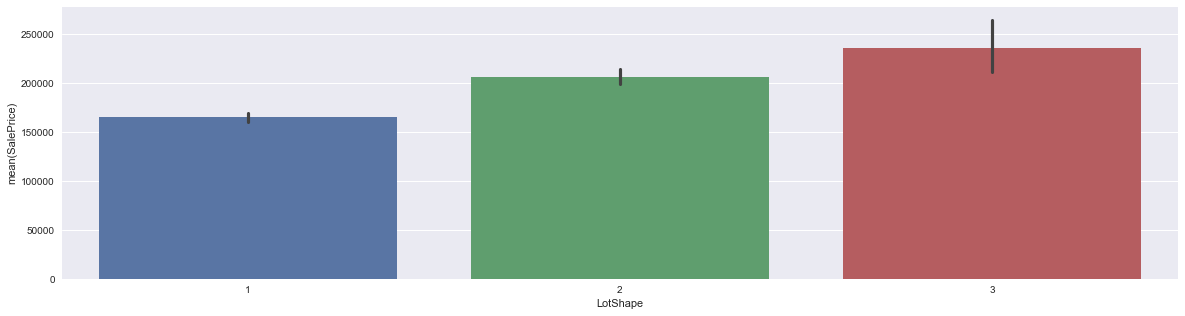

In [54]:
bargraph('LotShape')

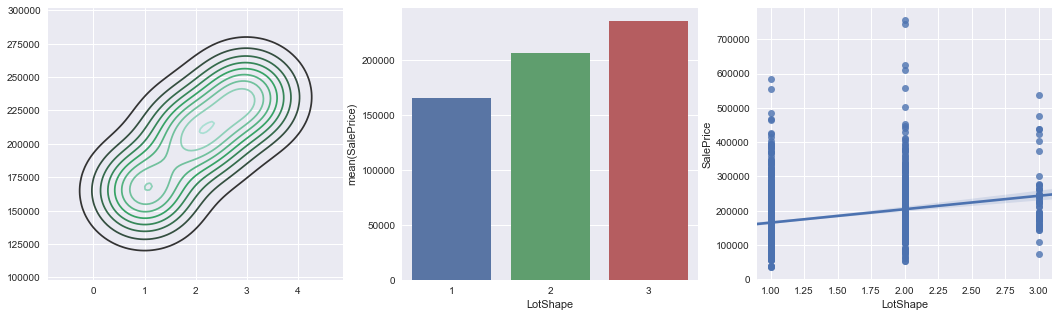

In [55]:
multiple_graphs('LotShape')

In [56]:
next(next_cat)

'LandContour'

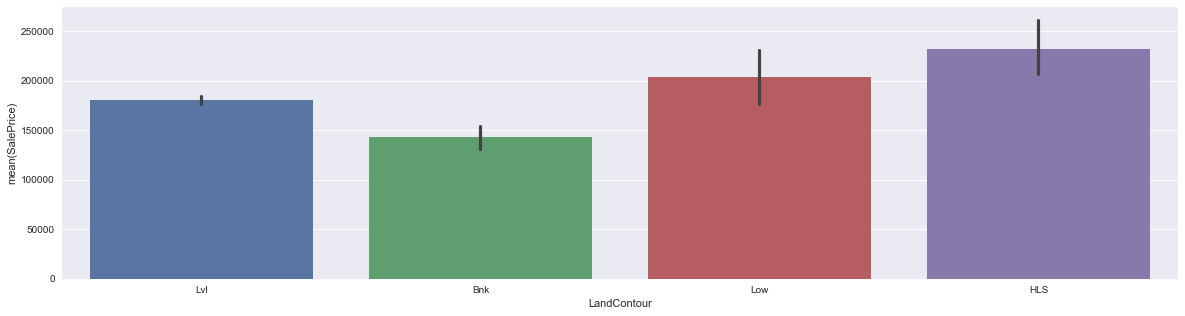

In [57]:
#LandContour: Flatness of the property

bargraph('LandContour')

In [58]:
train_test_count('LandContour')

LandContour  train_count  test_count
0         Bnk           63          54
1         HLS           50          70
2         Low           36          24
3         Lvl         1311        1311

In [59]:
landcontour_map = {'Bnk':1, 'Lvl':2, 'Low':3, 'HLS':4}
train_df.LandContour = train_df.LandContour.map(landcontour_map)
test_df.LandContour = test_df.LandContour.map(landcontour_map)
train_test_count('LandContour')

LandContour  train_count  test_count
0            1           63          54
1            2         1311        1311
2            3           36          24
3            4           50          70

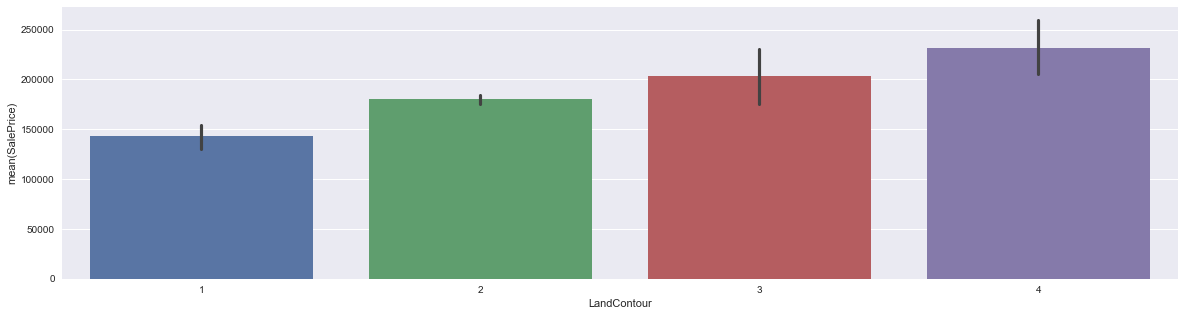

In [60]:
bargraph('LandContour')

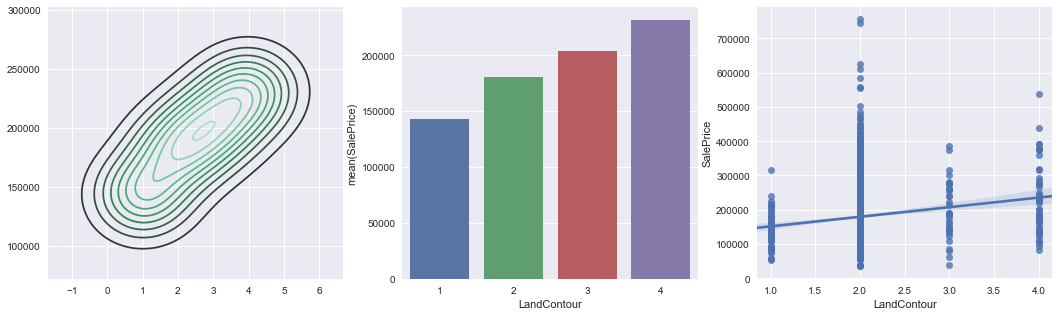

In [61]:
multiple_graphs('LandContour')

In [62]:
next(next_cat)

'Utilities'

In [63]:
#Utilities: Type of utilities available

train_test_count('Utilities')

Utilities  train_count  test_count
0    AllPub         1459      1457.0
1    NoSeWa            1         NaN

In [64]:
# Not enough data
train_df.drop('Utilities', 1, inplace = True)
test_df.drop('Utilities', 1, inplace = True)

In [65]:
next(next_cat)

'LotConfig'

In [66]:
#LotConfig: Lot configuration

train_test_count('LotConfig')

LotConfig  train_count  test_count
0    Corner          263         248
1   CulDSac           94          82
2       FR2           47          38
3       FR3            4          10
4    Inside         1052        1081

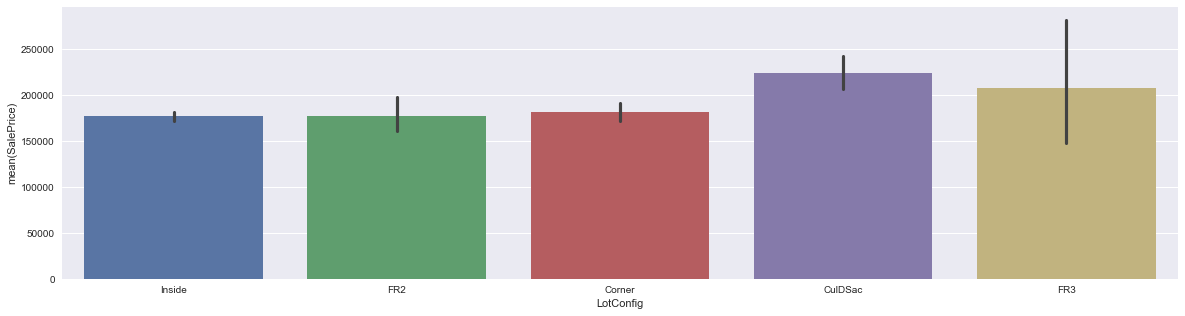

In [67]:
bargraph('LotConfig')
# sns.regplot(x = 'LotConfig', y = 'SalePrice', data = train_df)

In [68]:
the_map = {'Inside':1, 'FR2':1, 'FR3':1, 'Corner':1, 'CulDSac':2}
category_mapping('LotConfig', the_map)

# train_df

LotConfig  train_count  test_count
0          1         1366        1377
1          2           94          82

In [69]:
train_test_count('LotConfig')

LotConfig  train_count  test_count
0          1         1366        1377
1          2           94          82

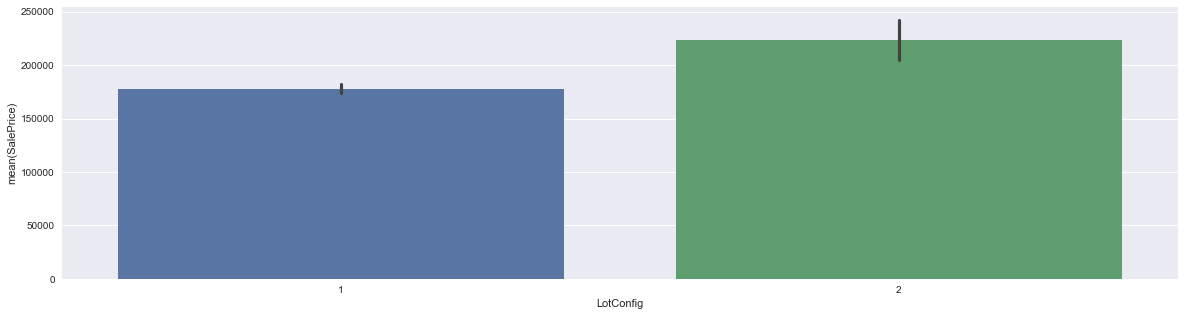

In [70]:
bargraph('LotConfig')

In [71]:
train_df.LotConfig.groupby(train_df['LotConfig']).size()

LotConfig
1    1366
2      94
dtype: int64

In [72]:
next(next_cat)

'LandSlope'

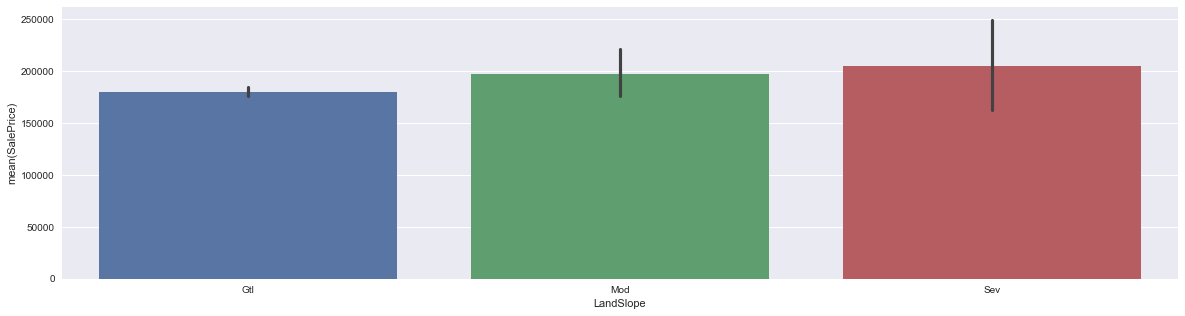

In [73]:
#LandSlope: Slope of property
bargraph('LandSlope')

In [74]:
train_test_count('LandSlope')

LandSlope  train_count  test_count
0       Gtl         1382        1396
1       Mod           65          60
2       Sev           13           3

In [75]:
test_df.LandSlope.isnull().count()

1459

In [76]:
the_map = {'Gtl':1, 'Mod':2, 'Sev':2}
category_mapping('LandSlope', the_map)

LandSlope  train_count  test_count
0          1         1382        1396
1          2           78          63

In [77]:
test_df.LandSlope[(test_df.LandSlope != 1) ].sum()

126

In [78]:
test_df.LandSlope[(test_df.LandSlope != 2) ].sum()

1396

In [79]:
train_df.LandSlope[(train_df.LandSlope != 1) ].sum()

156

In [80]:
train_df.LandSlope[(train_df.LandSlope != 2) ].sum()

1382

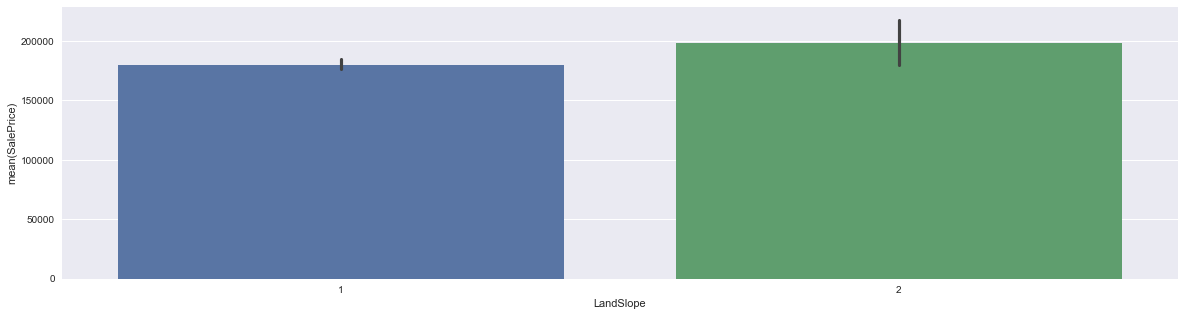

In [81]:
bargraph('LandSlope')

In [82]:
next(next_cat)

'Neighborhood'

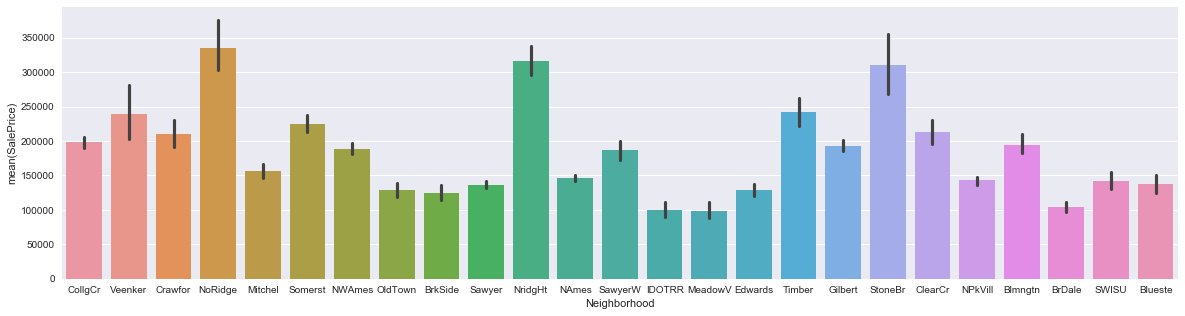

In [83]:
#Neighborhood
f, ax = plt.subplots(1,1, figsize = [20,5])
# ax.set_xlabel = 'Neighborhood'
# ax.set_ylabel = 'SalePrice'
sns.barplot(train_df['Neighborhood'], train_df['SalePrice'], ax = ax)

In [84]:
train_test_count('Neighborhood').sort_values(by = 'train_count')

Neighborhood  train_count  test_count
1       Blueste            2           8
13      NPkVill            9          14
24      Veenker           11          13
2        BrDale           16          14
10      MeadowV           17          20
0       Blmngtn           17          11
22      StoneBr           25          26
18        SWISU           25          23
4       ClearCr           28          16
9        IDOTRR           37          56
23       Timber           38          34
15      NoRidge           41          30
11      Mitchel           49          65
6       Crawfor           51          52
3       BrkSide           58          50
20      SawyerW           59          66
14       NWAmes           73          58
19       Sawyer           74          77
16      NridgHt           77          89
8       Gilbert           79          86
21      Somerst           86          96
7       Edwards          100          94
17      OldTown          113         126
5       CollgCr          150         117
12        NAmes          225         218

In [85]:
count_price('Neighborhood')

Neighborhood  SalePrice  count
10      MeadowV      98576     17
9        IDOTRR     100123     37
2        BrDale     104493     16
3       BrkSide     124834     58
7       Edwards     128219    100
17      OldTown     128225    113
19       Sawyer     136793     74
1       Blueste     137500      2
18        SWISU     142591     25
13      NPkVill     142694      9
12        NAmes     145847    225
11      Mitchel     156270     49
20      SawyerW     186555     59
14       NWAmes     189050     73
8       Gilbert     192854     79
0       Blmngtn     194870     17
5       CollgCr     197965    150
6       Crawfor     210624     51
4       ClearCr     212565     28
21      Somerst     225379     86
24      Veenker     238772     11
23       Timber     242247     38
22      StoneBr     310499     25
16      NridgHt     316270     77
15      NoRidge     335295     41

In [86]:
train_df.Neighborhood.replace('Blueste', 'Sawyer', inplace = True)
test_df.Neighborhood.replace('Blueste', 'Sawyer', inplace = True)
train_df.Neighborhood.replace('SWISU', 'NPkVill', inplace = True)
test_df.Neighborhood.replace('SWISU', 'NPkVill', inplace = True)

In [87]:
list(count_price('Neighborhood').Neighborhood)

['MeadowV',
 'IDOTRR',
 'BrDale',
 'BrkSide',
 'Edwards',
 'OldTown',
 'Sawyer',
 'NPkVill',
 'NAmes',
 'Mitchel',
 'SawyerW',
 'NWAmes',
 'Gilbert',
 'Blmngtn',
 'CollgCr',
 'Crawfor',
 'ClearCr',
 'Somerst',
 'Veenker',
 'Timber',
 'StoneBr',
 'NridgHt',
 'NoRidge']

In [88]:
fs_map('Neighborhood')

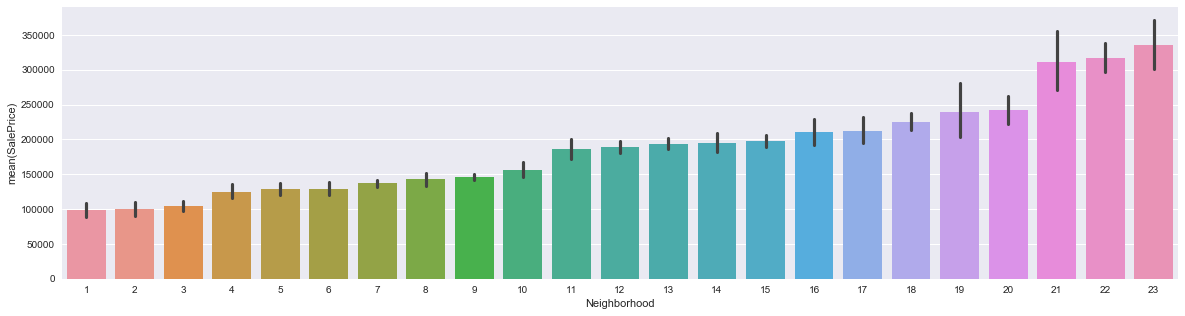

In [89]:

f, ax = plt.subplots(1,1, figsize = [20,5])
sns.barplot(train_df['Neighborhood'], train_df['SalePrice'], ax = ax)

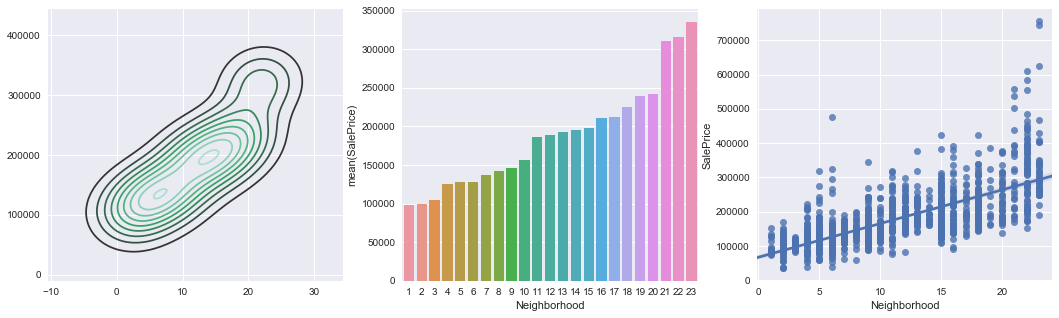

In [90]:
multiple_graphs('Neighborhood')

In [91]:
test_df.head()

Id  MSSubClass  MSZoning  LotFrontage  LotShape  LandContour  LotConfig  \
0  1461          10         2     4.382027         1            2          1   
1  1462          10         3     4.394449         2            2          1   
2  1463          12         3     4.304065         2            2          1   
3  1464          12         3     4.356709         2            2          1   
4  1465          11         3     3.761200         2            4          1   

   LandSlope  Neighborhood Condition1      ...      ScreenPorch PoolArea  \
0          1             9      Feedr      ...              120        0   
1          1             9       Norm      ...                0        0   
2          1            13       Norm      ...                0        0   
3          1            13       Norm      ...                0        0   
4          1            21       Norm      ...              144        0   

  PoolQC  Fence  MiscFeature  MiscVal  MoSold YrSold SaleType SaleCondition  
0    NaN  MnPrv          NaN        0       6   2010       WD        Normal  
1    NaN    NaN         Gar2    12500       6   2010       WD        Normal  
2    NaN  MnPrv          NaN        0       3   2010       WD        Normal  
3    NaN    NaN          NaN        0       6   2010       WD        Normal  
4    NaN    NaN          NaN        0       1   2010       WD        Normal  

[5 rows x 76 columns]

In [92]:
next(next_cat)

'Condition1'

In [93]:
#Condition1
train_test_count('Condition1')

Condition1  train_count  test_count
0     Artery           48          44
1      Feedr           81          83
2       Norm         1260        1251
3       PosA            8          12
4       PosN           19          20
5       RRAe           11          17
6       RRAn           26          24
7       RRNe            2           4
8       RRNn            5           4

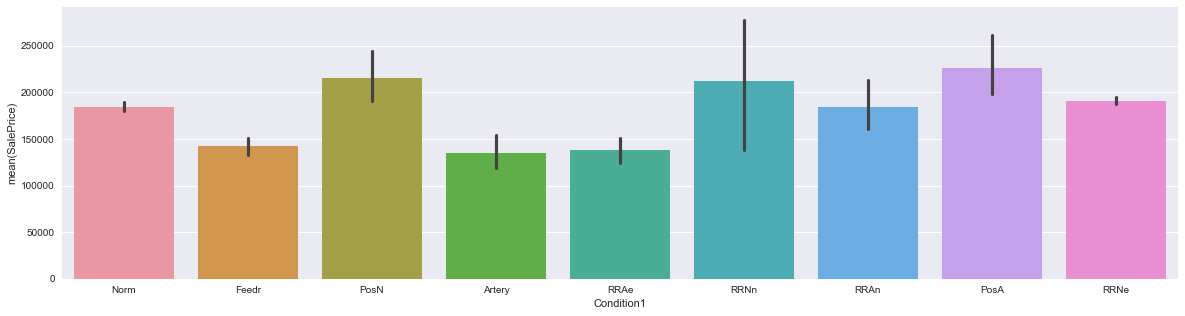

In [94]:
bargraph('Condition1')

In [95]:
train_df.Condition1.replace(['Feedr', 'Artery', 'RRAe', 'RRAn', 'RRNe', 'RRNn'], 'Neg', inplace = True)
test_df.Condition1.replace(['Feedr', 'Artery', 'RRAe', 'RRAn', 'RRNe', 'RRNn'], 'Neg', inplace = True)
train_df.Condition1.replace(['Feedr', 'Artery', 'RRAe', 'RRAn', 'RRNe', 'RRNn'], 'Neg', inplace = True)
test_df.Condition1.replace(['Feedr', 'Artery', 'RRAe', 'RRAn', 'RRNe', 'RRNn'], 'Neg', inplace = True)
train_df.Condition1.replace(['PosA', 'PosN'], 'Pos', inplace = True)
test_df.Condition1.replace(['PosA', 'PosN'], 'Pos', inplace = True)


the_map = {'Neg':1, 'Norm':2, 'Pos':3}
category_mapping('Condition1', the_map)


Condition1  train_count  test_count
0           1          173         176
1           2         1260        1251
2           3           27          32

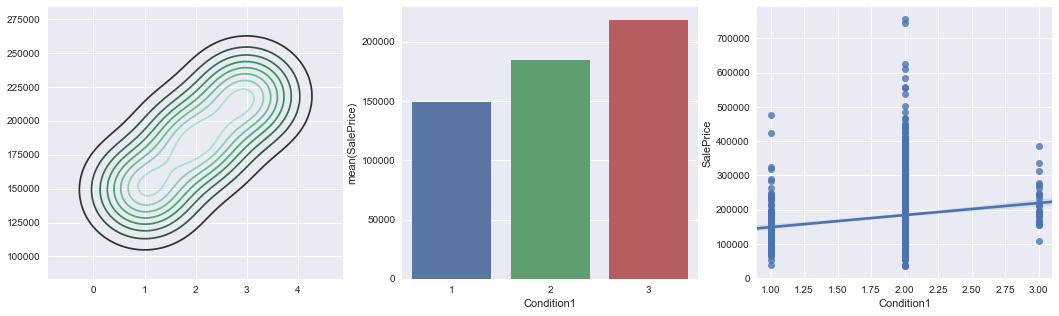

In [96]:
multiple_graphs('Condition1')

In [97]:
next(next_cat)

'Condition2'

In [98]:
#Condition2
train_test_count('Condition2')

Condition2  train_count  test_count
0     Artery            2         3.0
1      Feedr            6         7.0
2       Norm         1445      1444.0
3       PosA            1         3.0
4       PosN            2         2.0
5       RRAe            1         NaN
6       RRAn            1         NaN
7       RRNn            2         NaN

In [99]:
train_df.Condition2.replace(['Feedr', 'Artery', 'RRAe', 'RRAn', 'RRNe', 'RRNn'], 'Neg', inplace = True)
test_df.Condition2.replace(['Feedr', 'Artery', 'RRAe', 'RRAn', 'RRNe', 'RRNn'], 'Neg', inplace = True)
train_df.Condition2.replace(['Feedr', 'Artery', 'RRAe', 'RRAn', 'RRNe', 'RRNn'], 'Neg', inplace = True)
test_df.Condition2.replace(['Feedr', 'Artery', 'RRAe', 'RRAn', 'RRNe', 'RRNn'], 'Neg', inplace = True)
train_df.Condition2.replace(['PosA', 'PosN'], 'Pos', inplace = True)
test_df.Condition2.replace(['PosA', 'PosN'], 'Pos', inplace = True)


the_map = {'Neg':1, 'Norm':2, 'Pos':3}
category_mapping('Condition2', the_map)


Condition2  train_count  test_count
0           1           12          10
1           2         1445        1444
2           3            3           5

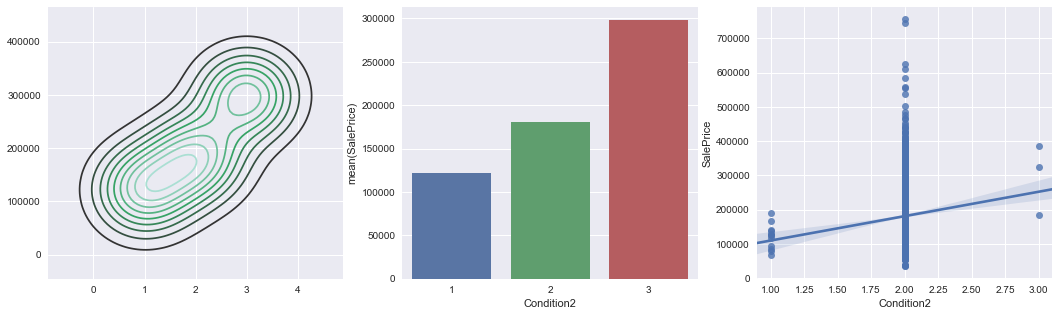

In [100]:
multiple_graphs('Condition2')

In [101]:
train_df.Condition1[(train_df.Condition1 == 1) & (train_df.Condition2 == 1)] = 0
test_df.Condition1[(test_df.Condition1 == 1) & (test_df.Condition2 == 1)] = 0

train_df.Condition1[(train_df.Condition1 == 1) & (train_df.Condition2 == 3)] = 2
test_df.Condition1[(test_df.Condition1 == 1) & (test_df.Condition2 == 3)] = 2

train_df.Condition1[(train_df.Condition1 == 3) & (train_df.Condition2 == 3)] = 4
test_df.Condition1[(test_df.Condition1 == 3) & (test_df.Condition2 == 3)] = 4

train_df.drop('Condition2', 1, inplace = True)
test_df.drop('Condition2', 1, inplace = True)

train_df = train_df.rename(columns = {'Condition1':'Conditions'})
test_df = test_df.rename(columns = {'Condition1':'Conditions'})

/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/HyesooYoun/

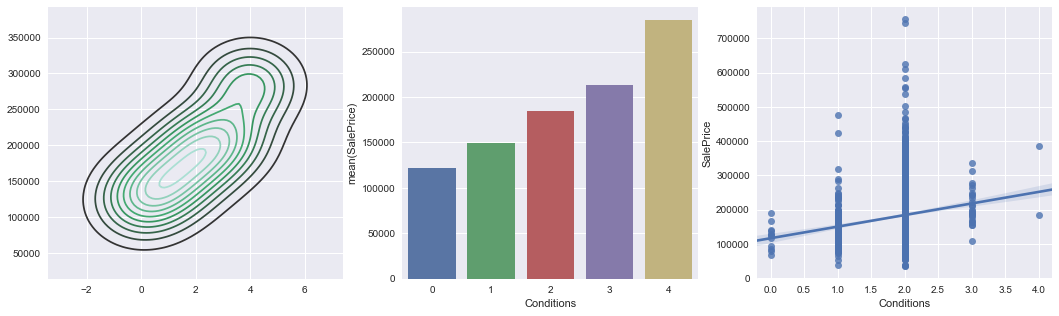

In [102]:
multiple_graphs('Conditions')

In [103]:
test_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Conditions',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPor

In [104]:
next(next_cat)

'BldgType'

In [105]:
#BldgType

train_test_count('BldgType')

BldgType  train_count  test_count
0     1Fam         1220        1205
1   2fmCon           31          31
2   Duplex           52          57
3    Twnhs           43          53
4   TwnhsE          114         113

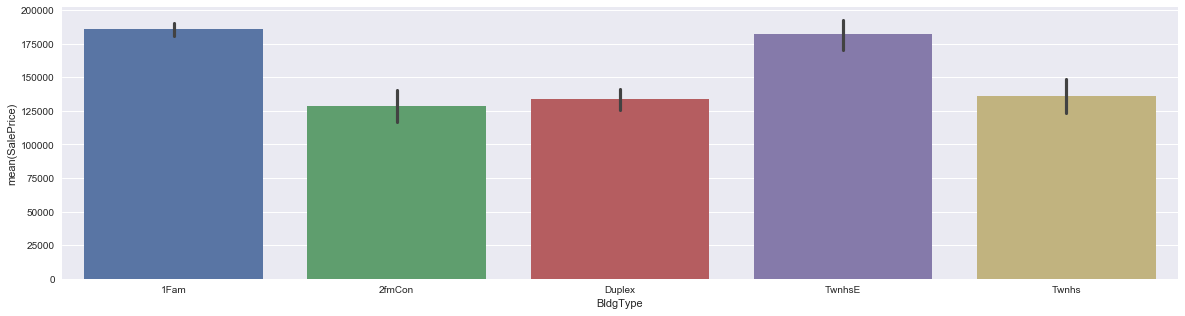

In [106]:
bargraph('BldgType')

In [107]:
count_price('BldgType')

BldgType  SalePrice  count
1   2fmCon     128432     31
2   Duplex     133541     52
3    Twnhs     135911     43
4   TwnhsE     181959    114
0     1Fam     185763   1220

In [108]:
train_df.replace(['2fmCon', 'Duplex'], 'Twnhs', inplace = True)
test_df.replace(['2fmCon', 'Duplex'], 'Twnhs', inplace = True)
train_df.replace('TwnhsE', '1Fam', inplace = True)
test_df.replace('TwnhsE', '1Fam', inplace = True)
fs_map('BldgType')


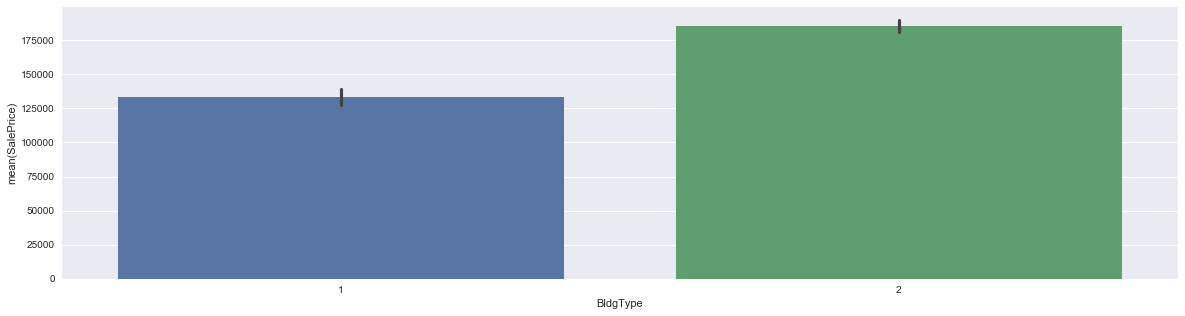

In [109]:
bargraph('BldgType')

In [110]:
train_test_count('BldgType')

BldgType  train_count  test_count
0         1          126         141
1         2         1334        1318

In [111]:
next(next_cat)

'HouseStyle'

In [112]:
#HouseStyle

train_test_count('HouseStyle')

HouseStyle  train_count  test_count
0     1.5Fin          154       160.0
1     1.5Unf           14         5.0
2     1Story          726       745.0
3     2.5Fin            8         NaN
4     2.5Unf           11        13.0
5     2Story          445       427.0
6     SFoyer           37        46.0
7       SLvl           65        63.0

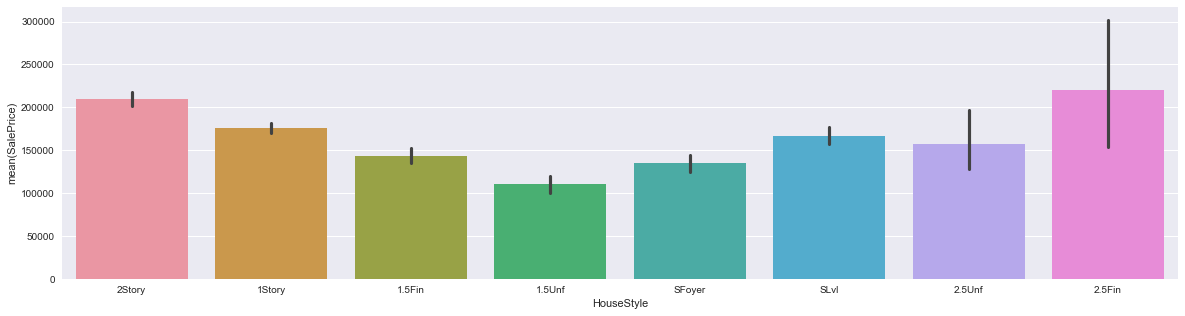

In [113]:
bargraph('HouseStyle')

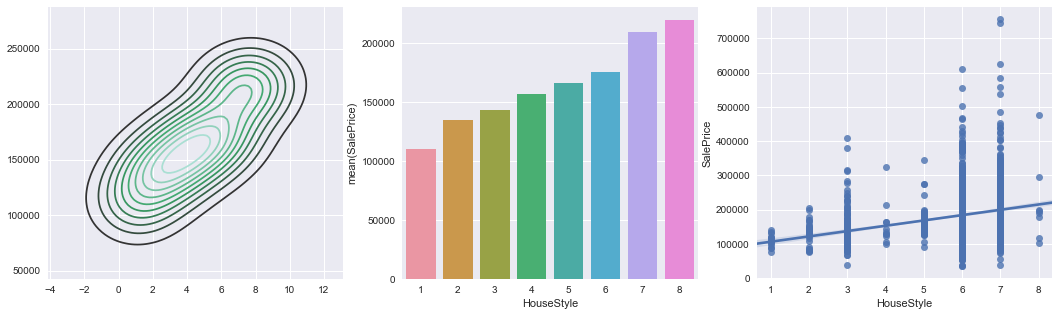

In [114]:
fs_map('HouseStyle')
multiple_graphs('HouseStyle')

In [115]:
next(next_cat)

'OverallQual'

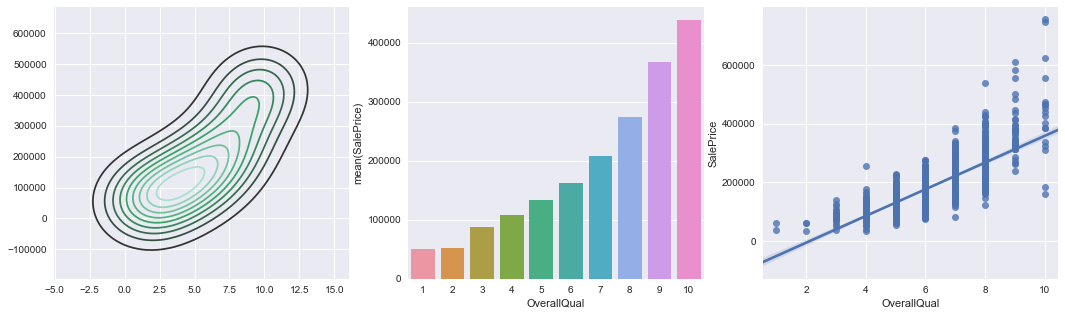

In [116]:
#OverallQual

multiple_graphs('OverallQual')

In [117]:
next(next_cat)

'OverallCond'

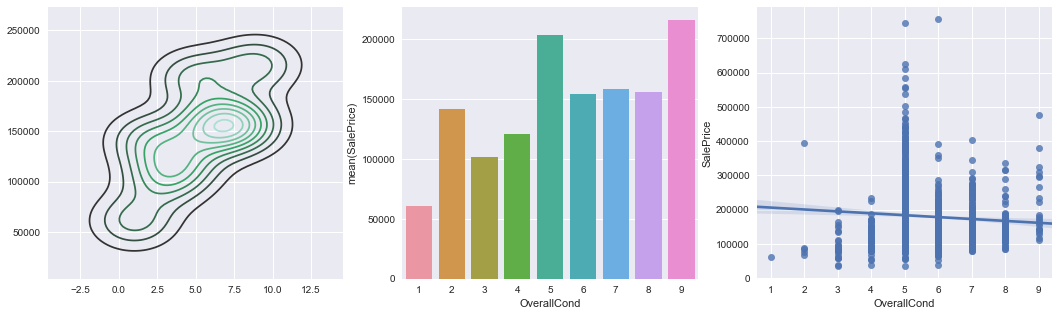

In [118]:
#OverallCond

multiple_graphs('OverallCond')

In [119]:
train_test_count('OverallCond')

OverallCond  train_count  test_count
0            1            1           6
1            2            5           5
2            3           25          25
3            4           57          44
4            5          821         824
5            6          252         279
6            7          205         185
7            8           72          72
8            9           22          19

/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_i

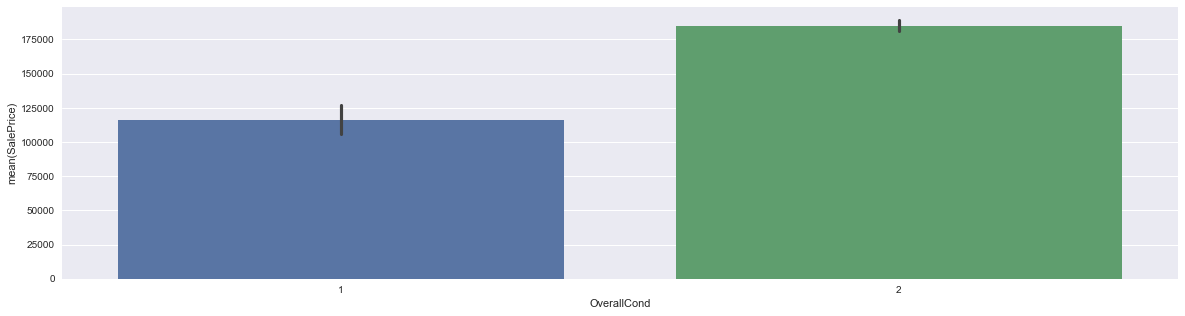

In [120]:
train_df.OverallCond[train_df.OverallCond <= 4] = 1
test_df.OverallCond[train_df.OverallCond <= 4] = 1
train_df.OverallCond[train_df.OverallCond > 4] = 2
test_df.OverallCond[train_df.OverallCond > 4] = 2
bargraph('OverallCond')

In [121]:
next(next_cat)

'YearBuilt'

In [122]:
#YearBuilt

train_df.YearBuilt.min()

1872

In [123]:
test_df.YearBuilt.min()

1879

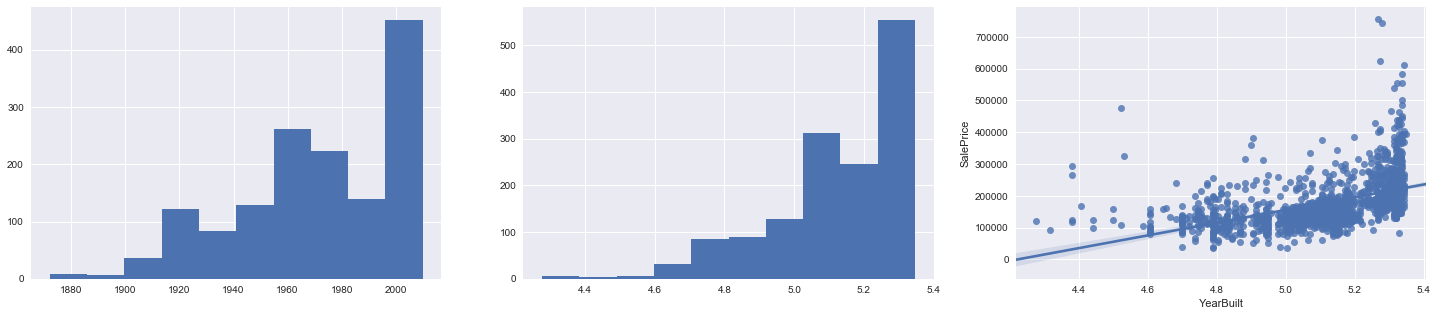

In [124]:
f,(ax1, ax2, ax3) = plt.subplots(1,3, figsize = (25, 5))
ax1.hist(train_df.YearBuilt)
ax2.hist(np.log((train_df.YearBuilt-1800)))
sns.regplot(np.log((train_df.YearBuilt-1800)), train_df.SalePrice, ax = ax3)

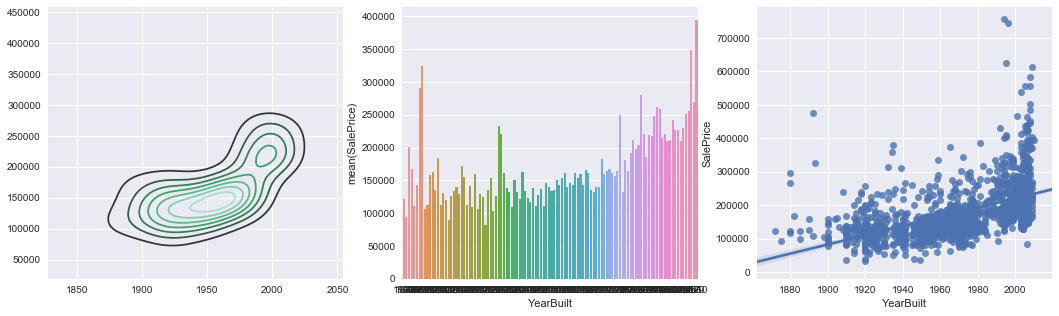

In [125]:
multiple_graphs('YearBuilt')

In [126]:
train_df.YearBuilt[train_df.YearBuilt < 1950] = 1
test_df.YearBuilt[test_df.YearBuilt < 1950] = 1

train_df.YearBuilt[(train_df.YearBuilt < 1985) & (train_df.YearBuilt >= 1950)] = 2
test_df.YearBuilt[(test_df.YearBuilt < 1985) & (test_df.YearBuilt >= 1950)] = 2

train_df.YearBuilt[(train_df.YearBuilt < 2000) & (train_df.YearBuilt >= 1985)] = 3
test_df.YearBuilt[(test_df.YearBuilt < 2000) & (test_df.YearBuilt >= 1985)] = 3

train_df.YearBuilt[train_df.YearBuilt >= 2000] = 4
test_df.YearBuilt[test_df.YearBuilt >= 2000] = 4


/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/HyesooYoun/

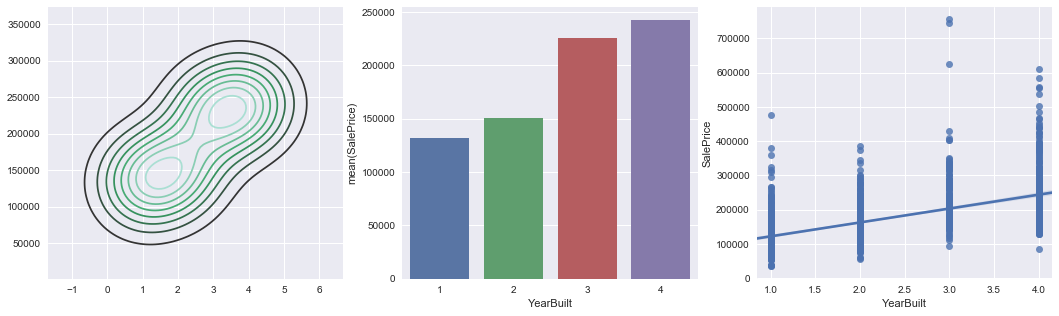

In [127]:
multiple_graphs('YearBuilt')

In [128]:
next(next_cat)

'YearRemodAdd'

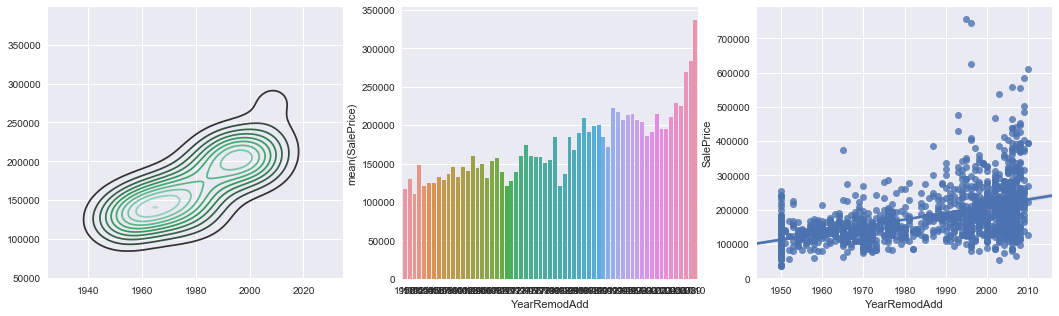

In [129]:
# YearRemodAdd

multiple_graphs('YearRemodAdd')

/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D

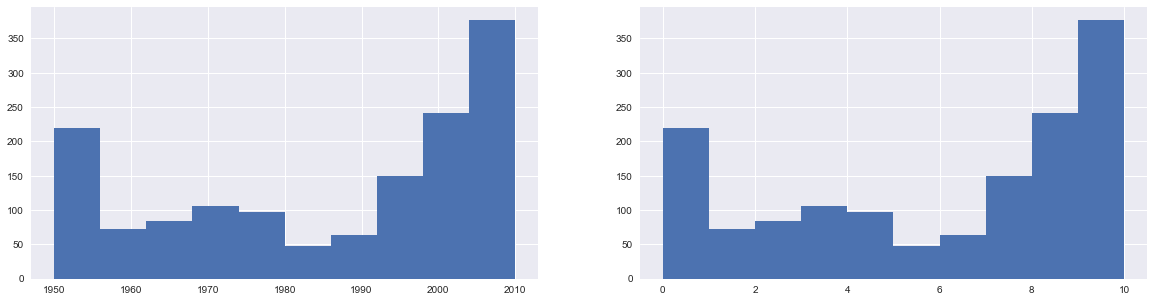

In [130]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(20,5))
ax1.hist(train_df.YearRemodAdd)

scaler1 = preprocessing.MinMaxScaler((0,10))
train_df.YearRemodAdd = scaler1.fit_transform(train_df.YearRemodAdd)
ax2.hist(train_df.YearRemodAdd)
test_df.YearRemodAdd = scaler1.fit_transform(test_df.YearRemodAdd)

In [131]:
# train_df, test_df = binning('YearRemodAdd', 6)
# bargraph('YearRemodAdd')

In [132]:
# train_df.YearRemodAdd[train_df.YearRemodAdd == 3 ] = 2
# train_df.YearRemodAdd[train_df.YearRemodAdd == 4 ] = 3
# train_df.YearRemodAdd[train_df.YearRemodAdd == 5 ] = 4
# train_df.YearRemodAdd[train_df.YearRemodAdd == 6 ] = 5

# test_df.YearRemodAdd[test_df.YearRemodAdd == 3 ] = 2
# test_df.YearRemodAdd[test_df.YearRemodAdd == 4 ] = 3
# test_df.YearRemodAdd[test_df.YearRemodAdd == 5 ] = 4
# test_df.YearRemodAdd[test_df.YearRemodAdd == 6 ] = 5

# bargraph('YearRemodAdd')

In [133]:
train_df.drop('YearBuilt',1,inplace=True)
test_df.drop('YearBuilt',1,inplace=True)

In [134]:
next(next_cat)

'RoofStyle'

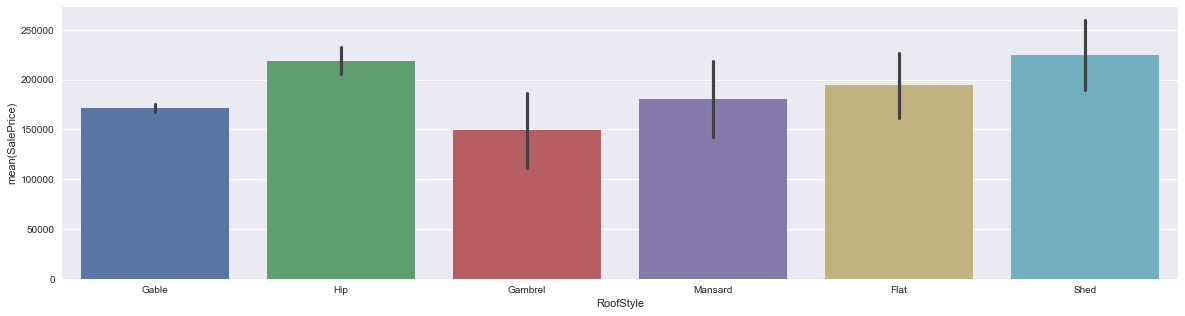

In [135]:
#RoofStyle

bargraph('RoofStyle')

In [136]:
train_test_count('RoofStyle')

RoofStyle  train_count  test_count
0      Flat           13           7
1     Gable         1141        1169
2   Gambrel           11          11
3       Hip          286         265
4   Mansard            7           4
5      Shed            2           3

In [137]:
count_price('RoofStyle')

RoofStyle  SalePrice  count
2   Gambrel     148909     11
1     Gable     171483   1141
4   Mansard     180568      7
0      Flat     194690     13
3       Hip     218876    286
5      Shed     225000      2

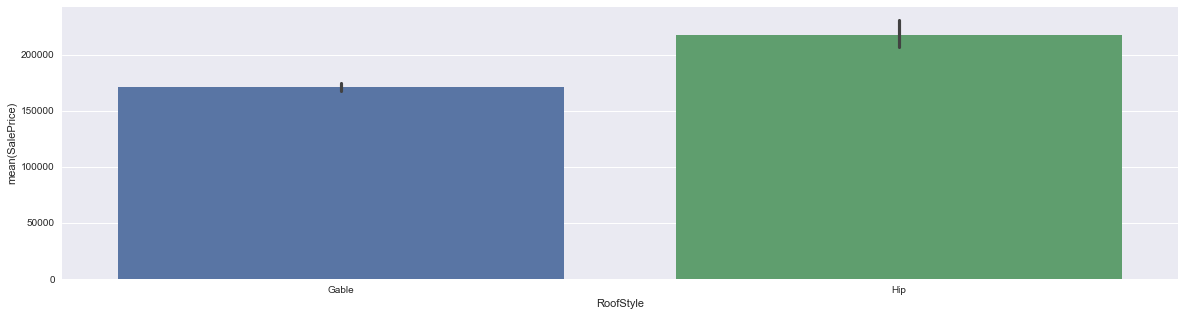

In [138]:
train_df.RoofStyle = train_df.RoofStyle.replace(['Gambrel', 'Mansard'], 'Gable')
test_df.RoofStyle = test_df.RoofStyle.replace(['Gambrel', 'Mansard'], 'Gable')

train_df.RoofStyle = train_df.RoofStyle.replace(['Flat', 'Shed'], 'Hip')
test_df.RoofStyle = test_df.RoofStyle.replace(['Flat', 'Shed'], 'Hip')

bargraph('RoofStyle')

In [139]:
count_price('RoofStyle')

RoofStyle  SalePrice  count
0     Gable     171324   1159
1       Hip     217873    301

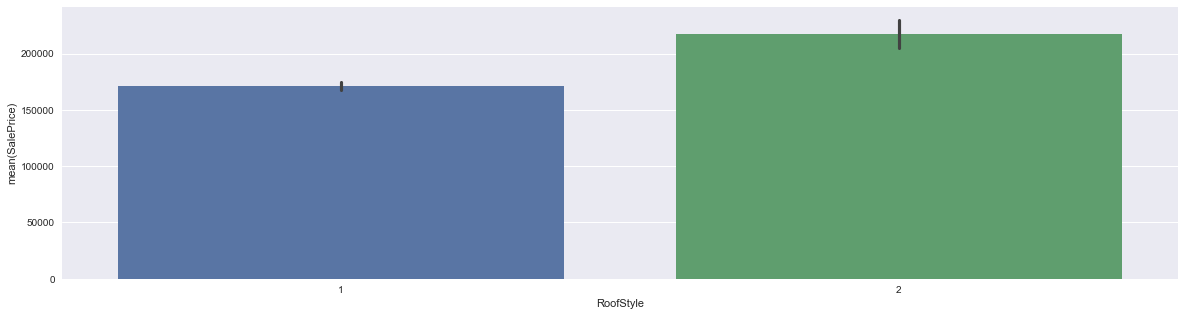

In [140]:
fs_map('RoofStyle')
bargraph('RoofStyle')

In [141]:
next(next_cat)

'RoofMatl'

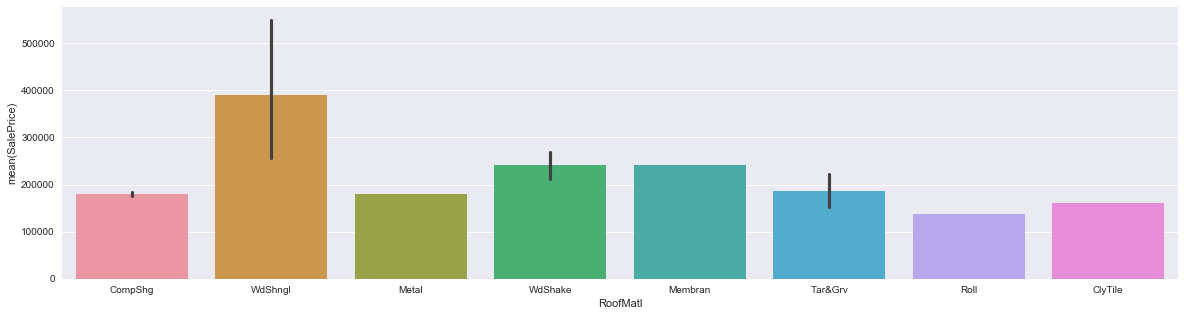

In [142]:
# RoofMatl

bargraph('RoofMatl')

In [143]:
train_df.RoofMatl.groupby(train_df.RoofMatl).size()

RoofMatl
ClyTile       1
CompShg    1434
Membran       1
Metal         1
Roll          1
Tar&Grv      11
WdShake       5
WdShngl       6
dtype: int64

In [144]:
# Dropping, not enough data

train_df.drop('RoofMatl', 1, inplace = True)
test_df.drop('RoofMatl', 1, inplace = True)

In [145]:
next(next_cat)
next(next_cat)

'Exterior2nd'

In [146]:
#Exterior2nd
train_test_count('Exterior2nd').sort_values(by = 'train_count')

Exterior2nd  train_count  test_count
4       CBlock            1         2.0
9        Other            1         NaN
1      AsphShn            3         1.0
11       Stone            5         1.0
2      Brk Cmn            7        15.0
7      ImStucc           10         5.0
0      AsbShng           20        18.0
3      BrkFace           25        22.0
12      Stucco           26        21.0
15     Wd Shng           38        43.0
5      CmentBd           60        66.0
10     Plywood          142       128.0
14     Wd Sdng          197       194.0
6      HdBoard          207       199.0
8      MetalSd          214       233.0
13     VinylSd          504       510.0

In [147]:
test_df.Exterior1st[pd.isnull] = 'VinylSd'
test_df.Exterior2nd[pd.isnull] = 'VinylSd'
Exterior = train_df[['Exterior1st', 'Exterior2nd', 'SalePrice']].sort_values(by = ['Exterior1st', 'Exterior2nd'])
Ex2 = Exterior.groupby(['Exterior1st', 'Exterior2nd']).mean().sort_values(by = 'SalePrice')

# Ex2['Exterior'] = zip(Ex2.Exterior1st, Ex2.Exterior2nd)
# sns.barplot(lst_Exterior, Ex2.SalePrice)
# sns.barplot(['Exterior1st', 'Exterior2nd'], 'SalePrice', Ex2)

/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [148]:
bins = pd.cut(Ex2.SalePrice,10)
bins = [float(first_val(x)) for x in set(bins)]+[1000000]
bins.sort()
Ex2['Exterior'] = Ex2.index
Ex2.Exterior = Ex2.index
Ex2['Exterior1st'], Ex2['Exterior2nd'] = 1,1
for a, b in Ex2.Exterior:
    Ex2['Exterior1st'][Ex2.Exterior == (a,b)], Ex2['Exterior2nd'][Ex2.Exterior == (a,b)] = a,b
Ex2

/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


SalePrice            Exterior Exterior1st Exterior2nd
Exterior1st Exterior2nd                                                       
BrkComm     Brk Cmn          71000  (BrkComm, Brk Cmn)     BrkComm     Brk Cmn
Wd Sdng     AsbShng          82000  (Wd Sdng, AsbShng)     Wd Sdng     AsbShng
MetalSd     Stucco           85000   (MetalSd, Stucco)     MetalSd      Stucco
AsbShng     Stucco           87000   (AsbShng, Stucco)     AsbShng      Stucco
WdShing     Wd Sdng          87000  (WdShing, Wd Sdng)     WdShing     Wd Sdng
            Stucco           90350   (WdShing, Stucco)     WdShing      Stucco
Stucco      Stone            93500     (Stucco, Stone)      Stucco       Stone
AsphShn     AsphShn         100000  (AsphShn, AsphShn)     AsphShn     AsphShn
AsbShng     Plywood         104500  (AsbShng, Plywood)     AsbShng     Plywood
CBlock      CBlock          105000    (CBlock, CBlock)      CBlock      CBlock
HdBoard     ImStucc         106250  (HdBoard, ImStucc)     HdBoard     ImStucc
AsbShng     AsbShng         108924  (AsbShng, AsbShng)     AsbShng     AsbShng
HdBoard     MetalSd         119500  (HdBoard, MetalSd)     HdBoard     MetalSd
Wd Sdng     VinylSd         120250  (Wd Sdng, VinylSd)     Wd Sdng     VinylSd
VinylSd     AsbShng         122500  (VinylSd, AsbShng)     VinylSd     AsbShng
HdBoard     Wd Sdng         125500  (HdBoard, Wd Sdng)     HdBoard     Wd Sdng
VinylSd     HdBoard         128000  (VinylSd, HdBoard)     VinylSd     HdBoard
BrkFace     Wd Shng         129900  (BrkFace, Wd Shng)     BrkFace     Wd Shng
HdBoard     Wd Shng         133000  (HdBoard, Wd Shng)     HdBoard     Wd Shng
BrkFace     Stone           133500    (BrkFace, Stone)     BrkFace       Stone
MetalSd     Wd Sdng         137000  (MetalSd, Wd Sdng)     MetalSd     Wd Sdng
VinylSd     Wd Sdng         138000  (VinylSd, Wd Sdng)     VinylSd     Wd Sdng
MetalSd     Wd Shng         139000  (MetalSd, Wd Shng)     MetalSd     Wd Shng
            AsphShn         139000  (MetalSd, AsphShn)     MetalSd     AsphShn
Plywood     HdBoard         139250  (Plywood, HdBoard)     Plywood     HdBoard
Wd Sdng     BrkFace         140000  (Wd Sdng, BrkFace)     Wd Sdng     BrkFace
            MetalSd         140000  (Wd Sdng, MetalSd)     Wd Sdng     MetalSd
WdShing     Plywood         140386  (WdShing, Plywood)     WdShing     Plywood
Wd Sdng     Wd Shng         141055  (Wd Sdng, Wd Shng)     Wd Sdng     Wd Shng
WdShing     HdBoard         142950  (WdShing, HdBoard)     WdShing     HdBoard
...                            ...                 ...         ...         ...
Wd Sdng     Plywood         150500  (Wd Sdng, Plywood)     Wd Sdng     Plywood
Stucco      Stucco          158137    (Stucco, Stucco)      Stucco      Stucco
VinylSd     Stucco          159434   (VinylSd, Stucco)     VinylSd      Stucco
            Plywood         161400  (VinylSd, Plywood)     VinylSd     Plywood
WdShing     Wd Shng         161873  (WdShing, Wd Shng)     WdShing     Wd Shng
HdBoard     HdBoard         166357  (HdBoard, HdBoard)     HdBoard     HdBoard
CemntBd     Wd Sdng         168000  (CemntBd, Wd Sdng)     CemntBd     Wd Sdng
Plywood     ImStucc         170066  (Plywood, ImStucc)     Plywood     ImStucc
HdBoard     AsphShn         175000  (HdBoard, AsphShn)     HdBoard     AsphShn
Plywood     Plywood         176610  (Plywood, Plywood)     Plywood     Plywood
BrkFace     Wd Sdng         187316  (BrkFace, Wd Sdng)     BrkFace     Wd Sdng
            Plywood         191500  (BrkFace, Plywood)     BrkFace     Plywood
            BrkFace         198143  (BrkFace, BrkFace)     BrkFace     BrkFace
Wd Sdng     Stone           200624    (Wd Sdng, Stone)     Wd Sdng       Stone
VinylSd     VinylSd         214807  (VinylSd, VinylSd)     VinylSd     VinylSd
BrkFace     AsbShng         225000  (BrkFace, AsbShng)     BrkFace     AsbShng
CemntBd     CmentBd         227578  (CemntBd, CmentBd)     CemntBd     CmentBd
Wd Sdng     HdBoard         228750  (Wd Sdng, HdBoard)     Wd Sdng     HdBo

In [149]:
lst_Exterior = list(zip(Exterior.Exterior1st, Exterior.Exterior2nd))
Exterior_Count = pd.DataFrame(Counter(lst_Exterior), index = ['Count']).transpose()
Exterior_Count['Exterior'] = Exterior_Count.index
Exterior_Count['Exterior1st'], Exterior_Count['Exterior2nd'] = 1,1
for a, b in Exterior_Count.Exterior:
    Exterior_Count['Exterior1st'][Exterior_Count.Exterior == (a,b)], Exterior_Count['Exterior2nd'][Exterior_Count.Exterior == (a,b)] = a,b

Exterior_Count.drop('Exterior',1, inplace = True)
Exterior_Count.sort_values(by='Count')

/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Count Exterior1st Exterior2nd
Wd Sdng MetalSd      1     Wd Sdng     MetalSd
VinylSd HdBoard      1     VinylSd     HdBoard
HdBoard MetalSd      1     HdBoard     MetalSd
VinylSd AsbShng      1     VinylSd     AsbShng
HdBoard Wd Sdng      1     HdBoard     Wd Sdng
        Wd Shng      1     HdBoard     Wd Shng
ImStucc ImStucc      1     ImStucc     ImStucc
VinylSd ImStucc      1     VinylSd     ImStucc
MetalSd AsphShn      1     MetalSd     AsphShn
Stucco  Stone        1      Stucco       Stone
MetalSd Stucco       1     MetalSd      Stucco
Stucco  CmentBd      1      Stucco     CmentBd
MetalSd Wd Shng      1     MetalSd     Wd Shng
Stone   Stone        1       Stone       Stone
        HdBoard      1       Stone     HdBoard
Wd Sdng Stone        1     Wd Sdng       Stone
WdShing Wd Sdng      1     WdShing     Wd Sdng
HdBoard AsphShn      1     HdBoard     AsphShn
CemntBd Wd Sdng      1     CemntBd     Wd Sdng
AsbShng Stucco       1     AsbShng      Stucco
AsphShn AsphShn      1     AsphShn     AsphShn
Wd Sdng BrkFace      1     Wd Sdng     BrkFace
BrkFace AsbShng      1     BrkFace     AsbShng
WdShing Stucco       1     WdShing      Stucco
CemntBd Wd Shng      1     CemntBd     Wd Shng
Wd Sdng AsbShng      1     Wd Sdng     AsbShng
VinylSd Stucco       1     VinylSd      Stucco
BrkFace Stucco       1     BrkFace      Stucco
        Wd Shng      1     BrkFace     Wd Shng
CBlock  CBlock       1      CBlock      CBlock
...                ...         ...         ...
AsbShng Plywood      2     AsbShng     Plywood
MetalSd Wd Sdng      2     MetalSd     Wd Sdng
BrkComm Brk Cmn      2     BrkComm     Brk Cmn
BrkFace Stone        2     BrkFace       Stone
Plywood Wd Sdng      2     Plywood     Wd Sdng
HdBoard ImStucc      2     HdBoard     ImStucc
WdShing HdBoard      2     WdShing     HdBoard
BrkFace HdBoard      3     BrkFace     HdBoard
Plywood ImStucc      3     Plywood     ImStucc
Stucco  Wd Shng      3      Stucco     Wd Shng
MetalSd HdBoard      3     MetalSd     HdBoard
Wd Sdng ImStucc      3     Wd Sdng     ImStucc
VinylSd Wd Shng      5     VinylSd     Wd Shng
Plywood Brk Cmn      5     Plywood     Brk Cmn
WdShing Plywood      5     WdShing     Plywood
BrkFace Plywood      6     BrkFace     Plywood
Wd Sdng Plywood      8     Wd Sdng     Plywood
        Wd Shng      9     Wd Sdng     Wd Shng
BrkFace Wd Sdng     12     BrkFace     Wd Sdng
AsbShng AsbShng     17     AsbShng     AsbShng
WdShing Wd Shng     17     WdShing     Wd Shng
Stucco  Stucco      20      Stucco      Stucco
HdBoard Plywood     23     HdBoard     Plywood
BrkFace BrkFace     24     BrkFace     BrkFace
CemntBd CmentBd     59     CemntBd     CmentBd
Plywood Plywood     96     Plywood     Plywood
Wd Sdng Wd Sdng    177     Wd Sdng     Wd Sdng
HdBoard HdBoard    193     HdBoard     HdBoard
MetalSd MetalSd    212     MetalSd     MetalSd
VinylSd VinylSd    502     VinylSd     VinylSd

[67 rows x 3 columns]

In [150]:
Exterior_total = pd.merge(Ex2, Exterior_Count)
Exterior_total = Exterior_total[['Exterior', 'Exterior1st', 'Exterior2nd', 'Count', 'SalePrice']]
Exterior_total

Exterior Exterior1st Exterior2nd  Count  SalePrice
0   (BrkComm, Brk Cmn)     BrkComm     Brk Cmn      2      71000
1   (Wd Sdng, AsbShng)     Wd Sdng     AsbShng      1      82000
2    (MetalSd, Stucco)     MetalSd      Stucco      1      85000
3    (AsbShng, Stucco)     AsbShng      Stucco      1      87000
4   (WdShing, Wd Sdng)     WdShing     Wd Sdng      1      87000
5    (WdShing, Stucco)     WdShing      Stucco      1      90350
6      (Stucco, Stone)      Stucco       Stone      1      93500
7   (AsphShn, AsphShn)     AsphShn     AsphShn      1     100000
8   (AsbShng, Plywood)     AsbShng     Plywood      2     104500
9     (CBlock, CBlock)      CBlock      CBlock      1     105000
10  (HdBoard, ImStucc)     HdBoard     ImStucc      2     106250
11  (AsbShng, AsbShng)     AsbShng     AsbShng     17     108924
12  (HdBoard, MetalSd)     HdBoard     MetalSd      1     119500
13  (Wd Sdng, VinylSd)     Wd Sdng     VinylSd      2     120250
14  (VinylSd, AsbShng)     VinylSd     AsbShng      1     122500
15  (HdBoard, Wd Sdng)     HdBoard     Wd Sdng      1     125500
16  (VinylSd, HdBoard)     VinylSd     HdBoard      1     128000
17  (BrkFace, Wd Shng)     BrkFace     Wd Shng      1     129900
18  (HdBoard, Wd Shng)     HdBoard     Wd Shng      1     133000
19    (BrkFace, Stone)     BrkFace       Stone      2     133500
20  (MetalSd, Wd Sdng)     MetalSd     Wd Sdng      2     137000
21  (VinylSd, Wd Sdng)     VinylSd     Wd Sdng      1     138000
22  (MetalSd, Wd Shng)     MetalSd     Wd Shng      1     139000
23  (MetalSd, AsphShn)     MetalSd     AsphShn      1     139000
24  (Plywood, HdBoard)     Plywood     HdBoard      2     139250
25  (Wd Sdng, BrkFace)     Wd Sdng     BrkFace      1     140000
26  (Wd Sdng, MetalSd)     Wd Sdng     MetalSd      1     140000
27  (WdShing, Plywood)     WdShing     Plywood      5     140386
28  (Wd Sdng, Wd Shng)     Wd Sdng     Wd Shng      9     141055
29  (WdShing, HdBoard)     WdShing     HdBoard      2     142950
..                 ...         ...         ...    ...        ...
37  (Wd Sdng, Plywood)     Wd Sdng     Plywood      8     150500
38    (Stucco, Stucco)      Stucco      Stucco     20     158137
39   (VinylSd, Stucco)     VinylSd      Stucco      1     159434
40  (VinylSd, Plywood)     VinylSd     Plywood      2     161400
41  (WdShing, Wd Shng)     WdShing     Wd Shng     17     161873
42  (HdBoard, HdBoard)     HdBoard     HdBoard    193     166357
43  (CemntBd, Wd Sdng)     CemntBd     Wd Sdng      1     168000
44  (Plywood, ImStucc)     Plywood     ImStucc      3     170066
45  (HdBoard, AsphShn)     HdBoard     AsphShn      1     175000
46  (Plywood, Plywood)     Plywood     Plywood     96     176610
47  (BrkFace, Wd Sdng)     BrkFace     Wd Sdng     12     187316
48  (BrkFace, Plywood)     BrkFace     Plywood      6     191500
49  (BrkFace, BrkFace)     BrkFace     BrkFace     24     198143
50    (Wd Sdng, Stone)     Wd Sdng       Stone      1     200624
51  (VinylSd, VinylSd)     VinylSd     VinylSd    502     214807
52  (BrkFace, AsbShng)     BrkFace     AsbShng      1     225000
53  (CemntBd, CmentBd)     CemntBd     CmentBd     59     227578
54  (Wd Sdng, HdBoard)     Wd Sdng     HdBoard      2     228750
55   (BrkFace, Stucco)     BrkFace      Stucco      1     230000
56      (Stone, Stone)       Stone       Stone      1     230000
57   (Wd Sdng, Stucco)     Wd Sdng      Stucco      1     239000
58  (BrkFace, HdBoard)     BrkFace     HdBoard      3     241500
59  (Plywood, Wd Sdng)     Plywood     Wd Sdng      2     256750
60  (ImStucc, ImStucc)     ImStucc     ImStucc      1     262000
61    (Stone, HdBoard)       Stone     HdBoard      1     287000
62    (VinylSd, Other)     VinylSd       Other      1     319000
63  (VinylSd, ImStucc)     VinylSd     ImStucc      1     320000
64   (Stucco, CmentBd)      Stucco     CmentBd      1     378500
65  (Wd Sdng, ImStucc)     Wd Sdng     ImStucc      3     405333
66  (CemntBd, Wd Shng)     CemntBd     Wd Shng   

(array([  3.,   8.,   7.,  22.,   9.,   9.,   4.,   2.,   2.,   1.]),
 array([ 11.17043516,  11.37295302,  11.57547089,  11.77798876,
         11.98050663,  12.1830245 ,  12.38554237,  12.58806023,
         12.7905781 ,  12.99309597,  13.19561384]),
 <a list of 10 Patch objects>)

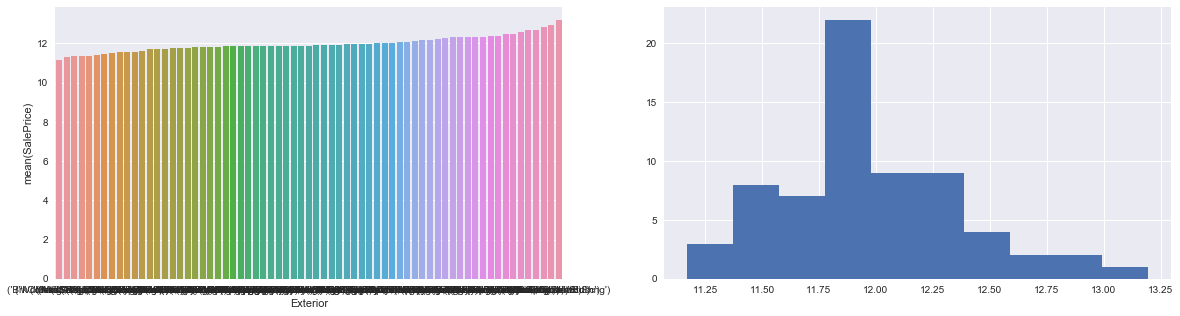

In [151]:
f, (ax1, ax2) = plt.subplots(1,2,figsize = (20,5))
sns.barplot(Exterior_total.Exterior, np.log(Exterior_total.SalePrice), ax = ax1)
ax2.hist(np.log(Exterior_total.SalePrice))

In [152]:
Exterior_total['Exterior'] = np.log(Exterior_total.SalePrice)
Exterior_total_subset = Exterior_total[['Exterior1st', 'Exterior2nd', 'Exterior']]

In [153]:
train_df = train_df.merge(Exterior_total_subset, on = ['Exterior1st', 'Exterior2nd'], how = 'outer')
test_df = test_df.merge(Exterior_total_subset, on = ['Exterior1st', 'Exterior2nd'], how = 'outer')
test_df = test_df[:1459]

In [154]:
test_df['Exterior'][test_df.Exterior.isnull()] = test_df.Exterior.mean()

In [155]:
test_df['Exterior'].isnull().sum()

# test_df['SalePrice_level'] = Exterior_subtotal.SalePrice_level[(Exterior_subtotal.Exterior1st == test_df.Exterior1st) & (Exterior_subtotal.Exterior2nd == test_df.Exterior2nd)]
# train_df.drop(['Exterior1st','Exterior2nd'], 1, inplace = True)
# test_df.drop(['Exterior1st','Exterior2nd'], 1, inplace = True)

0

In [156]:
next(next_cat)

'MasVnrType'

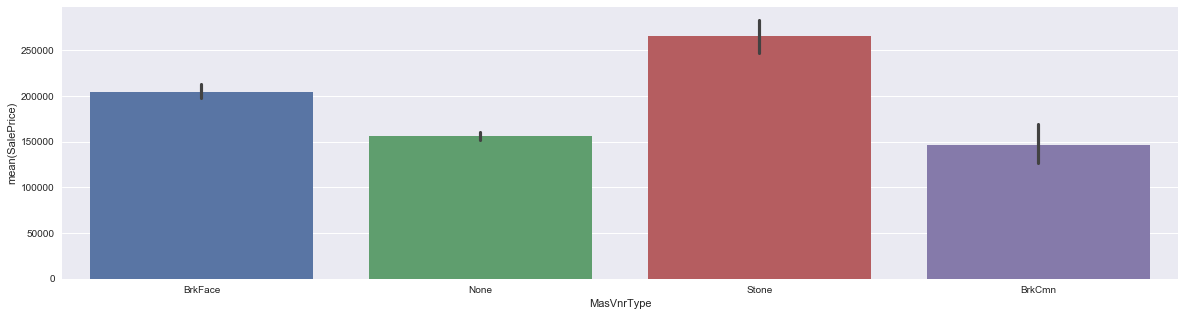

In [157]:
#MasVnrType

bargraph('MasVnrType')

In [158]:
train_test_count('MasVnrType')
train_df.MasVnrType[pd.isnull] = 'None'
test_df.MasVnrType[pd.isnull] = 'None'

/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [159]:
count_price('MasVnrType')

MasVnrType  SalePrice  count
0     BrkCmn     146318     15
2       None     156958    872
1    BrkFace     204691    445
3      Stone     265583    128

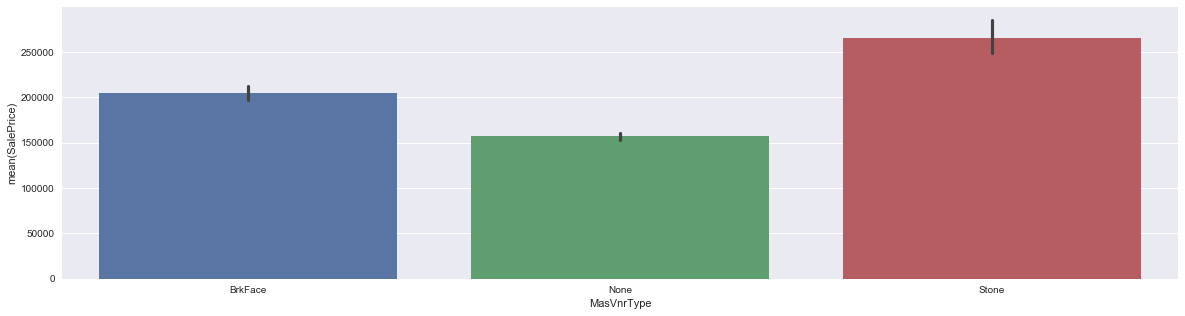

In [160]:
train_df.MasVnrType = train_df.MasVnrType.replace('BrkCmn', 'None')
test_df.MasVnrType = test_df.MasVnrType.replace('BrkCmn', 'None')
bargraph('MasVnrType')

In [161]:
fs_map('MasVnrType')

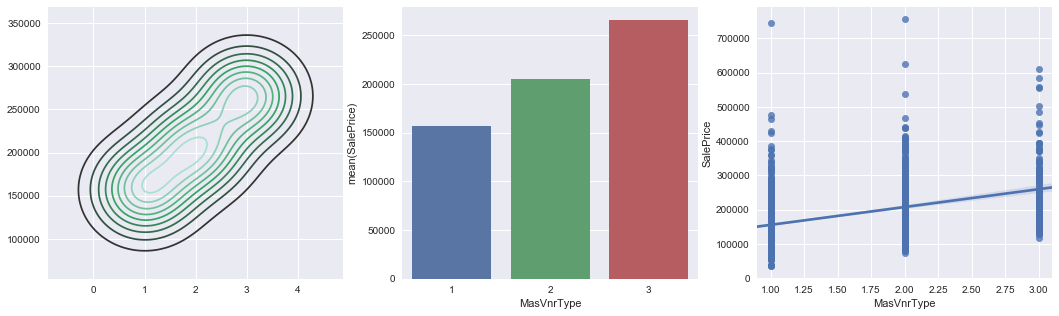

In [162]:
multiple_graphs('MasVnrType')

In [163]:
next(next_cat)

'MasVnrArea'

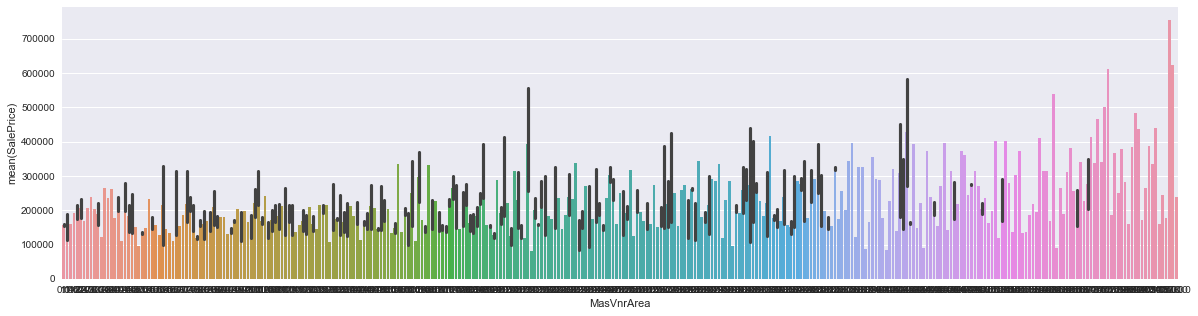

In [164]:
#MasVnrArea

bargraph('MasVnrArea')

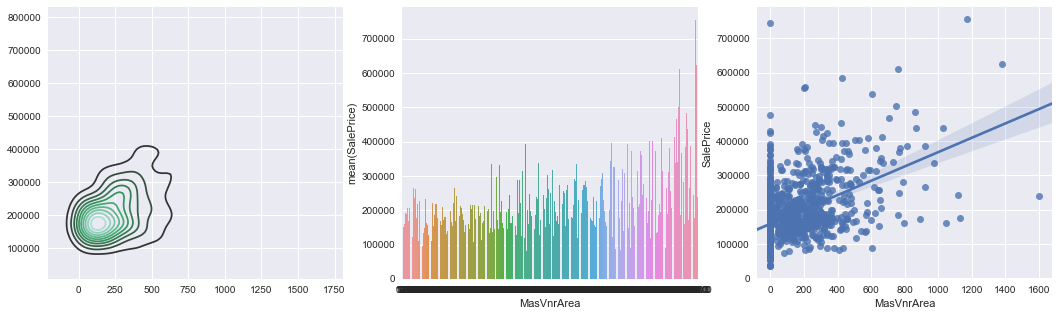

In [165]:
multiple_graphs('MasVnrArea')

In [166]:
train_df = fill_na(train_df, 'MasVnrArea')
test_df = fill_na(test_df, 'MasVnrArea')

/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [167]:
# train_df.MasVnrArea.isnull().sum()
test_df.MasVnrArea.isnull().sum()

0

In [168]:
train_df.MasVnrArea.describe()

count    1460.000000
mean      103.766438
std       180.645346
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

In [169]:
test_df.MasVnrArea.describe()

count    1459.000000
mean      100.703221
std       176.821930
min         0.000000
25%         0.000000
50%         0.000000
75%       163.500000
max      1290.000000
Name: MasVnrArea, dtype: float64

(array([ 878.,    1.,    0.,    8.,   20.,   47.,  121.,  236.,  116.,   32.]),
 array([ 0.        ,  0.71631724,  1.43263448,  2.14895172,  2.86526896,
         3.5815862 ,  4.29790343,  5.01422067,  5.73053791,  6.44685515,
         7.16317239]),
 <a list of 10 Patch objects>)

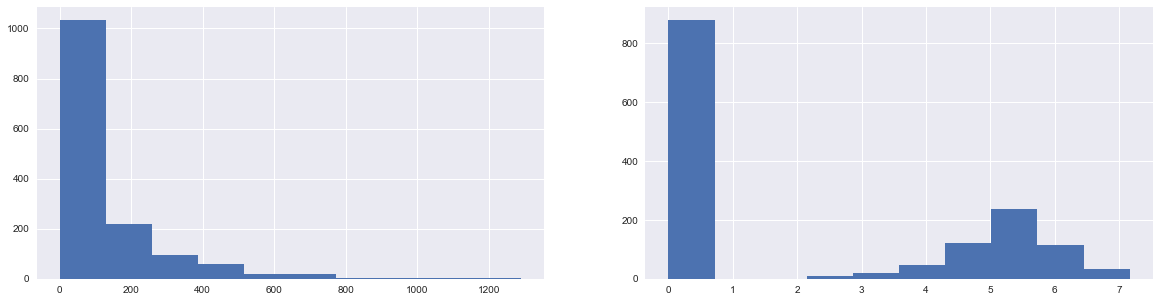

In [170]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,5))
ax1.hist(test_df.MasVnrArea)
ax2.hist(np.log(test_df.MasVnrArea+1))


In [171]:
test_df.MasVnrArea[158]

196.0

In [172]:
A = train_df.SalePrice[train_df.MasVnrArea == 0].mean()
B = train_df.SalePrice[train_df.MasVnrArea != 0].mean()
print(A,B)

train_df.MasVnrArea = np.log(train_df.MasVnrArea+1)
test_df.MasVnrArea = np.log(test_df.MasVnrArea+1)

156557.94657375145 215940.82470784642


In [173]:
test_df.MasVnrArea[pd.isnull]

Series([], Name: MasVnrArea, dtype: float64)

In [174]:
next(next_cat)

'ExterQual'

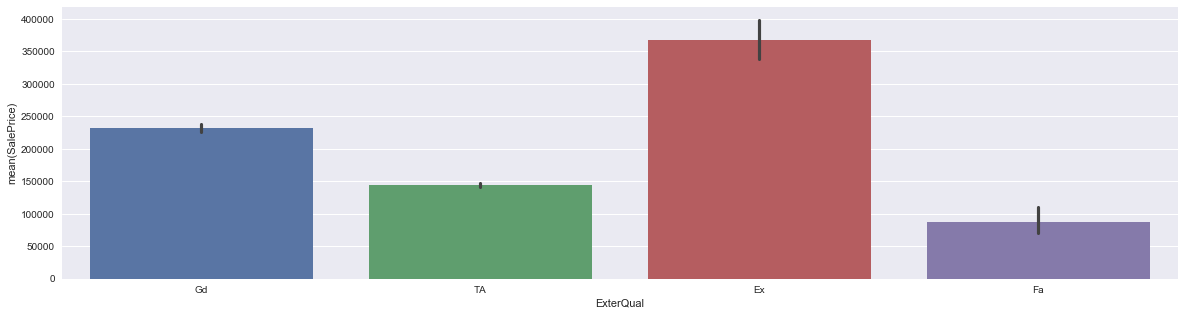

In [175]:
#ExterQual
bargraph('ExterQual')

In [176]:
train_test_count('ExterQual')

ExterQual  train_count  test_count
0        Ex           52          55
1        Fa           14          21
2        Gd          488         491
3        TA          906         892

In [177]:
fs_map('ExterQual')

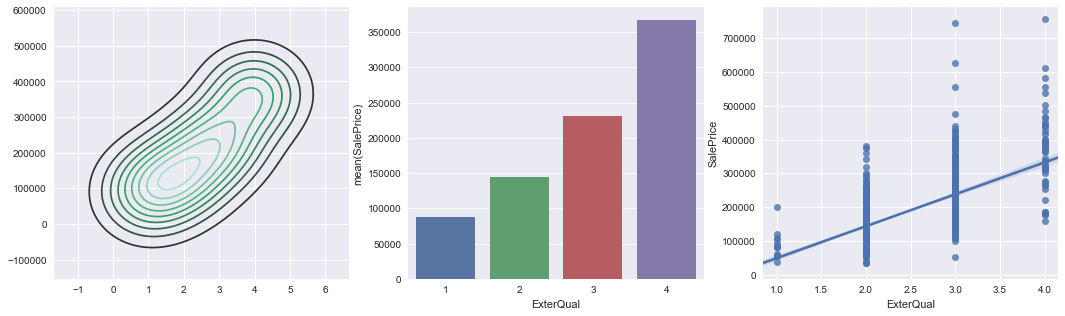

In [178]:
multiple_graphs('ExterQual')

In [179]:
next(next_cat)

'ExterCond'

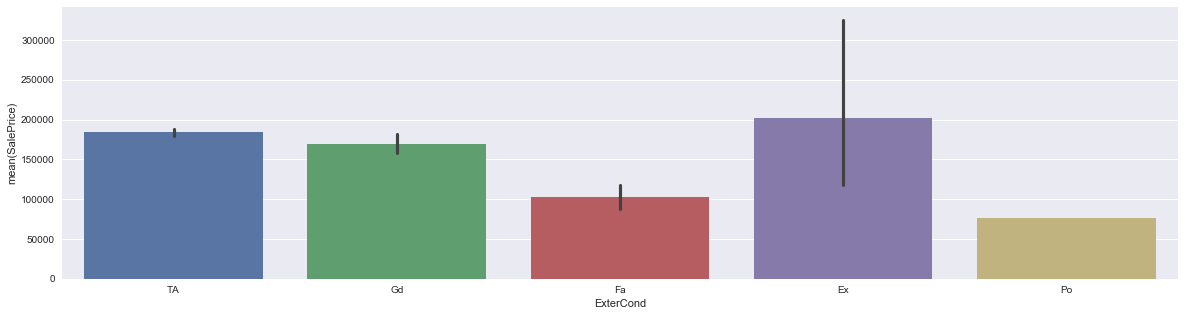

In [180]:
#ExterCond

bargraph('ExterCond')

In [181]:
train_test_count('ExterCond')

ExterCond  train_count  test_count
0        Ex            3           9
1        Fa           28          39
2        Gd          146         153
3        Po            1           2
4        TA         1282        1256

In [182]:
count_price('ExterCond')

ExterCond  SalePrice  count
3        Po      76500      1
1        Fa     102595     28
2        Gd     168897    146
4        TA     184034   1282
0        Ex     201333      3

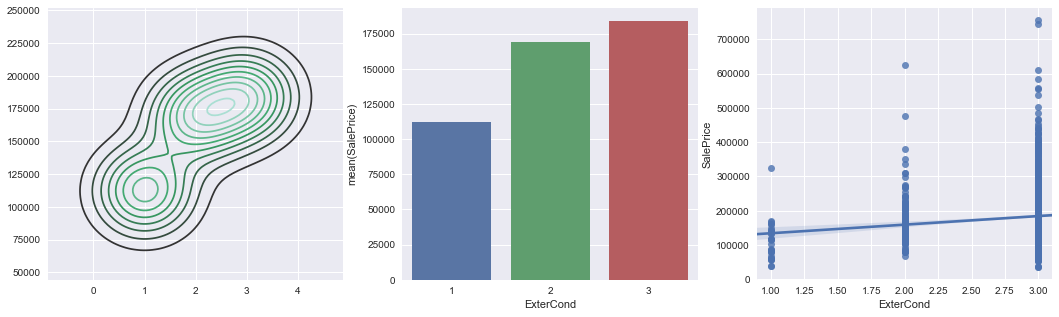

In [183]:
train_df.ExterCond.replace('Po', 'TA', inplace = True)
test_df.ExterCond.replace('Po', 'TA', inplace = True)
train_df.ExterCond.replace('Ex', 'Fa', inplace = True)
test_df.ExterCond.replace('Ex', 'Fa', inplace = True)
count_price('ExterCond')

fs_map('ExterCond')
multiple_graphs('ExterCond')

In [184]:
next(next_cat)

'Foundation'

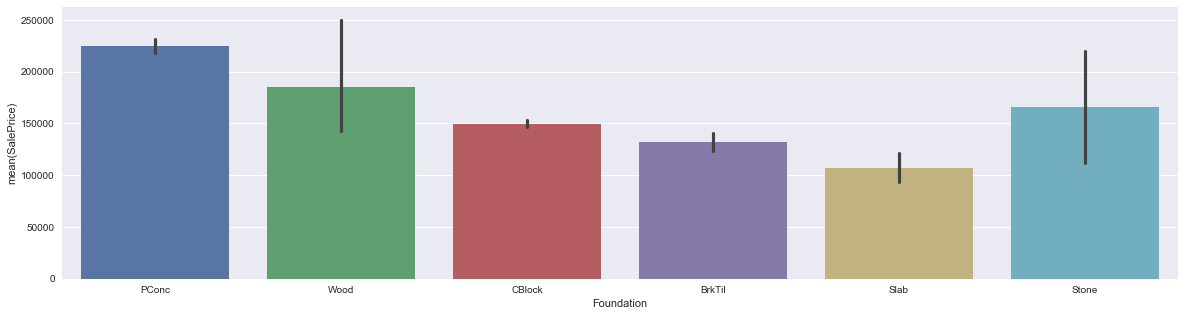

In [185]:
#Foundation

bargraph('Foundation')

In [186]:
train_test_count('Foundation')

Foundation  train_count  test_count
0     BrkTil          146         165
1     CBlock          634         601
2      PConc          647         661
3       Slab           24          25
4      Stone            6           5
5       Wood            3           2

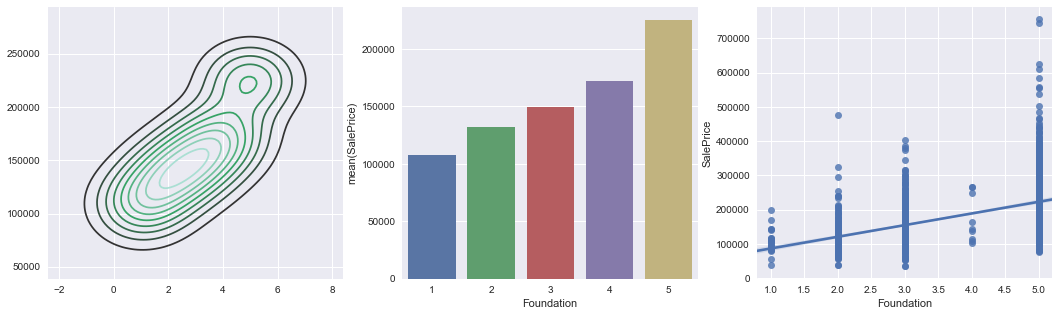

In [187]:
train_df.Foundation.replace('Wood', 'Stone', inplace = True)
test_df.Foundation.replace('Wood', 'Stone', inplace = True)
fs_map('Foundation')
multiple_graphs('Foundation')

In [188]:
next(next_cat)

'BsmtQual'

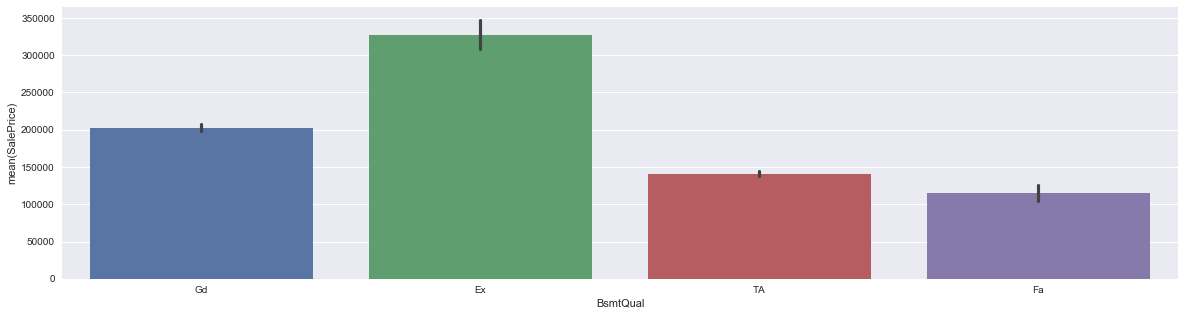

In [189]:
# BsmtQual
bargraph('BsmtQual')

In [190]:
train_test_count('BsmtQual')

BsmtQual  train_count  test_count
0       Ex          121         137
1       Fa           35          53
2       Gd          618         591
3       TA          649         634

In [191]:
test_df

Id  MSSubClass  MSZoning  LotFrontage  LotShape  LandContour  \
0     1461.0        10.0       2.0     4.382027       1.0          2.0   
1     1463.0        12.0       3.0     4.304065       2.0          2.0   
2     1464.0        12.0       3.0     4.356709       2.0          2.0   
3     1468.0        12.0       3.0     4.143135       2.0          2.0   
4     1476.0        12.0       3.0     4.624973       2.0          2.0   
5     1477.0        10.0       3.0     4.543295       2.0          2.0   
6     1478.0        10.0       3.0     4.499810       1.0          2.0   
7     1480.0        10.0       3.0     4.700480       1.0          4.0   
8     1481.0        12.0       3.0     4.653960       1.0          2.0   
9     1482.0        11.0       3.0     3.713572       2.0          2.0   
10    1483.0        10.0       3.0     4.605170       2.0          2.0   
11    1484.0        11.0       3.0     3.761200       1.0          2.0   
12    1485.0         9.0       3.0     4.204693       2.0          2.0   
13    1486.0        12.0       3.0     4.143135       2.0          2.0   
14    1487.0        12.0       3.0     4.094345       3.0          2.0   
15    1488.0        10.0       3.0     4.290459       1.0          2.0   
16    1489.0        10.0       4.0     4.521789       1.0          2.0   
17    1490.0        10.0       4.0     4.430817       1.0          2.0   
18    1491.0        12.0       3.0     4.248495       1.0          2.0   
19    1497.0         5.0       4.0     3.663562       1.0          2.0   
20    1500.0         5.0       4.0     3.178054       1.0          2.0   
21    1502.0         5.0       4.0     4.488636       2.0          2.0   
22    1504.0        12.0       4.0     4.219508       2.0          2.0   
23    1505.0        10.0       4.0     4.382027       1.0          2.0   
24    1510.0        10.0       3.0     4.382027       1.0          2.0   
25    1519.0        10.0       3.0     4.248495       1.0          2.0   
26    1535.0         6.0       2.0     4.234107       1.0          2.0   
27    1549.0         6.0       2.0     3.951244       1.0          2.0   
28    1554.0         8.0       2.0     3.951244       1.0          2.0   
29    1558.0         6.0       3.0     4.174387       2.0          1.0   
...      ...         ...       ...          ...       ...          ...   
1429  2144.0         3.0       3.0     4.094345       1.0          2.0   
1430  2207.0         8.0       3.0     4.605170       2.0          4.0   
1431  2190.0         4.0       3.0     4.174387       1.0          2.0   
1432  2553.0         4.0       3.0     4.304065       1.0          2.0   
1433  2799.0         8.0       2.0     4.094345       1.0          2.0   
1434  2217.0        10.0       3.0     4.382027       1.0          3.0   
1435  2376.0        10.0       3.0     4.382027       1.0          2.0   
1436  2414.0        10.0       3.0     4.094345       1.0          2.0   
1437  2425.0         8.0       3.0     4.727388       1.0          2.0   
1438  2568.0        10.0       3.0     4.477337       2.0          2.0   
1439  2804.0        10.0       3.0     4.605170       1.0          2.0   
1440  2454.0         9.0       2.0     4.330733       1.0          2.0   
1441  2883.0         6.0       3.0     4.394449       2.0          2.0   
1442  2525.0         9.0       3.0     4.276666       1.0          2.0   
1443  2559.0         1.0       3.0     3.988984       1.0          2.0   
1444  2566.0         6.0       3.0     4.700480       2.0          4.0   
1445  2569.0        10.0       3.0     4.043051       2.0          2.0   
1446  2711.0         9.0       3.0     4.605170       2.0          3.0   
1447  2727.0         3.0       3.0     4.382027       1.0          2.0   
1448  2753.0        10.0       3.0     4.248495       1.0          2.0   
1449  2766.0         6.0       3.0     4.094345       1.0          2.0   
1450  2767.0         4.0       3.0     4.094345       1.0          2.0   
1451  2777.0  

37 44
0 0


/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


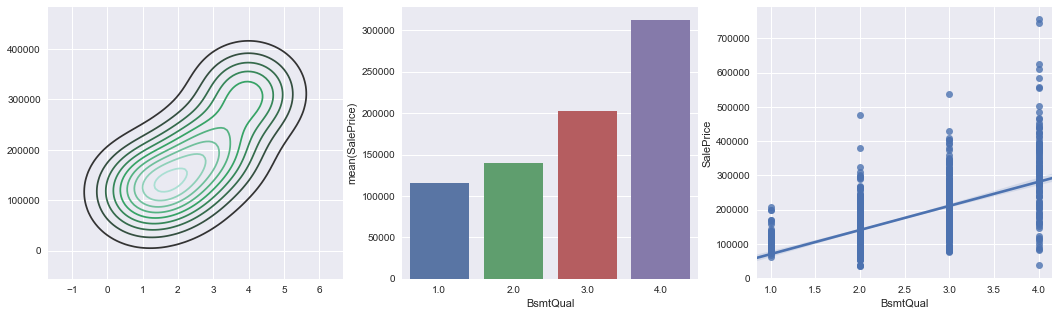

In [192]:
fs_map('BsmtQual')
train_df, test_df = fill_na_cat('BsmtQual', 4)
multiple_graphs('BsmtQual')

In [193]:
next(next_cat)

'BsmtCond'

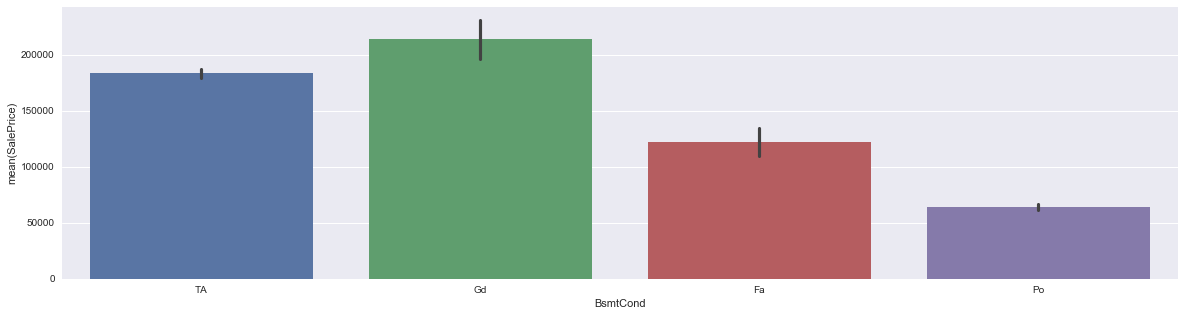

In [194]:
#BsmtCond

bargraph('BsmtCond')


In [195]:
train_test_count('BsmtCond')

BsmtCond  train_count  test_count
0       Fa           45          59
1       Gd           65          57
2       Po            2           3
3       TA         1311        1295

In [196]:
train_df.BsmtCond.replace('Po', 'Fa', inplace = True)
test_df.BsmtCond.replace('Po', 'Fa', inplace = True)
fs_map('BsmtCond')
train_df, test_df = fill_na_cat('BsmtCond', 3)

37 45
0 0


/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


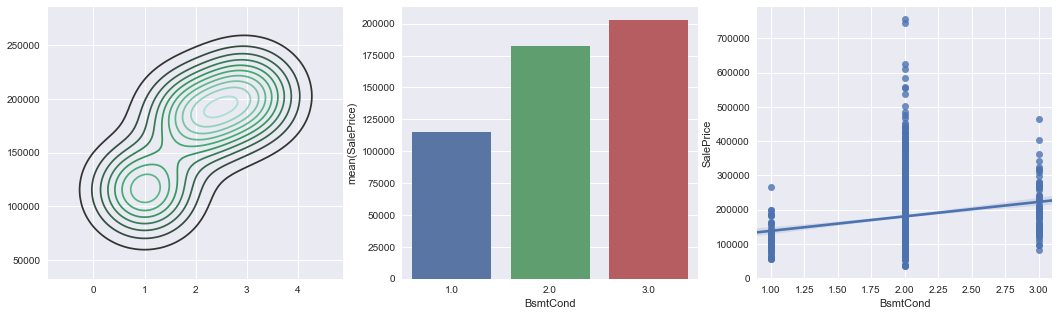

In [197]:
multiple_graphs('BsmtCond')

In [198]:
next(next_cat)

'BsmtExposure'

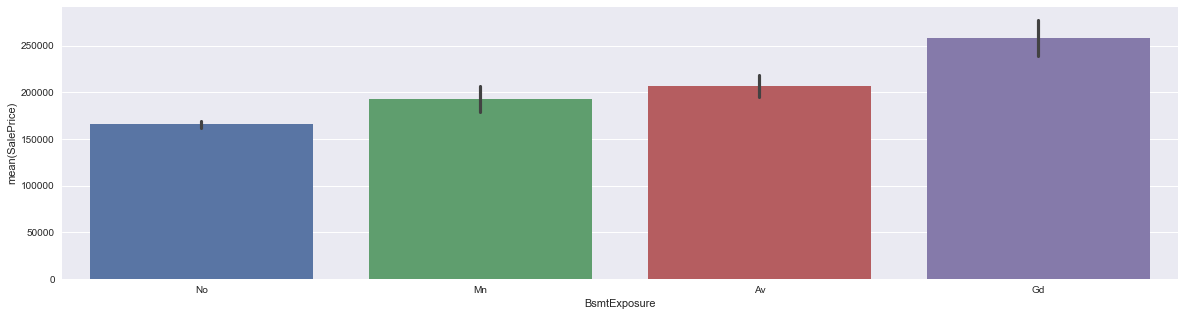

In [199]:
#BsmtExposure
bargraph('BsmtExposure')

In [200]:
train_test_count('BsmtExposure')

BsmtExposure  train_count  test_count
0           Av          221         197
1           Gd          134         142
2           Mn          114         125
3           No          953         951

38 44


/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0 0


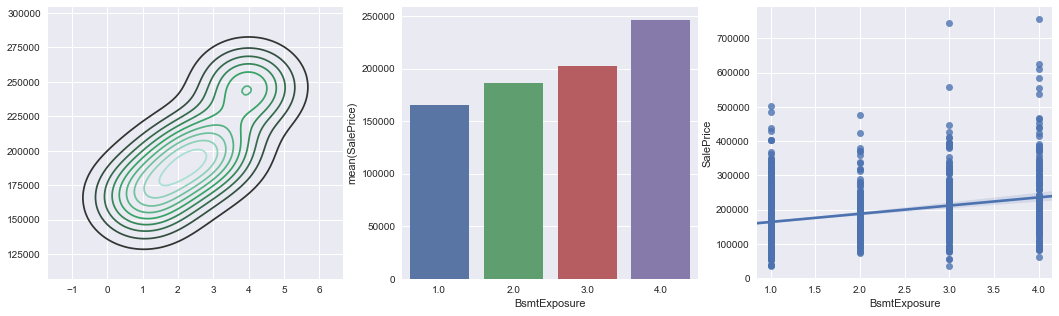

In [201]:
fs_map('BsmtExposure')
train_df, test_df = fill_na_cat('BsmtExposure', 4)
multiple_graphs('BsmtExposure')

In [202]:
next(next_cat)

'BsmtFinType1'

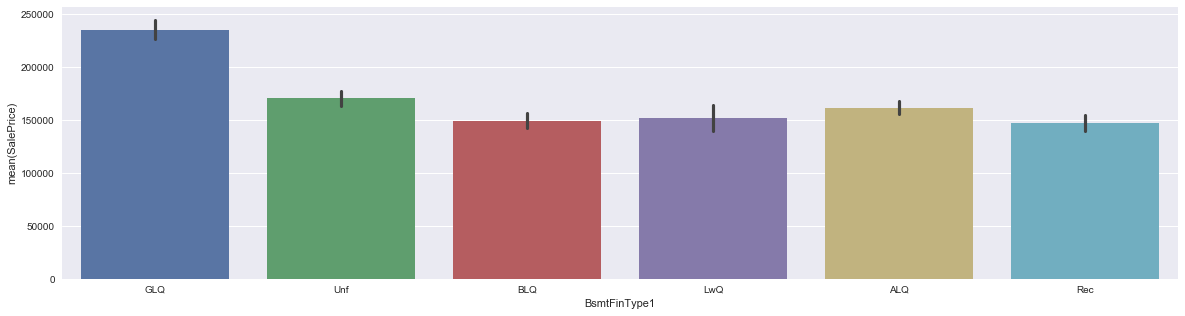

In [203]:
#BsmtFinType1
bargraph('BsmtFinType1')


In [204]:
train_test_count('BsmtFinType1')

BsmtFinType1  train_count  test_count
0          ALQ          220         209
1          BLQ          148         121
2          GLQ          418         431
3          LwQ           74          80
4          Rec          133         155
5          Unf          430         421

37 42


/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0 0


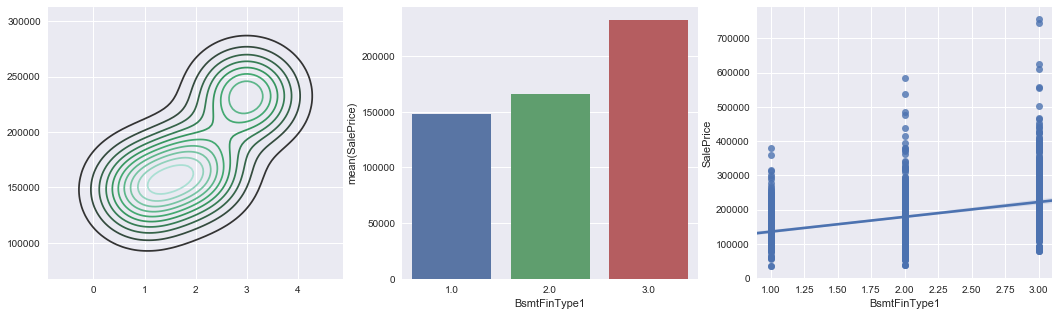

In [205]:
the_map = {'BLQ':1, 'LwQ':1, 'Rec':1, 'Unf':2, 'ALQ':2, 'GLQ':3}
category_mapping('BsmtFinType1', the_map)
train_df, test_df = fill_na_cat('BsmtFinType1', 3)
multiple_graphs('BsmtFinType1')

In [206]:
next(next_cat)

'BsmtFinSF1'

In [207]:
#BsmtFinSF1
#start from here
train_df.BsmtFinSF1

0        706
1        486
2        655
3        732
4       1369
5          0
6        646
7          0
8          0
9          0
10      1218
11         0
12         0
13         0
14       731
15       967
16       280
17      1351
18        24
19       182
20         0
21         0
22       941
23        24
24       739
25         0
26      1013
27         0
28         0
29       228
        ... 
1430       0
1431     182
1432       0
1433    1416
1434     442
1435     564
1436     697
1437       0
1438     505
1439     841
1440     599
1441       0
1442       0
1443     247
1444    1165
1445     412
1446     296
1447    1456
1448     666
1449    1406
1450     297
1451       0
1452       0
1453       0
1454       0
1455       0
1456     315
1457     180
1458     656
1459       0
Name: BsmtFinSF1, dtype: int64

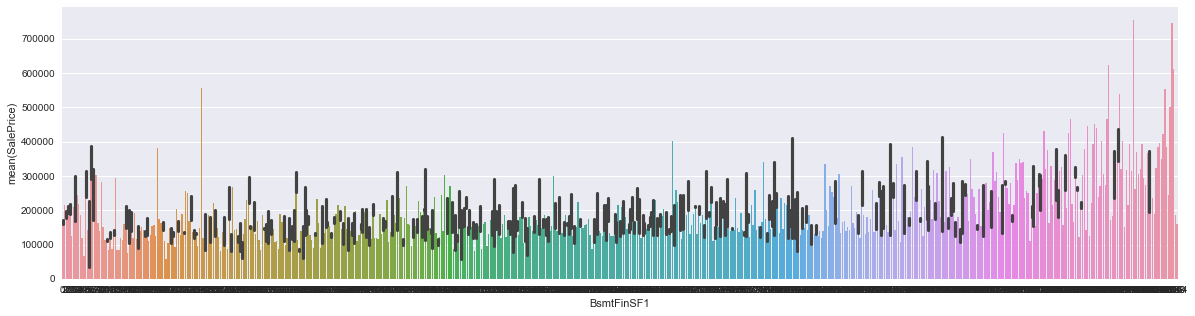

In [208]:
bargraph('BsmtFinSF1')

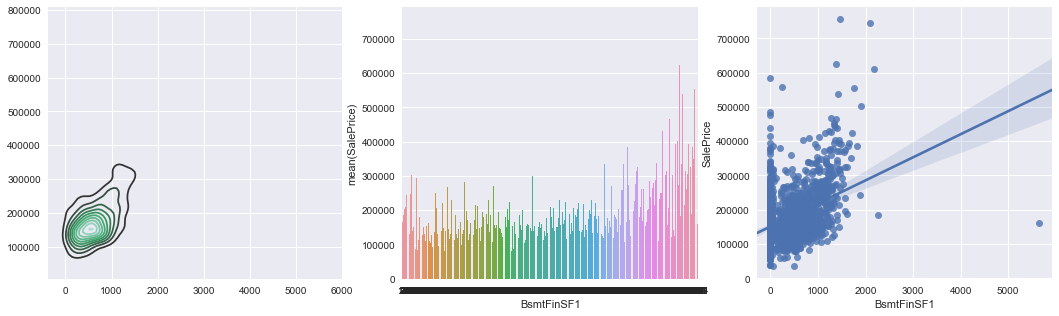

In [209]:
multiple_graphs('BsmtFinSF1')

In [210]:
# train_df.BsmtFinSF1.groupby(train_df.BsmtFinSF1).size()
train_df.BsmtFinSF1[train_df.BsmtFinSF1 < 500] = 1
train_df.BsmtFinSF1[train_df.BsmtFinSF1 >= 500] = 2
test_df.BsmtFinSF1[test_df.BsmtFinSF1 < 500] = 1
test_df.BsmtFinSF1[test_df.BsmtFinSF1 >= 500] = 2

/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/HyesooYoun/a

In [211]:
train_df, test_df = fill_na_cat('BsmtFinSF1', 2)

0 1
0 0


/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [212]:
train_df.BsmtFinSF1.groupby(train_df.BsmtFinSF1).size()

BsmtFinSF1
1    844
2    616
dtype: int64

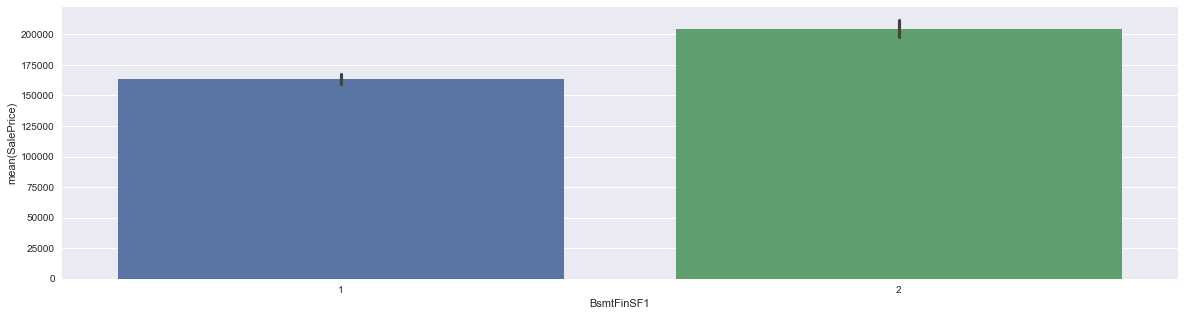

In [213]:
bargraph('BsmtFinSF1')

In [214]:
next(next_cat)

'BsmtFinType2'

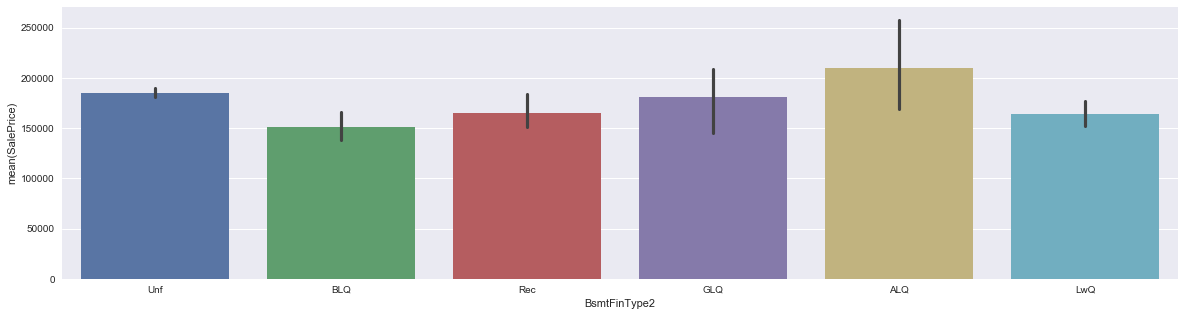

In [215]:
#BsmtFinType2

bargraph('BsmtFinType2')

In [216]:
train_test_count('BsmtFinType2').sum()

BsmtFinType2    ALQBLQGLQLwQRecUnf
train_count                   1422
test_count                    1417
dtype: object

In [217]:
train_test_count('BsmtFinType2')

BsmtFinType2  train_count  test_count
0          ALQ           19          33
1          BLQ           33          35
2          GLQ           14          20
3          LwQ           46          41
4          Rec           54          51
5          Unf         1256        1237

In [218]:
the_map = {'LwQ':1, 'Rec':1,'BLQ':1, 'ALQ':2, 'GLQ':2, 'Unf':2}
category_mapping('BsmtFinType2', the_map)
train_df, test_df = fill_na_cat('BsmtFinType2',2)

38 42
0 0


/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [219]:
train_test_count('BsmtFinType2')

BsmtFinType2  train_count  test_count
0           1.0          157         146
1           2.0         1303        1313

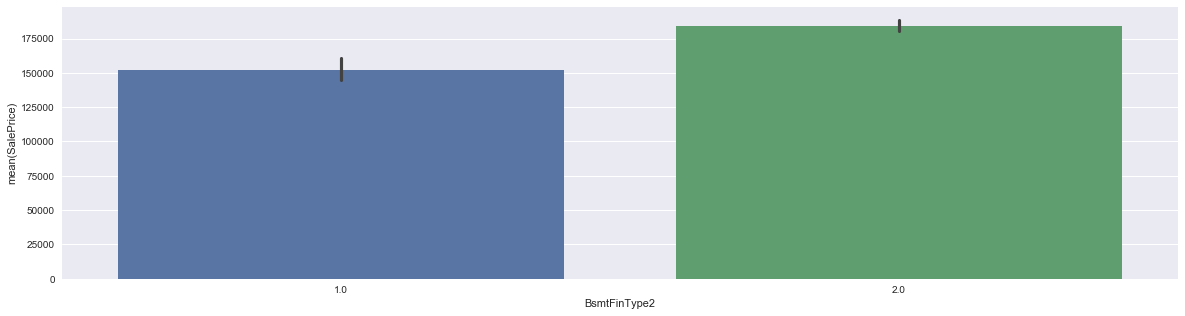

In [220]:
bargraph('BsmtFinType2')

In [221]:
train_df.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage         0
LotShape            0
LandContour         0
LotConfig           0
LandSlope           0
Neighborhood        0
Conditions          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearRemodAdd        0
RoofStyle           0
Exterior1st         0
Exterior2nd         0
MasVnrType          0
MasVnrArea          0
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual            0
BsmtCond            0
BsmtExposure        0
BsmtFinType1        0
BsmtFinSF1          0
BsmtFinType2        0
BsmtFinSF2          0
                 ... 
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive          0
WoodDeckSF

In [222]:
nullcol()

columns  NaN of train_df  NaN of test_df
0     Electrical              1.0             NaN
1    FireplaceQu            690.0           730.0
2     GarageType             81.0            76.0
3    GarageYrBlt             81.0            78.0
4   GarageFinish             81.0            78.0
5     GarageQual             81.0            78.0
6     GarageCond             81.0            78.0
7         PoolQC           1453.0          1456.0
8          Fence           1179.0          1169.0
9    MiscFeature           1406.0          1408.0
10    BsmtFinSF2              NaN             1.0
11     BsmtUnfSF              NaN             1.0
12   TotalBsmtSF              NaN             1.0
13  BsmtFullBath              NaN             2.0
14  BsmtHalfBath              NaN             2.0
15   KitchenQual              NaN             1.0
16    Functional              NaN             2.0
17    GarageCars              NaN             1.0
18    GarageArea              NaN             1.0
19      SaleType              NaN             1.0

In [223]:
train_df.drop(['FireplaceQu','PoolQC', 'Fence', 'MiscFeature'],1, inplace = True)
test_df.drop(['FireplaceQu','PoolQC', 'Fence', 'MiscFeature'],1, inplace = True)

In [224]:
nullcol()

columns  NaN of train_df  NaN of test_df
0     Electrical              1.0             NaN
1     GarageType             81.0            76.0
2    GarageYrBlt             81.0            78.0
3   GarageFinish             81.0            78.0
4     GarageQual             81.0            78.0
5     GarageCond             81.0            78.0
6     BsmtFinSF2              NaN             1.0
7      BsmtUnfSF              NaN             1.0
8    TotalBsmtSF              NaN             1.0
9   BsmtFullBath              NaN             2.0
10  BsmtHalfBath              NaN             2.0
11   KitchenQual              NaN             1.0
12    Functional              NaN             2.0
13    GarageCars              NaN             1.0
14    GarageArea              NaN             1.0
15      SaleType              NaN             1.0

In [225]:
next(next_cat)

'BsmtFinSF2'

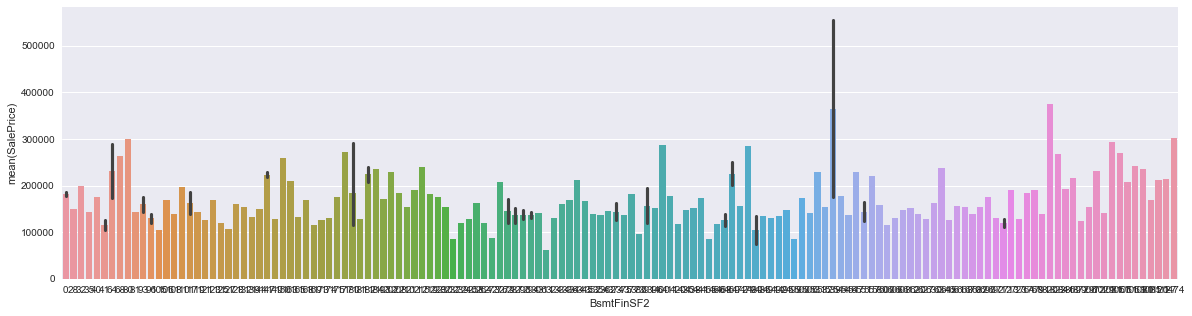

In [226]:
#BsmtFinSF2

bargraph('BsmtFinSF2')

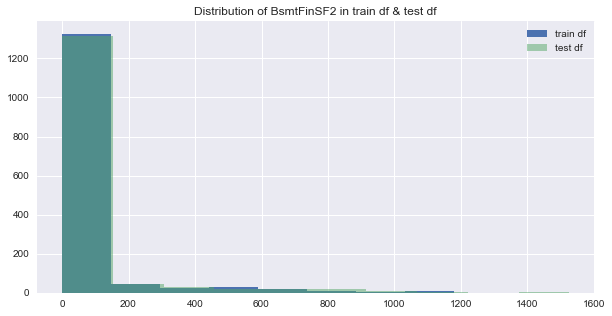

In [227]:
train_test_hist('BsmtFinSF2')

In [228]:
test_df.BsmtFinSF2 = test_df.BsmtFinSF2.fillna(test_df.BsmtFinSF2.mean())

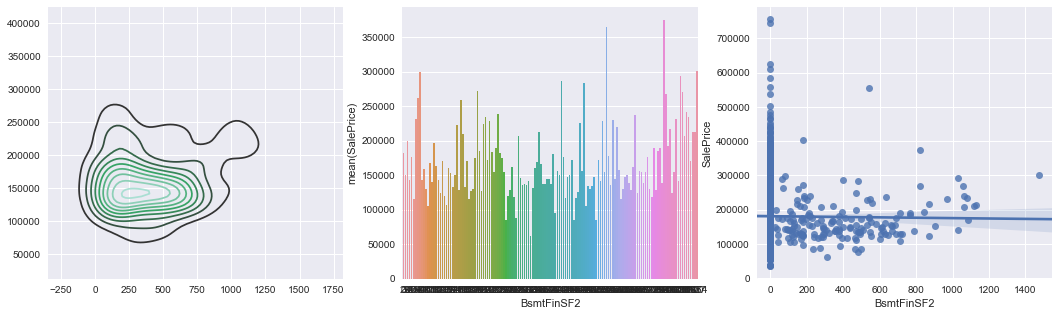

In [229]:
multiple_graphs('BsmtFinSF2')

In [230]:
# No apparent correlation with price

train_df = train_df.drop('BsmtFinSF2', 1)
test_df = test_df.drop('BsmtFinSF2', 1)

In [231]:
next(next_cat)

'BsmtUnfSF'

In [232]:
#BsmtUnfSF
test_df.BsmtUnfSF = test_df.BsmtUnfSF.fillna(test_df.BsmtUnfSF.mean())

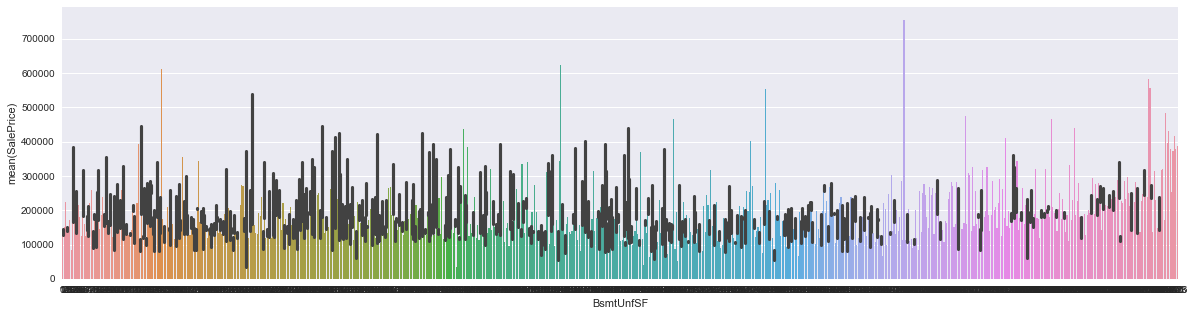

In [233]:
bargraph('BsmtUnfSF')

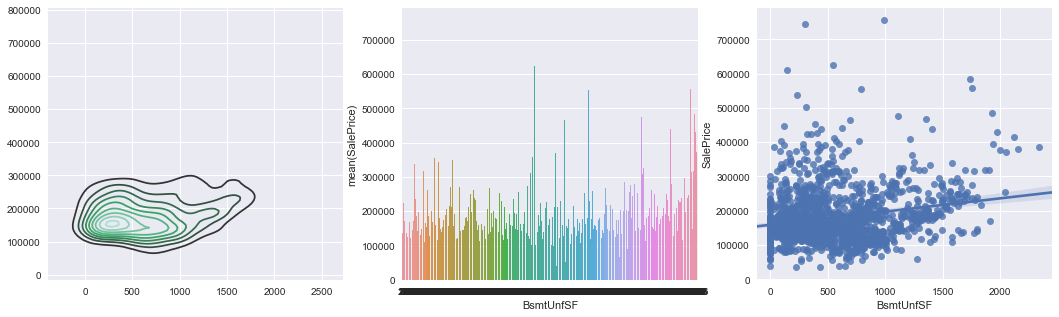

In [234]:
multiple_graphs('BsmtUnfSF')

In [235]:
# No apparent correlation with price

train_df = train_df.drop('BsmtUnfSF', 1)
test_df = test_df.drop('BsmtUnfSF', 1)

In [236]:
nullcol()

columns  NaN of train_df  NaN of test_df
0     Electrical              1.0             NaN
1     GarageType             81.0            76.0
2    GarageYrBlt             81.0            78.0
3   GarageFinish             81.0            78.0
4     GarageQual             81.0            78.0
5     GarageCond             81.0            78.0
6    TotalBsmtSF              NaN             1.0
7   BsmtFullBath              NaN             2.0
8   BsmtHalfBath              NaN             2.0
9    KitchenQual              NaN             1.0
10    Functional              NaN             2.0
11    GarageCars              NaN             1.0
12    GarageArea              NaN             1.0
13      SaleType              NaN             1.0

In [237]:
next(next_cat)

'TotalBsmtSF'

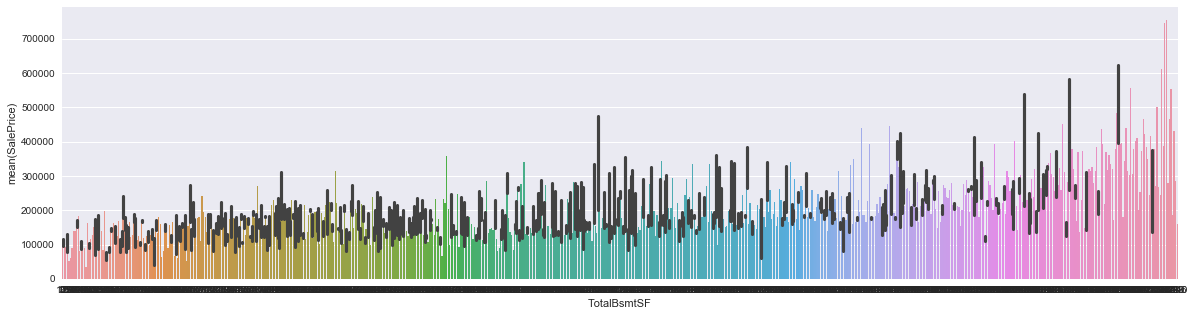

In [238]:
#TotalBsmtSF
bargraph('TotalBsmtSF')

In [239]:
test_df.TotalBsmtSF = test_df.TotalBsmtSF.fillna(test_df.TotalBsmtSF.mean())

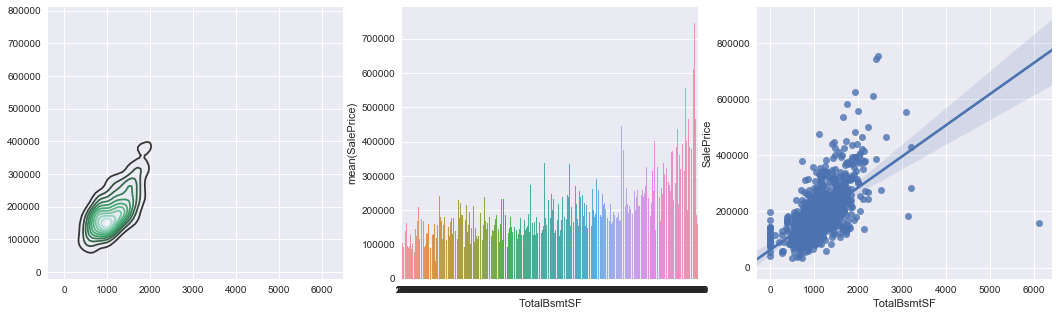

In [240]:
multiple_graphs('TotalBsmtSF')

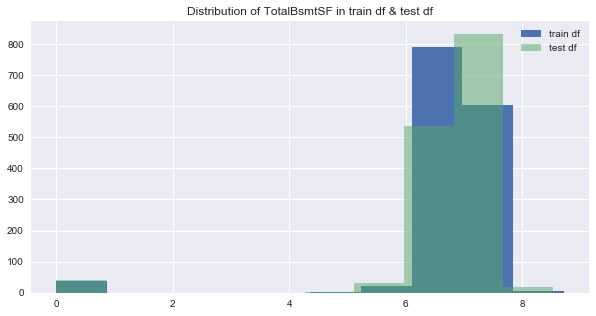

In [241]:
train_df.TotalBsmtSF = np.log(train_df.TotalBsmtSF+1)
test_df.TotalBsmtSF = np.log(test_df.TotalBsmtSF+1)
train_test_hist('TotalBsmtSF')

In [242]:
next(next_cat)

'Heating'

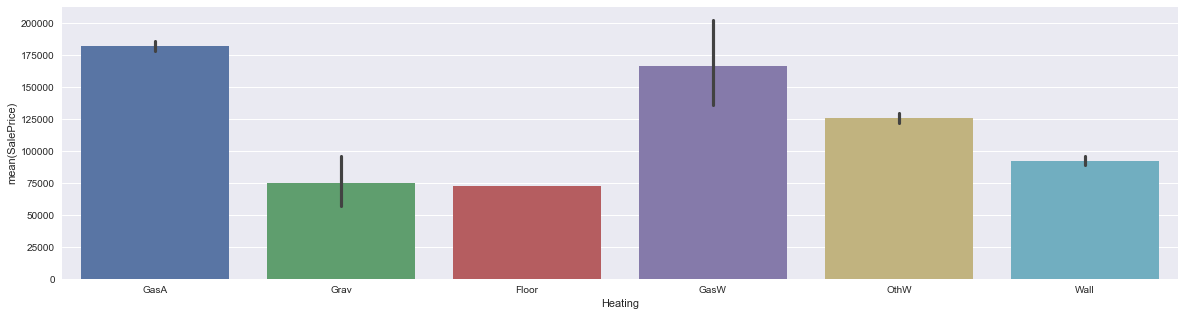

In [243]:
#Heating

bargraph('Heating')

In [244]:
nullcol()

columns  NaN of train_df  NaN of test_df
0     Electrical              1.0             NaN
1     GarageType             81.0            76.0
2    GarageYrBlt             81.0            78.0
3   GarageFinish             81.0            78.0
4     GarageQual             81.0            78.0
5     GarageCond             81.0            78.0
6   BsmtFullBath              NaN             2.0
7   BsmtHalfBath              NaN             2.0
8    KitchenQual              NaN             1.0
9     Functional              NaN             2.0
10    GarageCars              NaN             1.0
11    GarageArea              NaN             1.0
12      SaleType              NaN             1.0

In [245]:
train_test_count('Heating')

Heating  train_count  test_count
0   Floor            1         NaN
1    GasA         1428      1446.0
2    GasW           18         9.0
3    Grav            7         2.0
4    OthW            2         NaN
5    Wall            4         2.0

In [246]:
# Not even categorizing
train_df = train_df.drop('Heating',1)
test_df = test_df.drop('Heating',1)

In [247]:
next(next_cat)

'HeatingQC'

In [248]:
#HeatingQC
train_test_count('HeatingQC')

HeatingQC  train_count  test_count
0        Ex          741         752
1        Fa           49          43
2        Gd          241         233
3        Po            1           2
4        TA          428         429

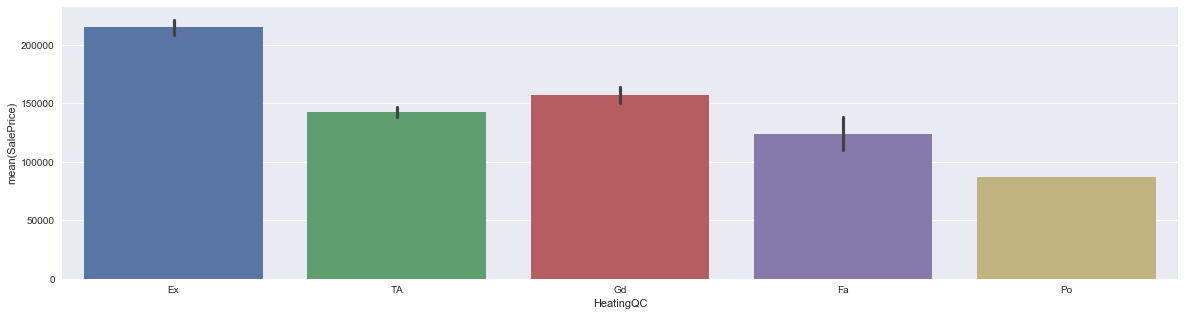

In [249]:
bargraph('HeatingQC')

In [250]:
train_df.HeatingQC.replace('Po','Fa', inplace = True)
test_df.HeatingQC.replace('Po','Fa', inplace = True)

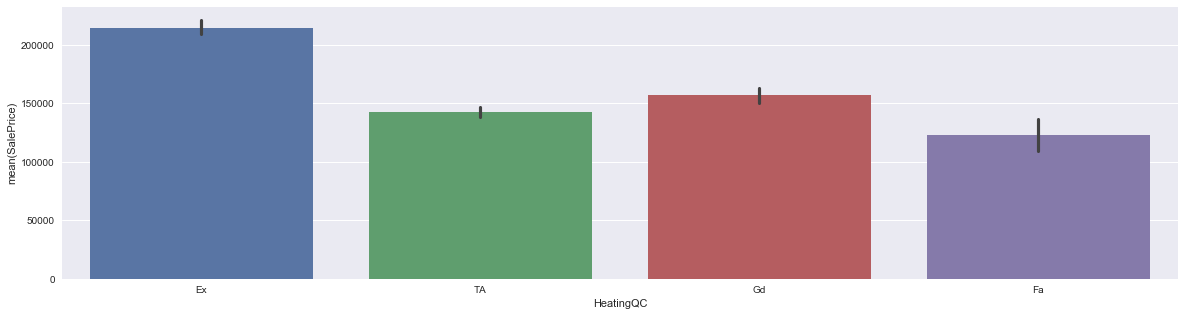

In [251]:
bargraph('HeatingQC')

In [252]:
fs_map('HeatingQC')

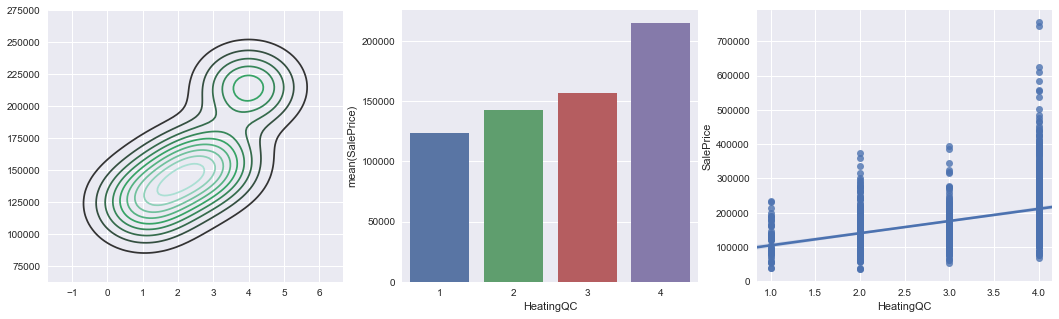

In [253]:
multiple_graphs('HeatingQC')

In [254]:
next(next_cat)

'CentralAir'

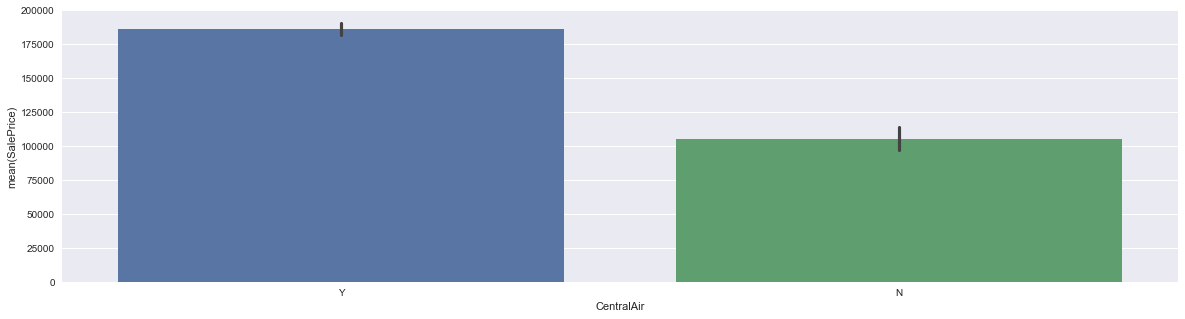

In [255]:
# CentralAir

bargraph('CentralAir')

In [256]:
train_test_count('CentralAir')

CentralAir  train_count  test_count
0          N           95         101
1          Y         1365        1358

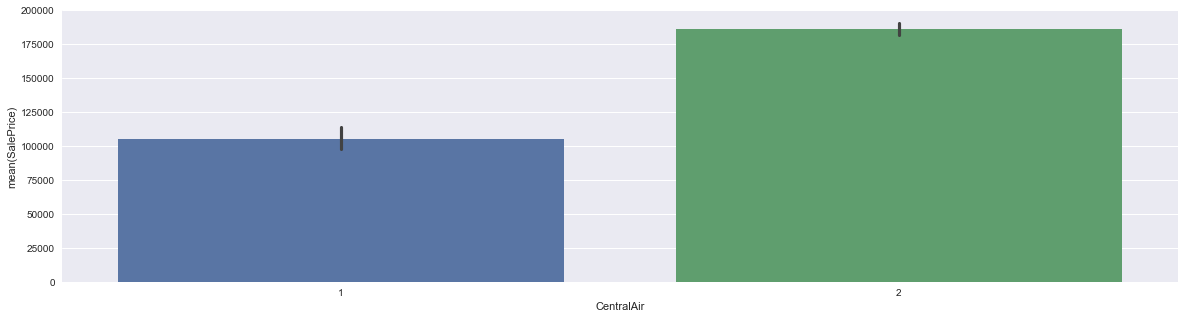

In [257]:
train_df.CentralAir.replace('Y', 2, inplace = True)
train_df.CentralAir.replace('N', 1, inplace = True)
test_df.CentralAir.replace('Y', 2, inplace = True)
test_df.CentralAir.replace('N', 1, inplace = True)
bargraph('CentralAir')

In [258]:
next(next_cat)

'Electrical'

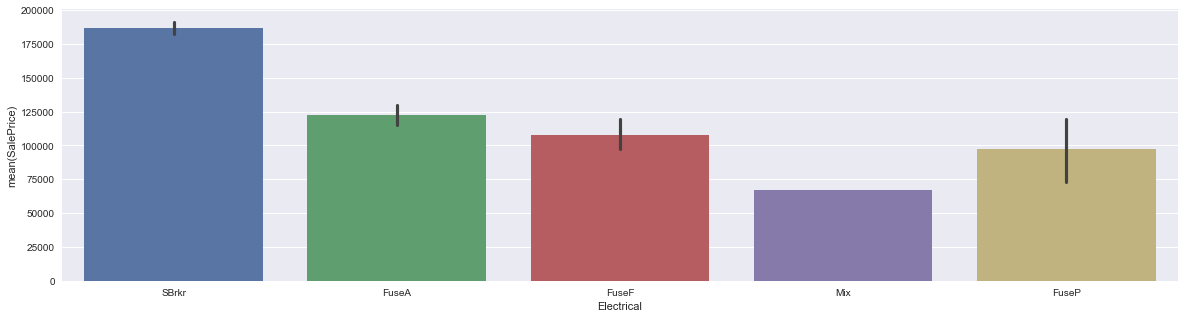

In [259]:
#Electrical

bargraph('Electrical')

In [260]:
train_test_count('Electrical')

Electrical  train_count  test_count
0      FuseA           94        94.0
1      FuseF           27        23.0
2      FuseP            3         5.0
3        Mix            1         NaN
4      SBrkr         1334      1337.0

In [261]:
nullcol()

columns  NaN of train_df  NaN of test_df
0     Electrical              1.0             NaN
1     GarageType             81.0            76.0
2    GarageYrBlt             81.0            78.0
3   GarageFinish             81.0            78.0
4     GarageQual             81.0            78.0
5     GarageCond             81.0            78.0
6   BsmtFullBath              NaN             2.0
7   BsmtHalfBath              NaN             2.0
8    KitchenQual              NaN             1.0
9     Functional              NaN             2.0
10    GarageCars              NaN             1.0
11    GarageArea              NaN             1.0
12      SaleType              NaN             1.0

In [262]:
train_df.Electrical.fillna('SBrkr', inplace = True)

In [263]:
nullcol()

columns  NaN of train_df  NaN of test_df
0     GarageType             81.0              76
1    GarageYrBlt             81.0              78
2   GarageFinish             81.0              78
3     GarageQual             81.0              78
4     GarageCond             81.0              78
5   BsmtFullBath              NaN               2
6   BsmtHalfBath              NaN               2
7    KitchenQual              NaN               1
8     Functional              NaN               2
9     GarageCars              NaN               1
10    GarageArea              NaN               1
11      SaleType              NaN               1

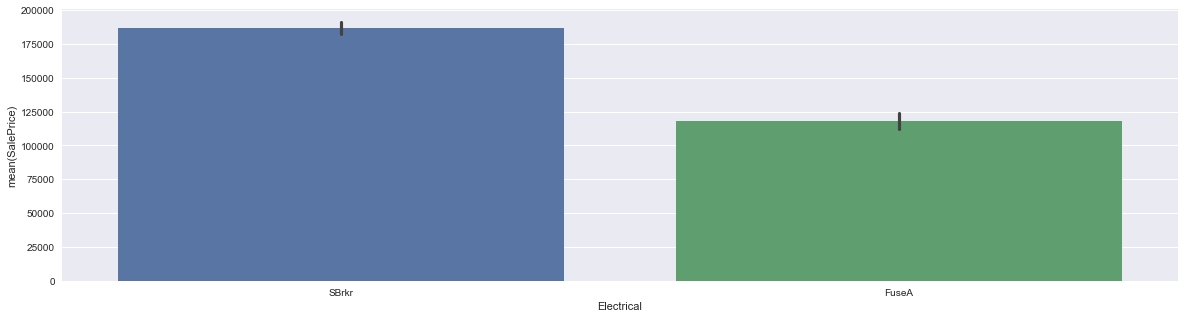

In [264]:
train_df.Electrical.replace(['FuseF', 'FuseP', 'Mix'], 'FuseA', inplace = True)
test_df.Electrical.replace(['FuseF', 'FuseP', 'Mix'], 'FuseA', inplace = True)
bargraph('Electrical')

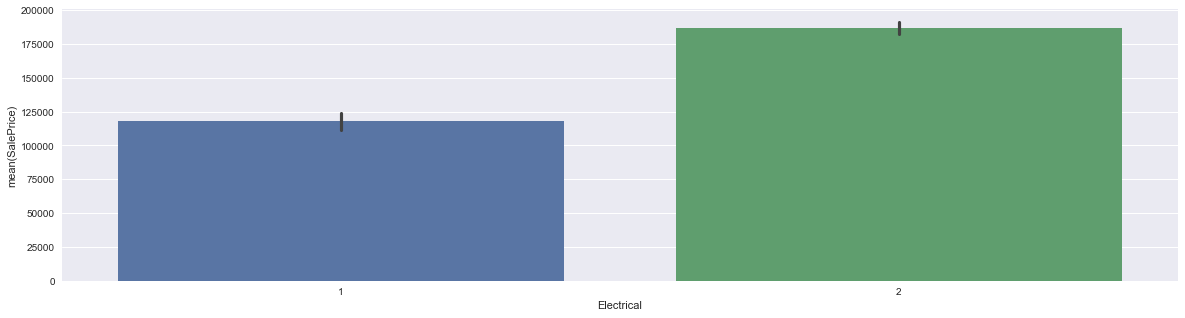

In [265]:
fs_map('Electrical')
bargraph('Electrical')

In [266]:
next(next_cat)

'1stFlrSF'

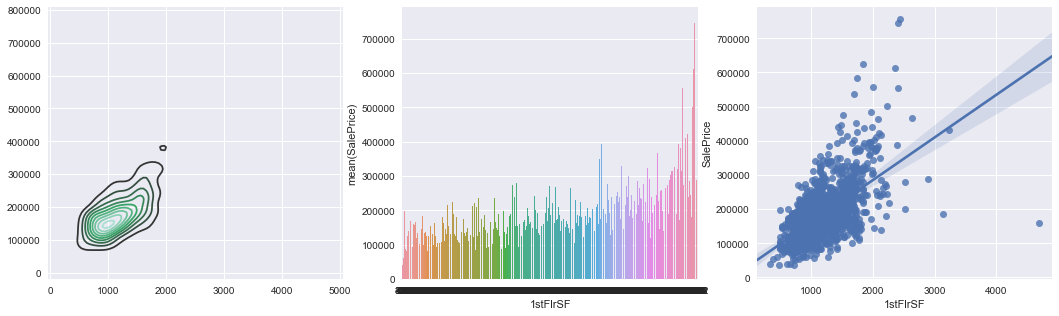

In [267]:
#1stFlrSF
multiple_graphs('1stFlrSF')

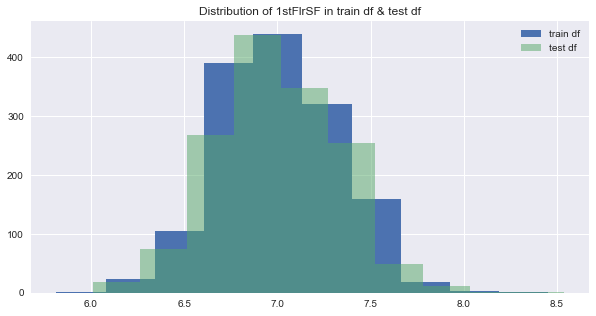

In [268]:
train_df['1stFlrSF'] = np.log(train_df['1stFlrSF'] + 1)
test_df['1stFlrSF'] = np.log(test_df['1stFlrSF'] + 1)
train_test_hist('1stFlrSF')

In [269]:
train_test_count('1stFlrSF').sum()

1stFlrSF       7685.128794
train_count    1460.000000
test_count     1459.000000
dtype: float64

In [270]:
next(next_cat)

'2ndFlrSF'

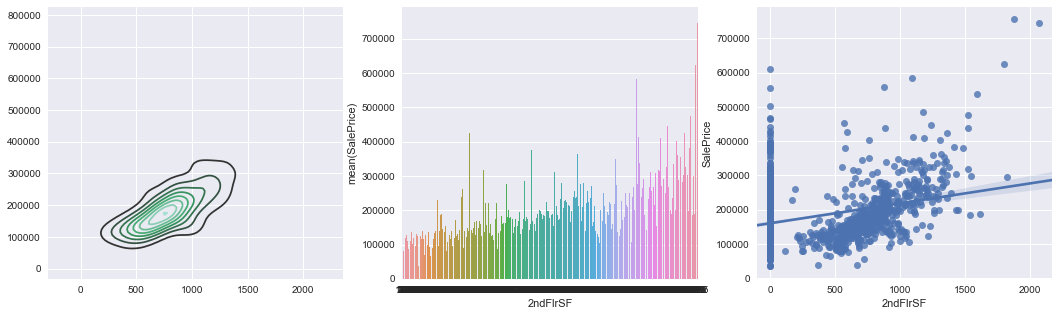

In [271]:
#2ndFlrSF

multiple_graphs('2ndFlrSF')

In [272]:
train_test_count('2ndFlrSF')

2ndFlrSF  train_count  test_count
0           0        829.0       839.0
1         110          1.0         NaN
2         167          1.0         NaN
3         192          1.0         NaN
4         208          1.0         1.0
5         213          1.0         NaN
6         220          1.0         NaN
7         224          1.0         NaN
8         240          2.0         1.0
9         252          2.0         NaN
10        272          1.0         1.0
11        299          1.0         NaN
12        304          1.0         NaN
13        316          1.0         NaN
14        319          1.0         1.0
15        325          1.0         NaN
16        332          1.0         NaN
17        336          1.0         1.0
18        348          1.0         1.0
19        349          1.0         NaN
20        351          1.0         1.0
21        358          1.0         NaN
22        368          1.0         2.0
23        370          1.0         NaN
24        371          1.0         NaN
25        378          1.0         3.0
26        384          2.0         NaN
27        390          1.0         NaN
28        403          1.0         NaN
29        406          2.0         NaN
..        ...          ...         ...
605      1277          NaN         1.0
606      1285          NaN         2.0
607      1295          NaN         1.0
608      1309          NaN         1.0
609      1315          NaN         2.0
610      1319          NaN         1.0
611      1321          NaN         1.0
612      1325          NaN         1.0
613      1335          NaN         1.0
614      1340          NaN         1.0
615      1342          NaN         1.0
616      1345          NaN         1.0
617      1358          NaN         1.0
618      1368          NaN         1.0
619      1369          NaN         1.0
620      1371          NaN         1.0
621      1377          NaN         1.0
622      1384          NaN         1.0
623      1402          NaN         1.0
624      1405          NaN         1.0
625      1407          NaN         1.0
626      1420          NaN         1.0
627      1567          NaN         1.0
628      1619          NaN         3.0
629      1629          NaN         1.0
630      1721          NaN         1.0
631      1778          NaN         1.0
632      1788          NaN         1.0
633      1836          NaN         1.0
634      1862          NaN         1.0

[635 rows x 3 columns]

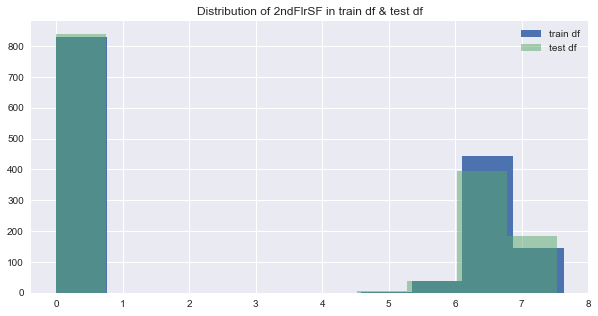

In [273]:
train_df['2ndFlrSF'] = np.log(train_df['2ndFlrSF'] + 1)
test_df['2ndFlrSF'] = np.log(test_df['2ndFlrSF'] + 1)
train_test_hist('2ndFlrSF')

In [274]:
train_test_count('2ndFlrSF').sum()

2ndFlrSF       4204.651993
train_count    1460.000000
test_count     1459.000000
dtype: float64

In [275]:
next(next_cat)

'LowQualFinSF'

In [276]:
#LowQualFinSF
train_test_count('LowQualFinSF')

#drop it
train_df.drop('LowQualFinSF',1,inplace=True)
test_df.drop('LowQualFinSF',1,inplace=True)

In [277]:
next(next_cat)

'GrLivArea'

In [278]:
#GrLivArea
train_test_count('GrLivArea').sum()

GrLivArea      2123883.0
train_count       1460.0
test_count        1459.0
dtype: float64

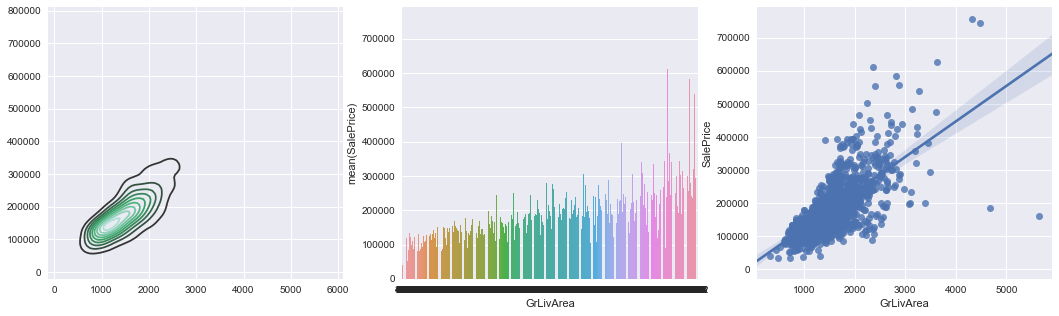

In [279]:
multiple_graphs('GrLivArea')

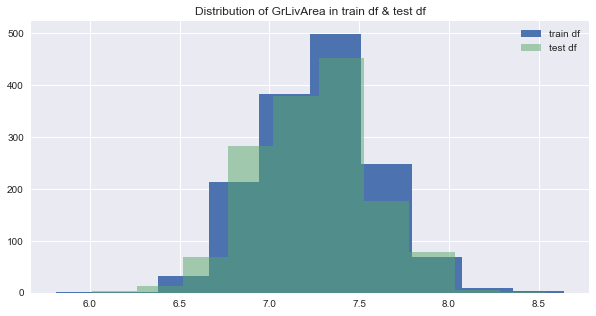

In [280]:
train_df['GrLivArea'] = np.log(train_df['GrLivArea'] + 1)
test_df['GrLivArea'] = np.log(test_df['GrLivArea'] + 1)
train_test_hist('GrLivArea')

In [281]:
next(next_cat)

'BsmtFullBath'

In [282]:
nullcol()

columns  NaN of train_df  NaN of test_df
0     GarageType             81.0              76
1    GarageYrBlt             81.0              78
2   GarageFinish             81.0              78
3     GarageQual             81.0              78
4     GarageCond             81.0              78
5   BsmtFullBath              NaN               2
6   BsmtHalfBath              NaN               2
7    KitchenQual              NaN               1
8     Functional              NaN               2
9     GarageCars              NaN               1
10    GarageArea              NaN               1
11      SaleType              NaN               1

In [283]:
#BsmtFullBath
train_test_count('BsmtFullBath')

BsmtFullBath  train_count  test_count
0             0          856         849
1             1          588         584
2             2           15          23
3             3            1           1

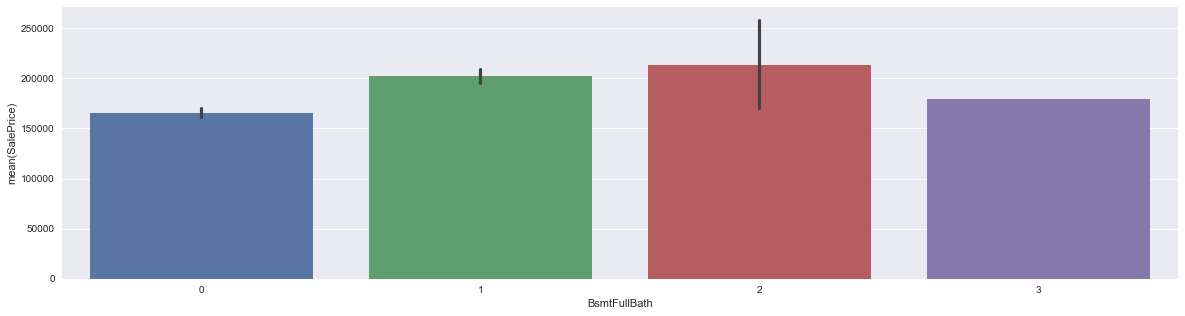

In [284]:
bargraph('BsmtFullBath')

/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


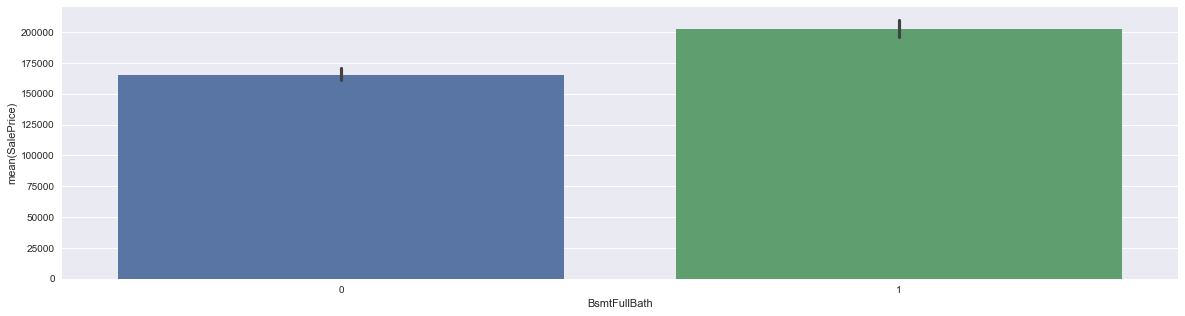

In [285]:
train_df.BsmtFullBath.replace([2,3],1,inplace=True)
test_df.BsmtFullBath.replace([2,3],1,inplace=True)
test_df.BsmtFullBath[pd.isnull] = 0
bargraph('BsmtFullBath')

In [286]:
next(next_cat)

'BsmtHalfBath'

In [287]:
#BsmtHalfBath
train_test_count('BsmtHalfBath')

BsmtHalfBath  train_count  test_count
0             0         1378        1364
1             1           80          91
2             2            2           2

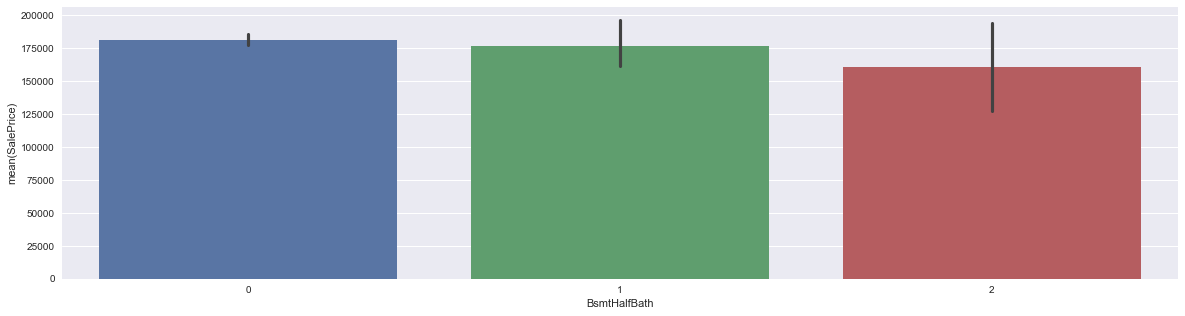

In [288]:
bargraph('BsmtHalfBath')

In [289]:
# Drop it

train_df.drop('BsmtHalfBath', 1, inplace = True)
test_df.drop('BsmtHalfBath', 1, inplace = True)

In [290]:
next(next_cat)

'FullBath'

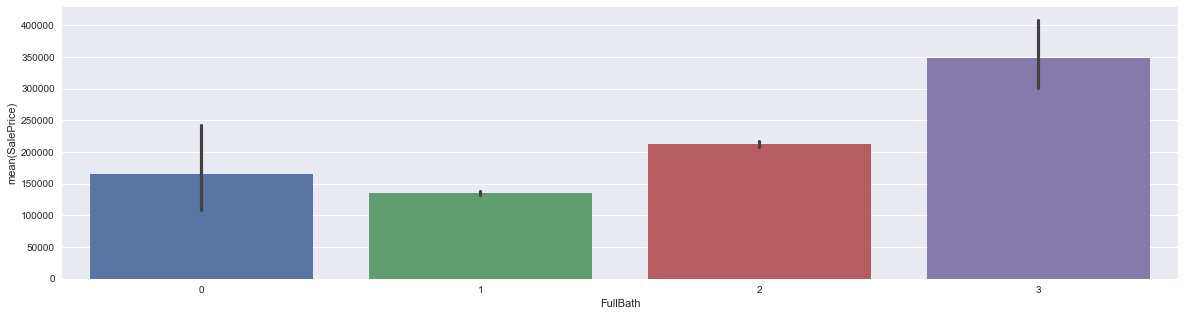

In [291]:
# FullBath

bargraph('FullBath')

In [292]:
train_test_count('FullBath')

FullBath  train_count  test_count
0         0          9.0           3
1         1        650.0         659
2         2        768.0         762
3         3         33.0          31
4         4          NaN           4

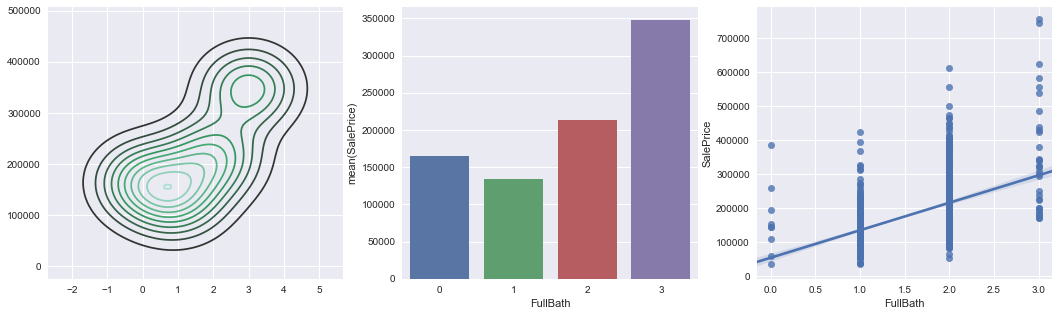

In [293]:
multiple_graphs('FullBath')

/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


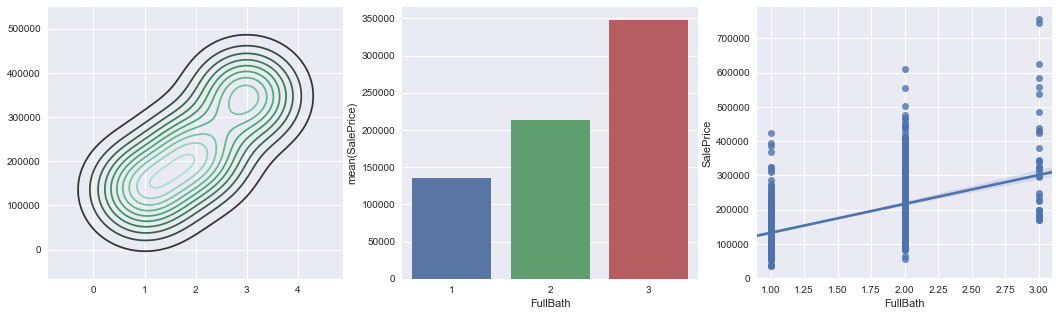

In [294]:
test_df.FullBath[pd.isnull] = (x for x in [1,2])
train_df.FullBath.replace(0,1, inplace = True)
test_df.FullBath.replace(0,1, inplace = True)
test_df.FullBath.replace(4,3, inplace = True)
fs_map('FullBath')
multiple_graphs('FullBath')

In [295]:
next(next_cat)

'HalfBath'

In [296]:
#HalfBath

train_test_count('HalfBath')

HalfBath  train_count  test_count
0         0          913         921
1         1          535         525
2         2           12          13

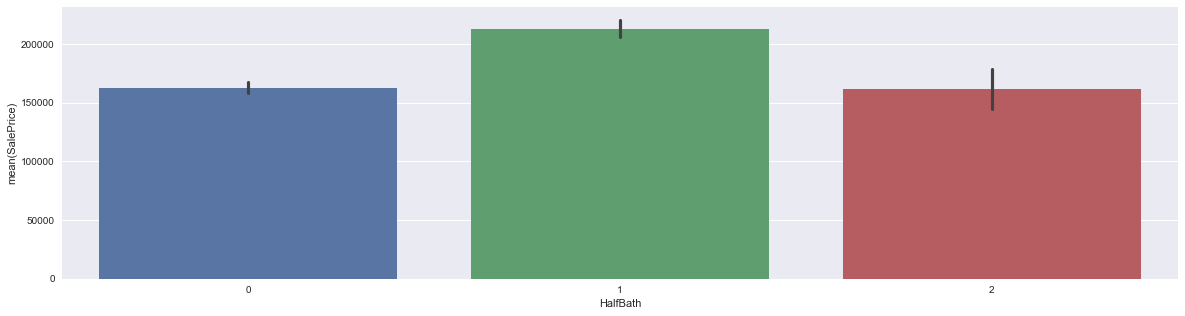

In [297]:
bargraph('HalfBath')

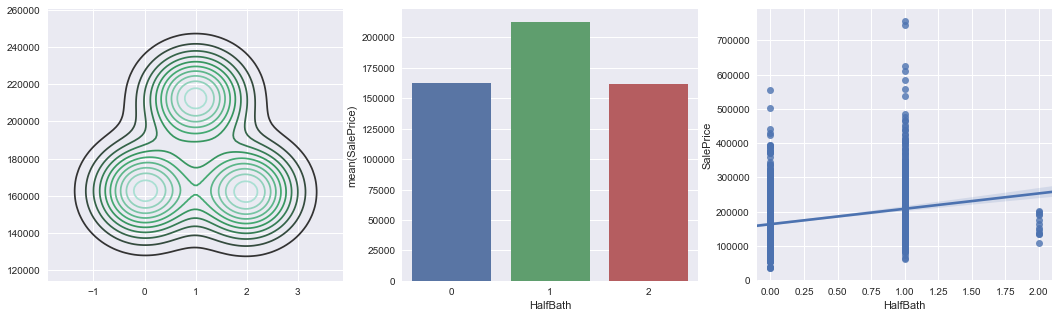

In [298]:
multiple_graphs('HalfBath')

In [299]:
fs_map('HalfBath')

In [300]:
next(next_cat)

'BedroomAbvGr'

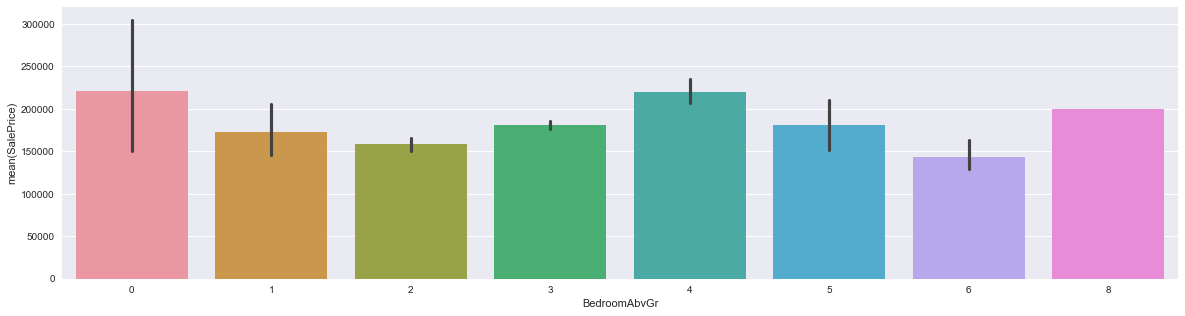

In [301]:
#BedroomAbvGr

bargraph('BedroomAbvGr')

In [302]:
train_test_count('BedroomAbvGr')

BedroomAbvGr  train_count  test_count
0             0            6         2.0
1             1           50        53.0
2             2          358       384.0
3             3          804       792.0
4             4          213       187.0
5             5           21        27.0
6             6            7        14.0
7             8            1         NaN

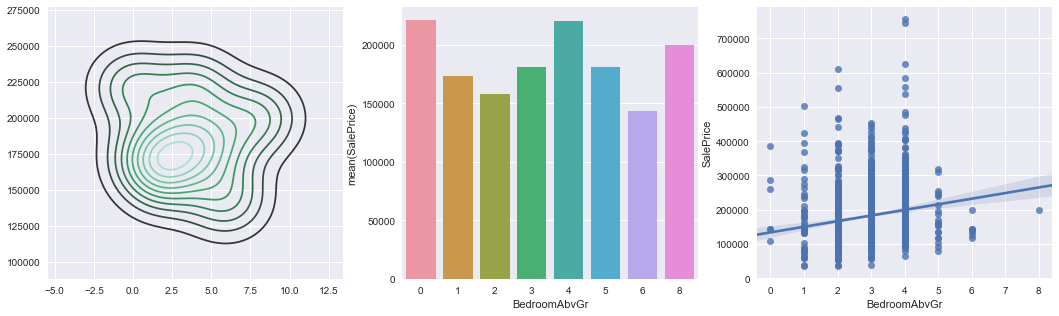

In [303]:
multiple_graphs('BedroomAbvGr')

In [304]:
train_df.BedroomAbvGr.replace([0,1],2,inplace=True)
test_df.BedroomAbvGr.replace([0,1],2,inplace=True)
train_df.BedroomAbvGr.replace([6,7,8],5,inplace=True)
test_df.BedroomAbvGr.replace([6,7,8],5,inplace=True)
fs_map('BedroomAbvGr')

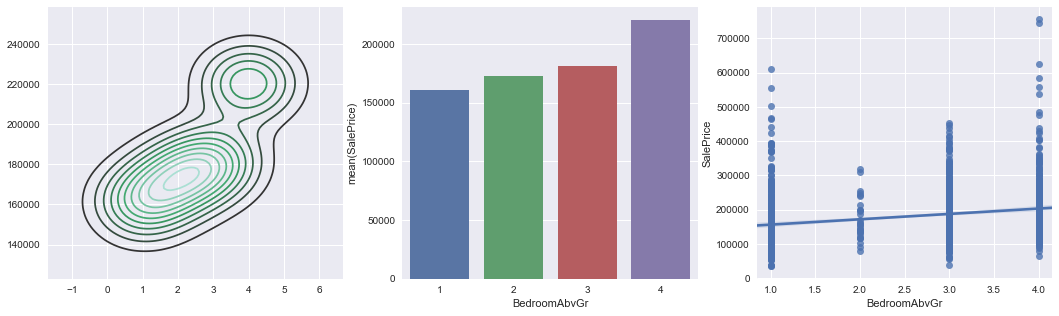

In [305]:
multiple_graphs('BedroomAbvGr')

In [306]:
next(next_cat)

'KitchenAbvGr'

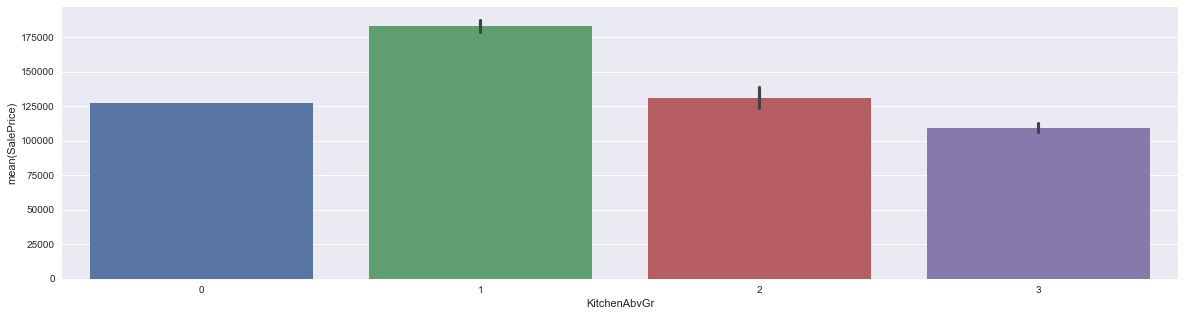

In [307]:
#KitchenAbvGr
bargraph('KitchenAbvGr')

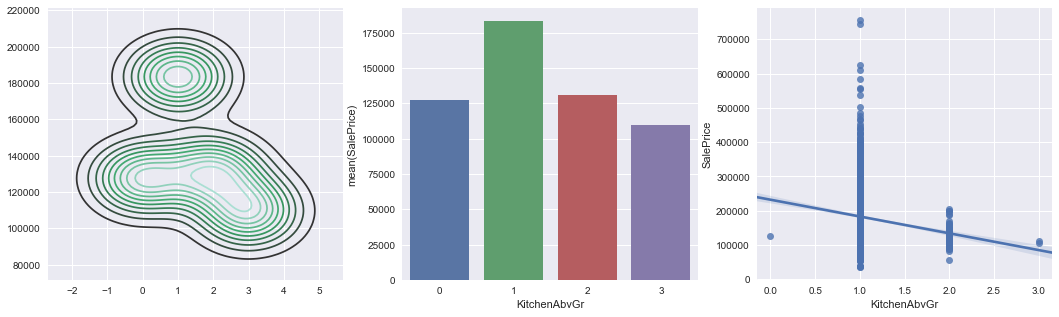

In [308]:
multiple_graphs('KitchenAbvGr')

In [309]:
train_test_count('KitchenAbvGr')

KitchenAbvGr  train_count  test_count
0             0            1         2.0
1             1         1392      1393.0
2             2           65        64.0
3             3            2         NaN

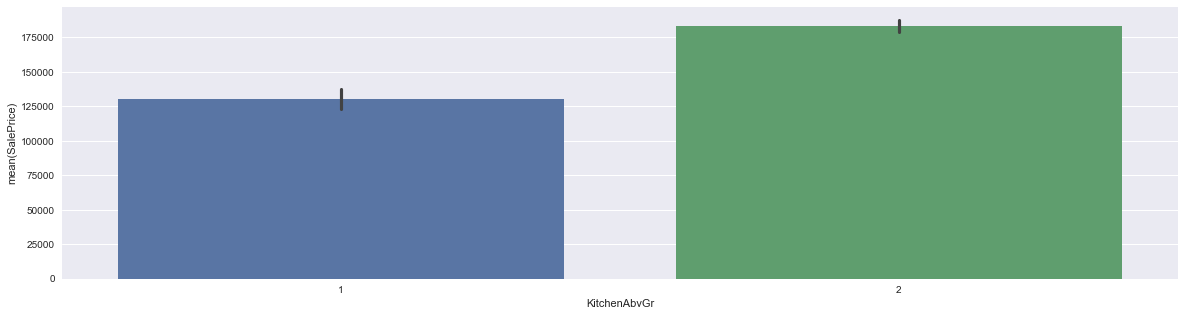

In [310]:
train_df.KitchenAbvGr.replace(0,1,inplace=True)
test_df.KitchenAbvGr.replace(0,1,inplace=True)
train_df.KitchenAbvGr.replace(3,2,inplace=True)
test_df.KitchenAbvGr.replace(3,2,inplace=True)
fs_map('KitchenAbvGr')
bargraph('KitchenAbvGr')

In [311]:
next(next_cat)

'KitchenQual'

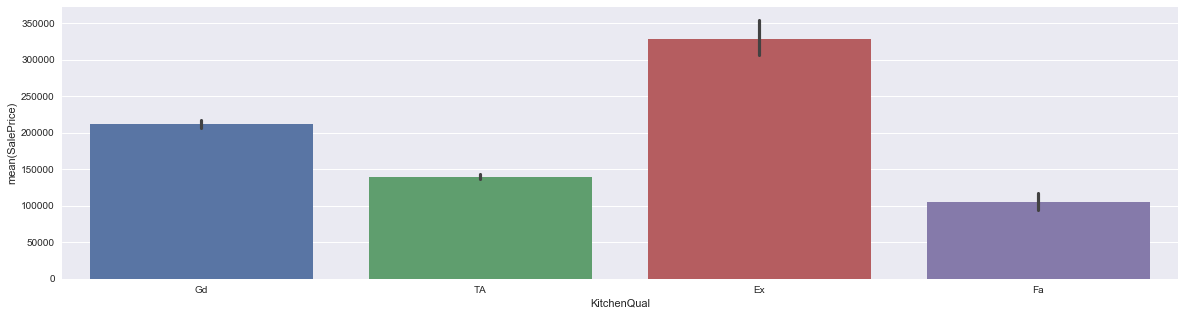

In [312]:
#KitchenQual

bargraph('KitchenQual')

In [313]:
train_test_count('KitchenQual')

KitchenQual  train_count  test_count
0          Ex          100         105
1          Fa           39          31
2          Gd          586         565
3          TA          735         757

/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


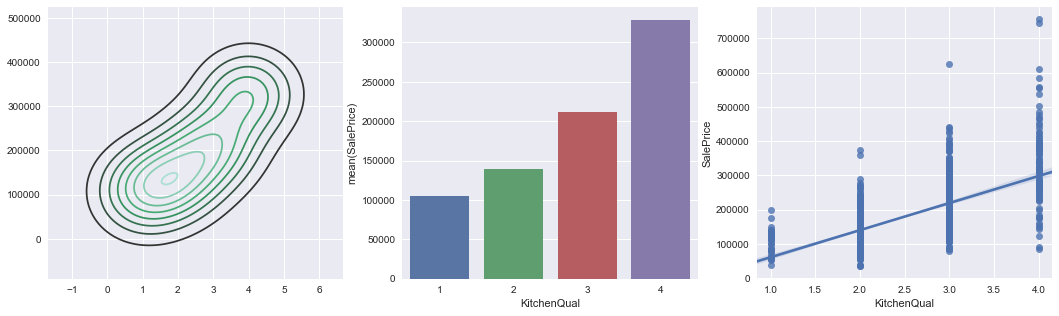

In [314]:
test_df['KitchenQual'][pd.isnull] = 'TA'
fs_map('KitchenQual')
multiple_graphs('KitchenQual')

In [315]:
next(next_cat)

'TotRmsAbvGrd'

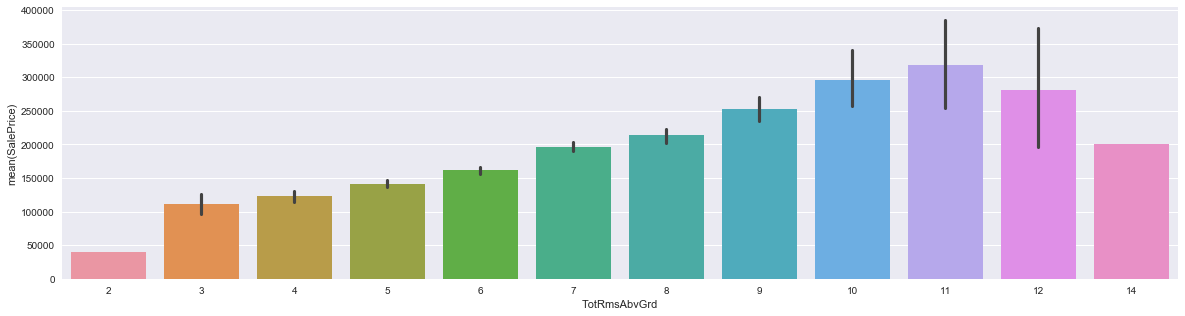

In [316]:
#TotRmsAbvGrd

bargraph('TotRmsAbvGrd')

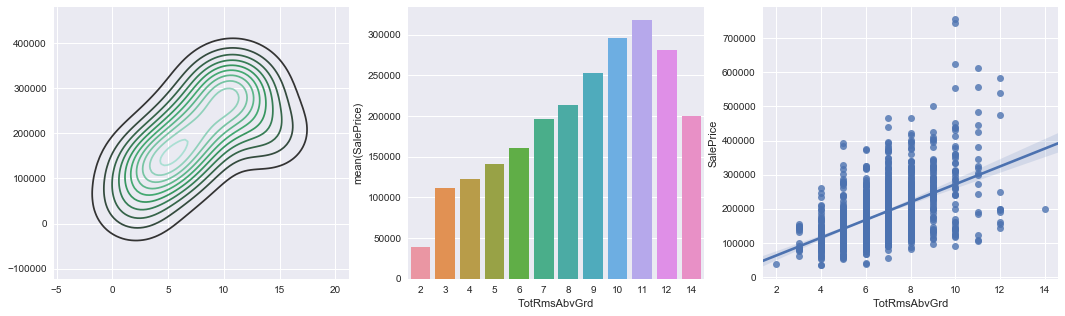

In [317]:
multiple_graphs('TotRmsAbvGrd')

In [318]:
train_test_count('TotRmsAbvGrd')

TotRmsAbvGrd  train_count  test_count
0              2          1.0         NaN
1              3         17.0         8.0
2              4         97.0        99.0
3              5        275.0       308.0
4              6        402.0       442.0
5              7        329.0       320.0
6              8        187.0       160.0
7              9         75.0        68.0
8             10         47.0        33.0
9             11         18.0        14.0
10            12         11.0         5.0
11            14          1.0         NaN
12            13          NaN         1.0
13            15          NaN         1.0

In [319]:
train_df.TotRmsAbvGrd.replace(2,3,inplace=True)
test_df.TotRmsAbvGrd.replace(2,3,inplace=True)
train_df.TotRmsAbvGrd.replace([12,14],11,inplace=True)
test_df.TotRmsAbvGrd.replace([12,13,15],11,inplace=True)
train_test_count('TotRmsAbvGrd')

TotRmsAbvGrd  train_count  test_count
0             3           18           8
1             4           97          99
2             5          275         308
3             6          402         442
4             7          329         320
5             8          187         160
6             9           75          68
7            10           47          33
8            11           30          21

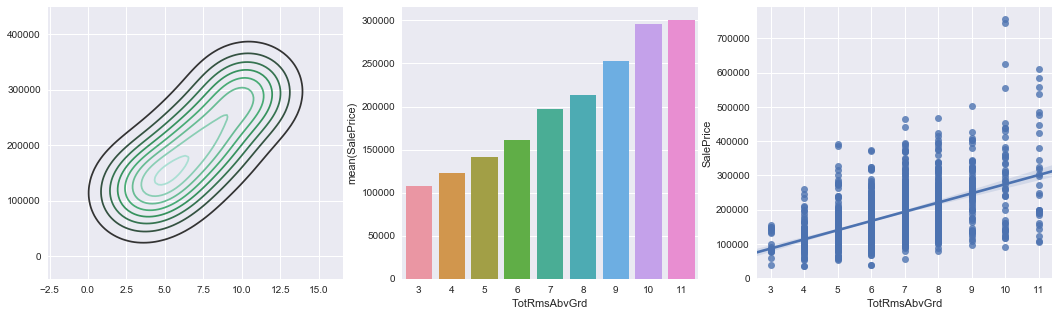

In [320]:
multiple_graphs('TotRmsAbvGrd')

In [321]:
fs_map('TotRmsAbvGrd')

In [322]:
next(next_cat)

'Functional'

In [323]:
nullcol()

columns  NaN of train_df  NaN of test_df
0    GarageType             81.0              76
1   GarageYrBlt             81.0              78
2  GarageFinish             81.0              78
3    GarageQual             81.0              78
4    GarageCond             81.0              78
5    Functional              NaN               2
6    GarageCars              NaN               1
7    GarageArea              NaN               1
8      SaleType              NaN               1

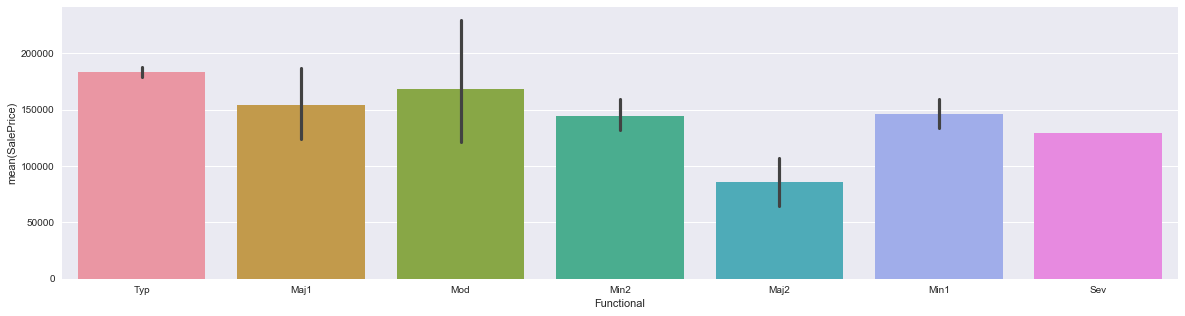

In [324]:
#Functional
bargraph('Functional')

In [325]:
train_test_count('Functional')

Functional  train_count  test_count
0       Maj1           14           5
1       Maj2            5           4
2       Min1           31          34
3       Min2           34          36
4        Mod           15          20
5        Sev            1           1
6        Typ         1360        1357

In [326]:
A = train_df[['Functional','SalePrice']][train_df.Functional != 'Typ']
A_mean_val = A.sum()[1] / A.size
B = train_df[['Functional','SalePrice']][train_df.Functional == 'Typ']
B_mean_val = B.sum()[1] / B.size

print(A_mean_val,B_mean_val)

73406.53 91714.5735294


/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


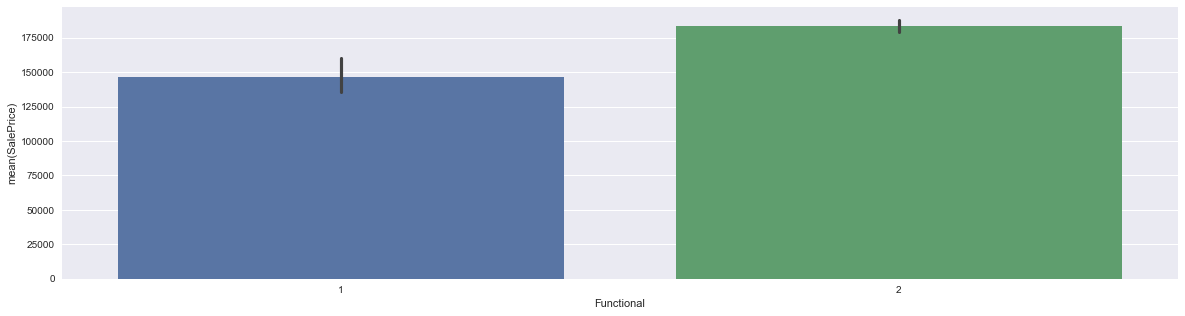

In [327]:
train_df.Functional.replace(['Maj1', 'Maj2', 'Min1', 'Min2', 'Mod', 'Sev'],'Others', inplace=True)
test_df.Functional.replace(['Maj1', 'Maj2', 'Min1', 'Min2', 'Mod', 'Sev'],'Others', inplace=True)
test_df.Functional[pd.isnull] = 'Typ'
fs_map('Functional')
bargraph('Functional')

In [328]:
A=datastructure(train_df)
# A[1]
# A[0][(A[1]!= 'int64') | (A[1]!= 'float64')| (A[1]!= 'category')]
A[(A[1]!= 'int64') & (A[1]!= 'float64') & (A[1]!= 'category')]

0       1
15    Exterior1st  object
16    Exterior2nd  object
44     GarageType  object
46   GarageFinish  object
49     GarageQual  object
50     GarageCond  object
51     PavedDrive  object
61       SaleType  object
62  SaleCondition  object

In [329]:
A = datastructure(test_df)
A[(A[1]!= 'int64') & (A[1]!= 'float64') & (A[1]!= 'category')]

0       1
15    Exterior1st  object
16    Exterior2nd  object
44     GarageType  object
46   GarageFinish  object
49     GarageQual  object
50     GarageCond  object
51     PavedDrive  object
61       SaleType  object
62  SaleCondition  object

In [330]:
nullcol()

columns  NaN of train_df  NaN of test_df
0    GarageType             81.0              76
1   GarageYrBlt             81.0              78
2  GarageFinish             81.0              78
3    GarageQual             81.0              78
4    GarageCond             81.0              78
5    GarageCars              NaN               1
6    GarageArea              NaN               1
7      SaleType              NaN               1

In [331]:
next(next_cat)

'Fireplaces'

In [332]:
#Fireplaces
train_test_count('Fireplaces')

Fireplaces  train_count  test_count
0           0        690.0         730
1           1        650.0         618
2           2        115.0         104
3           3          5.0           6
4           4          NaN           1

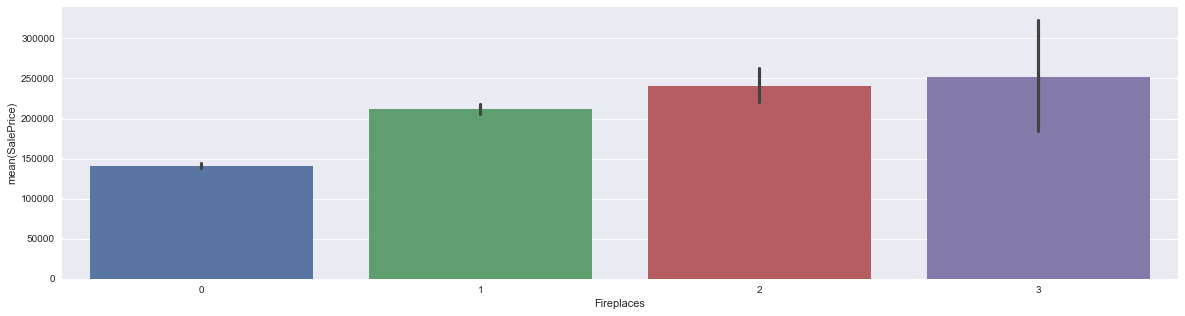

In [333]:
bargraph('Fireplaces')

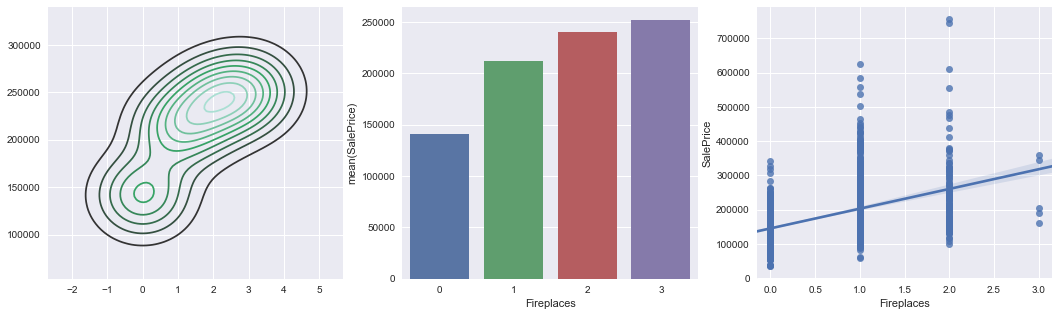

In [334]:
multiple_graphs('Fireplaces')

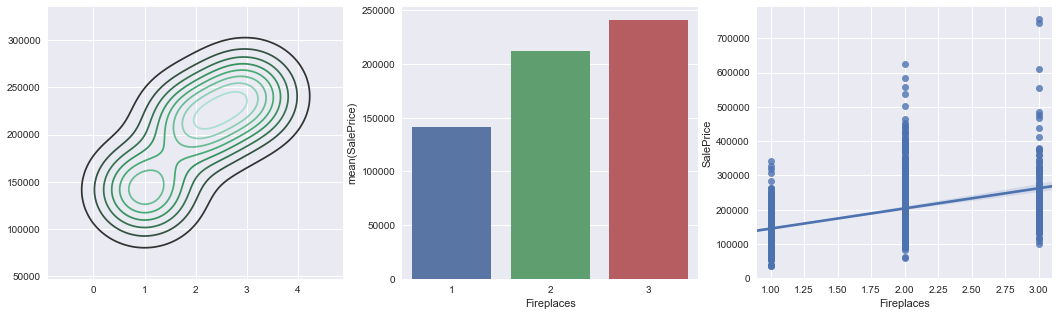

In [335]:
train_df.Fireplaces.replace([3,4],2,inplace=True)
test_df.Fireplaces.replace([3,4],2,inplace=True)
fs_map('Fireplaces')
multiple_graphs('Fireplaces')

In [336]:
next(next_cat)

'FireplaceQu'

In [337]:
next(next_cat)

'GarageType'

In [338]:
#GarageType
train_test_count('GarageType')

GarageType  train_count  test_count
0     2Types            6          17
1     Attchd          870         853
2    Basment           19          17
3    BuiltIn           88          98
4    CarPort            9           6
5     Detchd          387         392

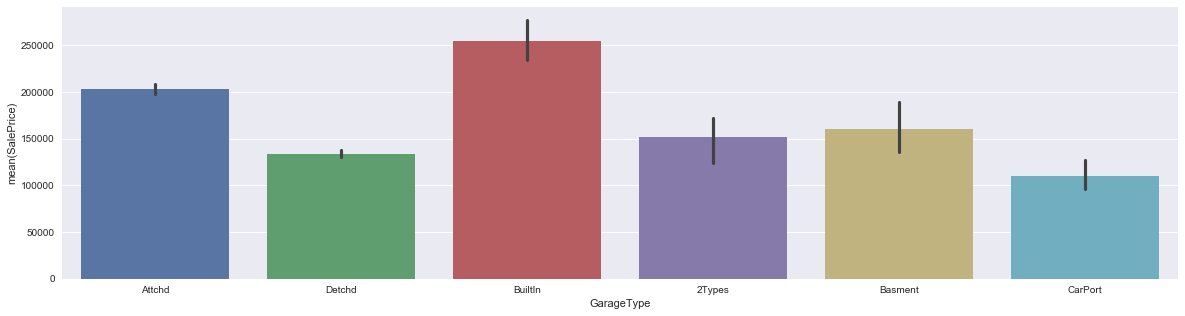

In [339]:
bargraph('GarageType')

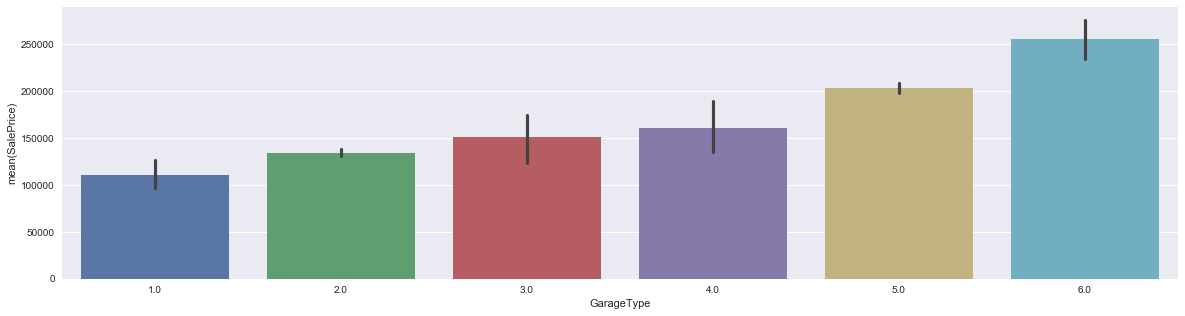

In [340]:
fs_map('GarageType')
bargraph('GarageType')

In [341]:
train_df = fill_na(train_df, 'GarageType')
test_df = fill_na(test_df, 'GarageType')
train_test_count('GarageType')

/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


GarageType  train_count  test_count
0         1.0            9           6
1         2.0          428         425
2         3.0           46          60
3         4.0           19          17
4         5.0          870         853
5         6.0           88          98

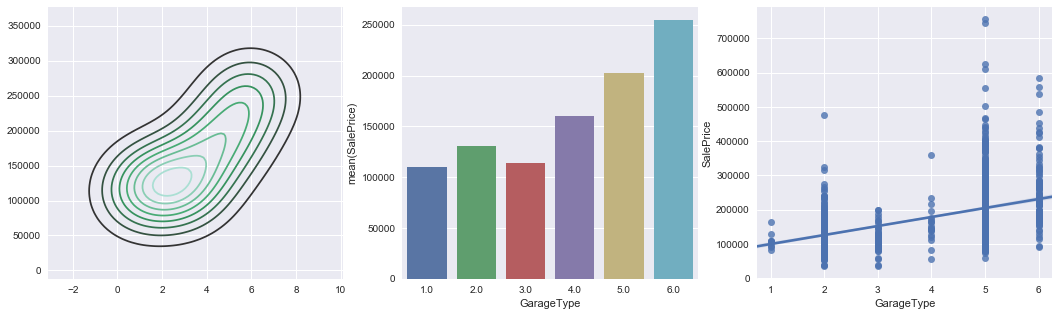

In [342]:
multiple_graphs('GarageType')

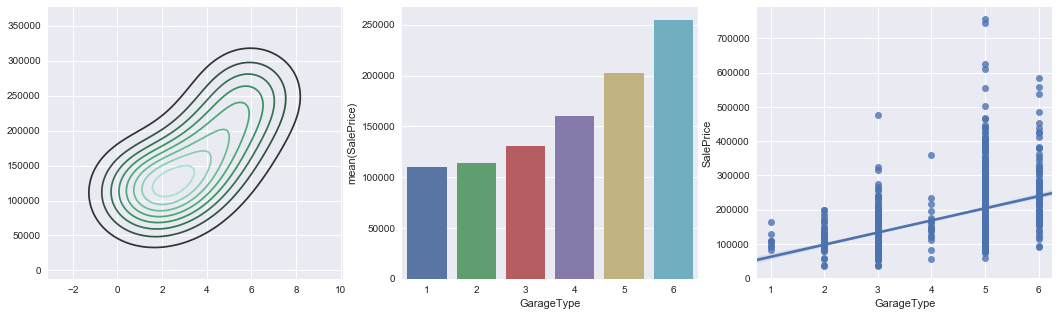

In [343]:
fs_map('GarageType')
multiple_graphs('GarageType')

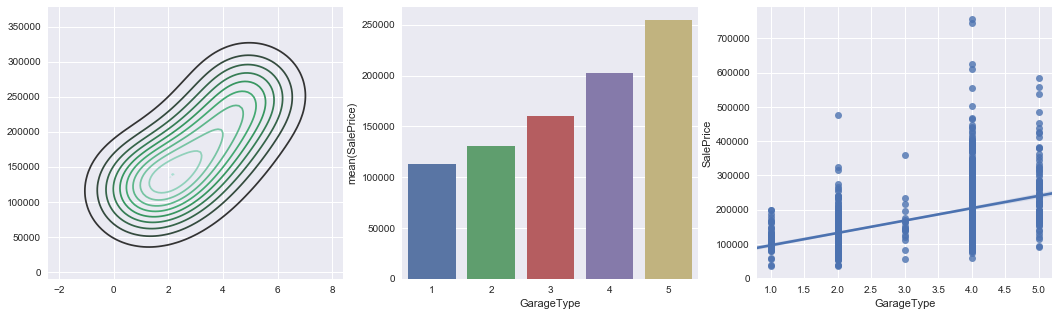

In [344]:
train_df.GarageType.replace(1,2,inplace=True)
test_df.GarageType.replace(1,2,inplace=True)
fs_map('GarageType')
multiple_graphs('GarageType')

In [345]:
next(next_cat)

'GarageYrBlt'

In [346]:
train_test_count('GarageYrBlt').sum()

GarageYrBlt    201992.0
train_count      1379.0
test_count       1381.0
dtype: float64

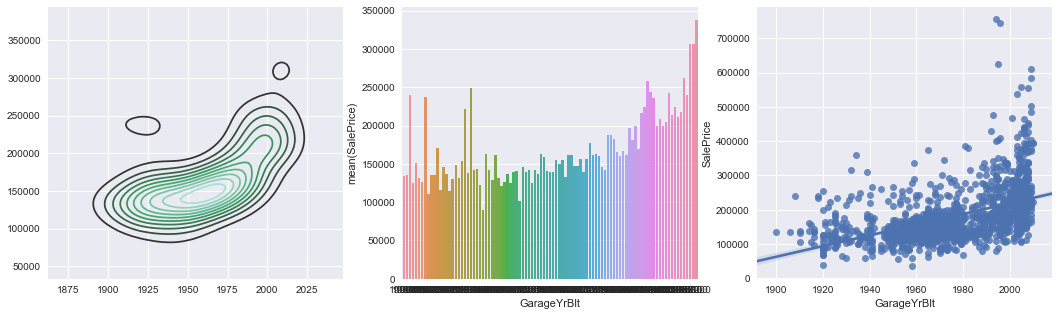

In [347]:
multiple_graphs('GarageYrBlt')

In [348]:
train_df = fill_na(train_df, 'GarageYrBlt')
test_df = fill_na(test_df, 'GarageYrBlt')
train_test_count('GarageYrBlt').sum()

/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


GarageYrBlt    201992.0
train_count      1460.0
test_count       1459.0
dtype: float64

The bins are [1894.0, 1918.333, 1936.667, 1955.0, 1973.333, 1991.667, 2207.0]


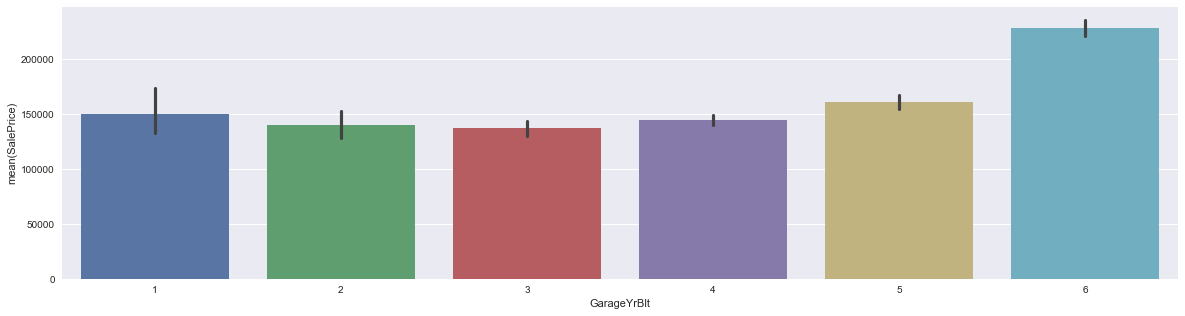

In [349]:
train_df, test_df = binning('GarageYrBlt', 6)
bargraph('GarageYrBlt')

In [350]:
train_test_count('GarageYrBlt')

GarageYrBlt  train_count  test_count
0            1           17          23
1            2           78          82
2            3          148         171
3            4          353         334
4            5          271         249
5            6          593         600

In [351]:
train_df.GarageYrBlt.replace([1,2,3],4, inplace=True)
test_df.GarageYrBlt.replace([1,2,3],4, inplace=True)
fs_map('GarageYrBlt')
train_test_count('GarageYrBlt')

GarageYrBlt  train_count  test_count
0            1          596         610
1            2          271         249
2            3          593         600

In [352]:
# multiple_graphs('GarageYerBlt')
train_test_count('GarageYrBlt').sum()

GarageYrBlt       6
train_count    1460
test_count     1459
dtype: int64

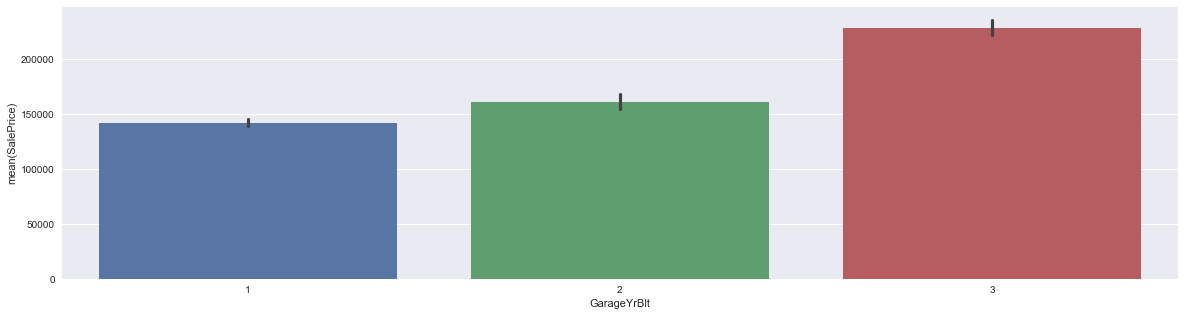

In [353]:
bargraph('GarageYrBlt')

In [354]:
next(next_cat)

'GarageFinish'

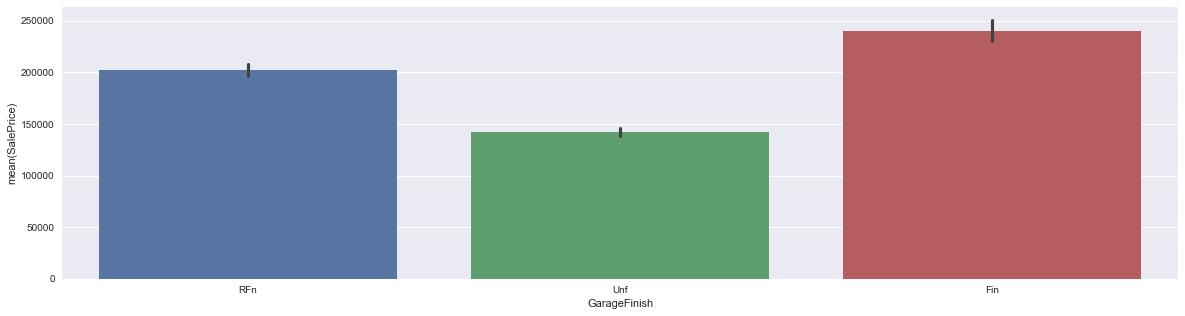

In [355]:
#'GarageFinish'
bargraph('GarageFinish')

In [356]:
train_test_count('GarageFinish').sum()

GarageFinish    FinRFnUnf
train_count          1379
test_count           1381
dtype: object

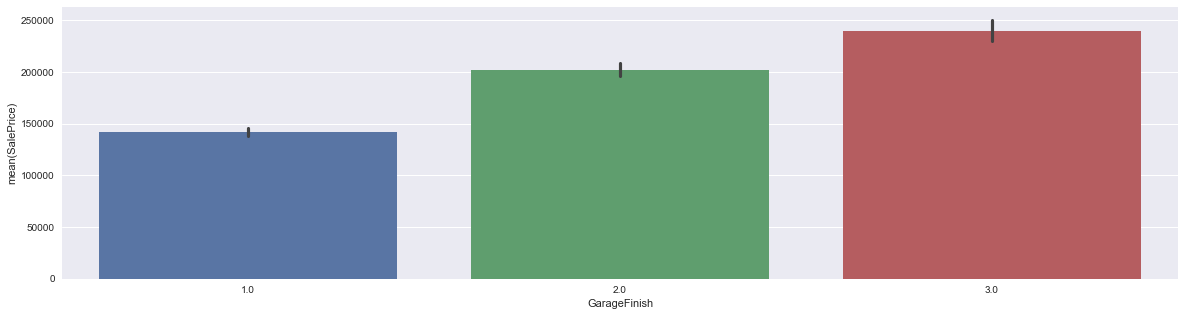

In [357]:
fs_map('GarageFinish')
bargraph('GarageFinish')

In [358]:
train_test_count('GarageFinish').sum()

GarageFinish       6.0
train_count     1379.0
test_count      1381.0
dtype: float64

In [359]:
test_df.GarageFinish[test_df.GarageFinish.isnull()].size

78

/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


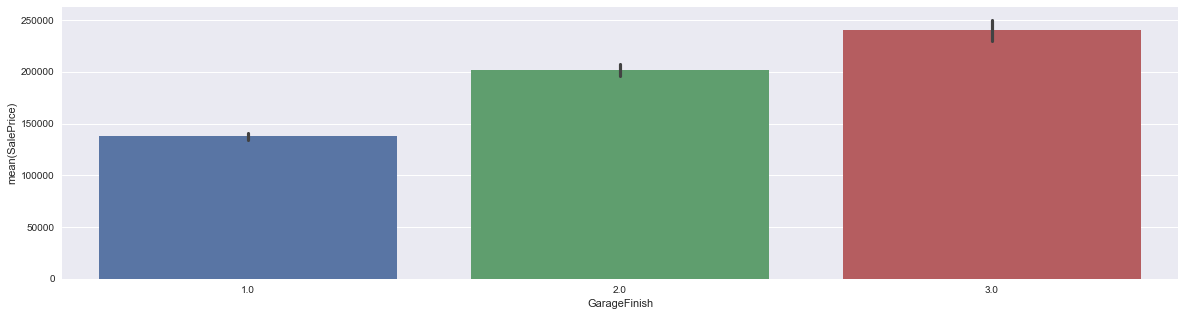

In [360]:
train_df = fill_na(train_df, 'GarageFinish')
test_df = fill_na(test_df, 'GarageFinish')
bargraph('GarageFinish')

In [361]:
train_test_count('GarageFinish')

GarageFinish  train_count  test_count
0           1.0        686.0         625
1           2.0        422.0         389
2           3.0        352.0         367
3           0.0          NaN          78

In [362]:
nullcol()

columns  NaN of train_df  NaN of test_df
0  GarageQual             81.0              78
1  GarageCond             81.0              78
2  GarageCars              NaN               1
3  GarageArea              NaN               1
4    SaleType              NaN               1

In [363]:
next(next_cat)

'GarageCars'

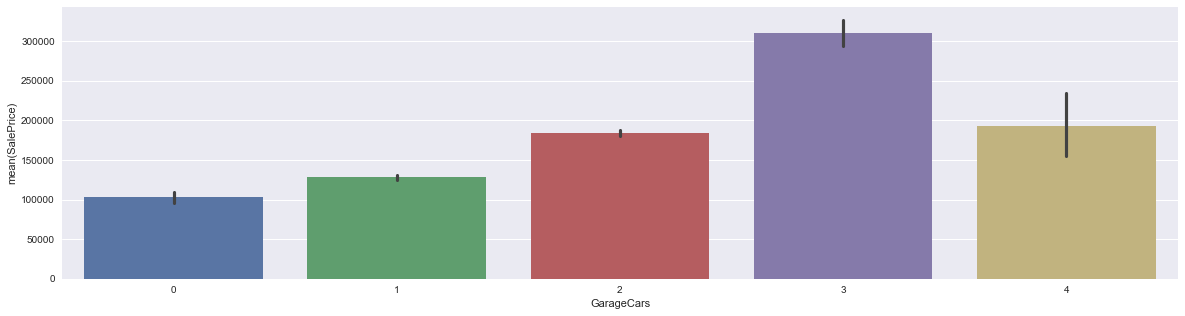

In [364]:
#GarageCars

bargraph('GarageCars')

In [365]:
train_test_count('GarageCars').sum()

GarageCars       15.0
train_count    1460.0
test_count     1458.0
dtype: float64

In [366]:
train_test_count('GarageCars')

GarageCars  train_count  test_count
0           0         81.0          76
1           1        369.0         407
2           2        824.0         770
3           3        181.0         193
4           4          5.0          11
5           5          NaN           1

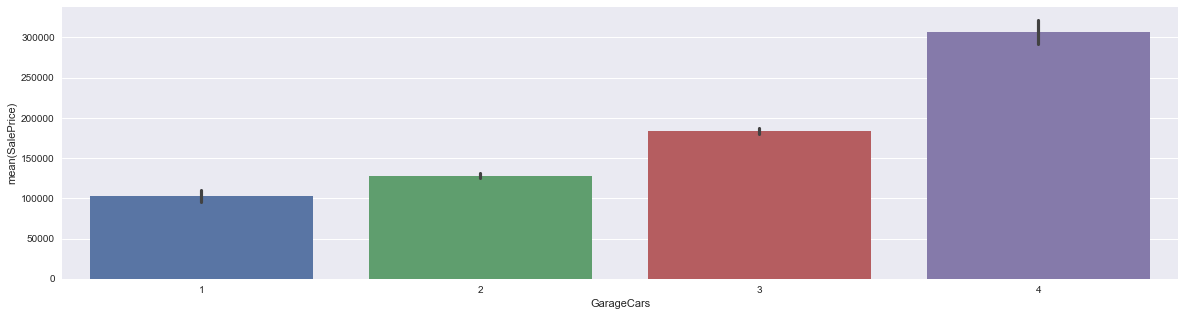

In [367]:
train_df.GarageCars.replace([4,5],3,inplace=True)
test_df.GarageCars.replace([4,5],3,inplace=True)
fs_map('GarageCars')
bargraph('GarageCars')

In [368]:
train_test_count('GarageCars')

GarageCars  train_count  test_count
0           1           81          76
1           2          369         407
2           3          824         770
3           4          186         205

In [369]:
test_df.GarageCars[pd.isnull] = 3

/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [370]:
next(next_cat)

'GarageArea'

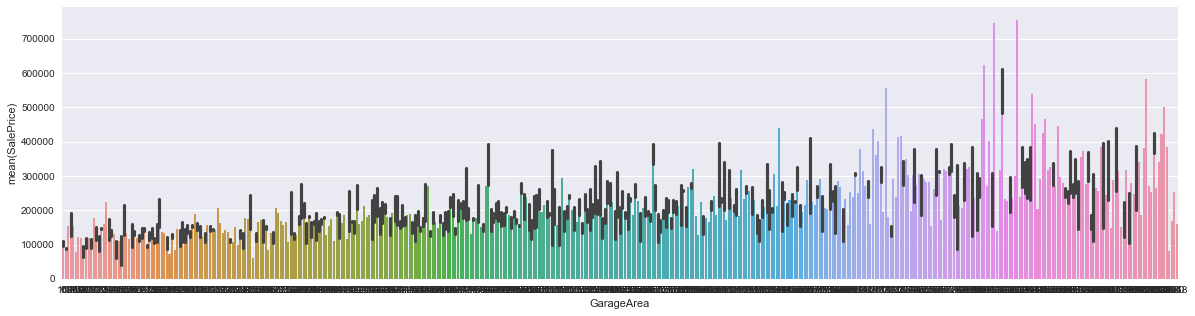

In [371]:
#GarageArea: Size of garage in square feet
bargraph('GarageArea')

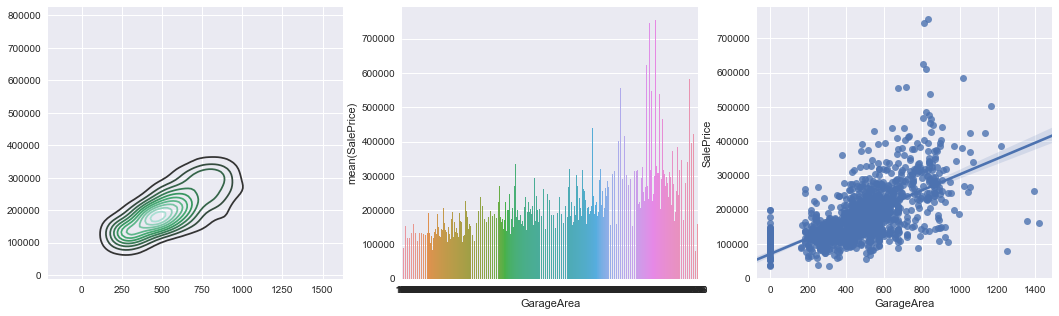

In [372]:
multiple_graphs('GarageArea')

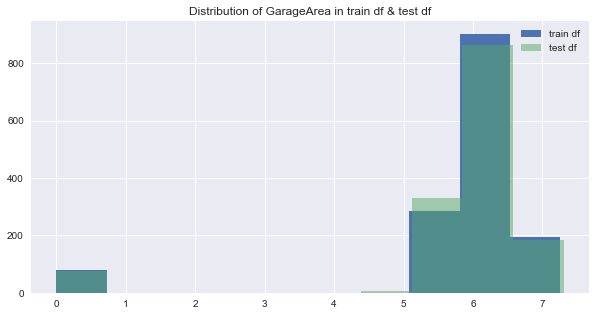

In [373]:
train_df.GarageArea = np.log(train_df.GarageArea + 1)
test_df.GarageArea = np.log(test_df.GarageArea + 1)
train_test_hist('GarageArea')

In [374]:
test_df.GarageArea.fillna(2, inplace=True)

In [375]:
train_test_count('GarageArea')
# multiple_graphs('GarageArea')

GarageArea  train_count  test_count
0      0.000000         81.0        76.0
1      5.081404          2.0         1.0
2      5.105945          1.0         1.0
3      5.198497          9.0         7.0
4      5.231109          1.0         NaN
5      5.247024          1.0         NaN
6      5.262690          1.0         NaN
7      5.293305          1.0         NaN
8      5.303305          4.0         7.0
9      5.327876          3.0         1.0
10     5.342334          1.0         NaN
11     5.351858          3.0         1.0
12     5.365976          1.0         NaN
13     5.379897         12.0        11.0
14     5.398163          3.0         1.0
15     5.420535          2.0         3.0
16     5.433722          1.0         2.0
17     5.442418          1.0         2.0
18     5.459586          2.0         1.0
19     5.484797         38.0        31.0
20     5.501258          1.0         NaN
21     5.509388          2.0         2.0
22     5.517453          1.0         NaN
23     5.525453          3.0         3.0
24     5.533389          5.0         6.0
25     5.541264          1.0         NaN
26     5.545177          1.0         NaN
27     5.549076          2.0         4.0
28     5.564520          3.0         2.0
29     5.568345          1.0         NaN
..          ...          ...         ...
574    6.838405          NaN         3.0
575    6.839476          NaN         1.0
576    6.844815          NaN         2.0
577    6.851185          NaN         2.0
578    6.856462          NaN         1.0
579    6.865891          NaN         1.0
580    6.866933          NaN         1.0
581    6.870053          NaN         1.0
582    6.871091          NaN         1.0
583    6.880384          NaN         1.0
584    6.892642          NaN         1.0
585    6.911747          NaN         1.0
586    6.916715          NaN         1.0
587    6.925595          NaN         1.0
588    6.947937          NaN         1.0
589    6.948897          NaN         1.0
590    6.990257          NaN         1.0
591    6.996681          NaN         1.0
592    7.008505          NaN         1.0
593    7.013016          NaN         1.0
594    7.037906          NaN         1.0
595    7.048386          NaN         1.0
596    7.051856          NaN         1.0
597    7.069023          NaN         1.0
598    7.077498          NaN         1.0
599    7.090910          NaN         1.0
600    7.116394          NaN         1.0
601    7.181592          NaN         1.0
602    7.207119          NaN         1.0
603    7.305860          NaN         1.0

[604 rows x 3 columns]

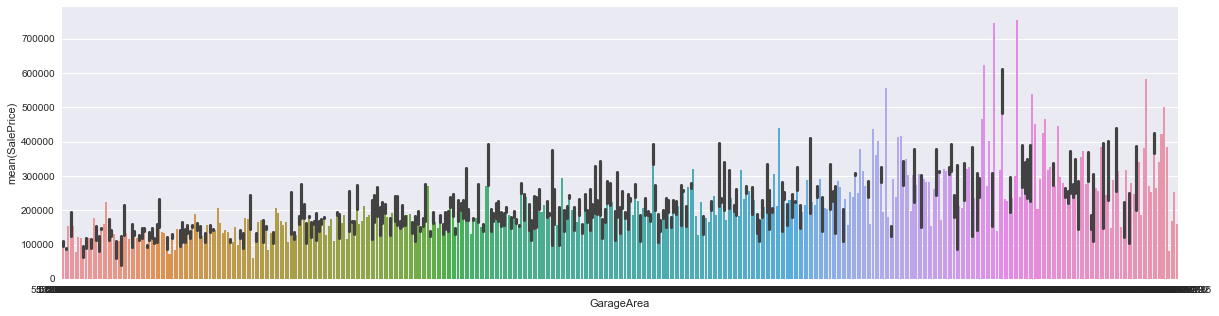

In [376]:
bargraph('GarageArea')

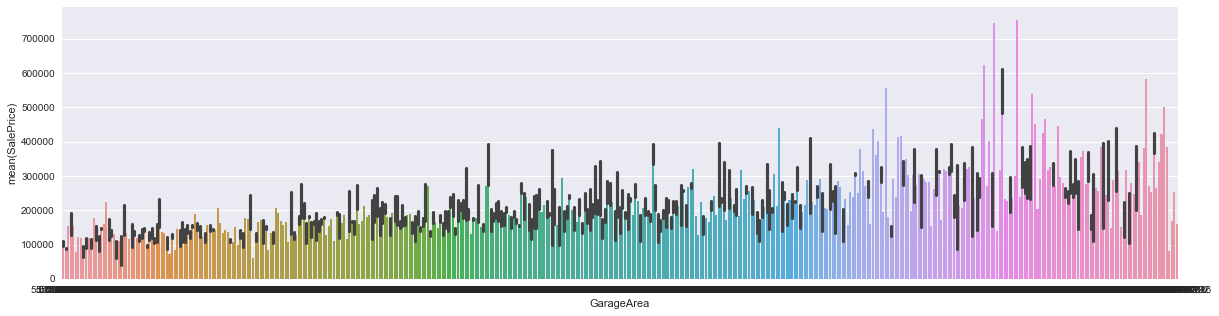

In [377]:
train_df.GarageArea.replace([6,5],4,inplace=True)
test_df.GarageArea.replace([6,5],4,inplace=True)
bargraph('GarageArea')

In [378]:
next(next_cat)

'GarageQual'

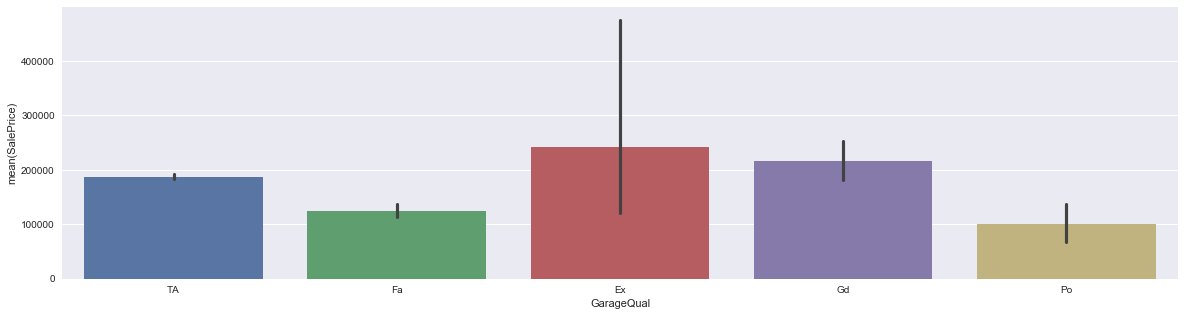

In [379]:
#GarageQual: Garage quality

bargraph('GarageQual')

In [380]:
train_test_count('GarageQual')

GarageQual  train_count  test_count
0         Ex            3         NaN
1         Fa           48        76.0
2         Gd           14        10.0
3         Po            3         2.0
4         TA         1311      1293.0

/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


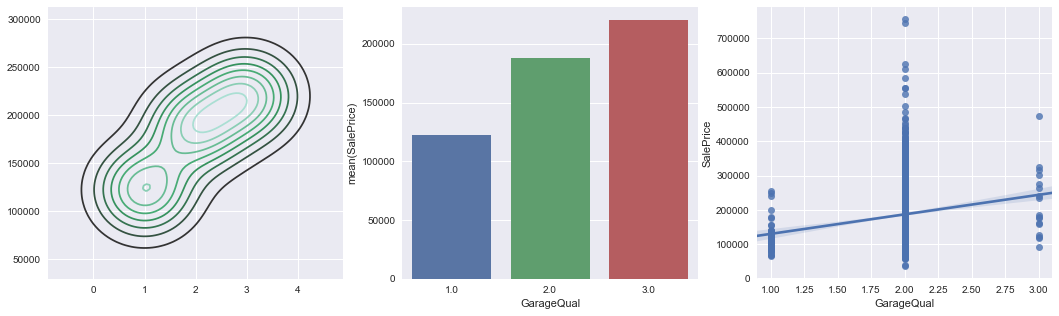

In [381]:
train_df.GarageQual.replace(['Ex','Gd'],3,inplace=True)
train_df.GarageQual.replace('TA',2,inplace=True)
train_df.GarageQual.replace(['Fa','Po'],1,inplace=True)

test_df.GarageQual.replace(['Ex','Gd'],3,inplace=True)
test_df.GarageQual.replace('TA',2,inplace=True)
test_df.GarageQual.replace(['Fa','Po'],1,inplace=True)
test_df.GarageQual[pd.isnull] = 2

multiple_graphs('GarageQual')

In [382]:
train_df = fill_na(train_df, 'GarageQual')

/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [383]:
next(next_cat)

'GarageCond'

In [384]:
nullcol()

columns  NaN of train_df  NaN of test_df
0  GarageCond             81.0              78
1    SaleType              NaN               1

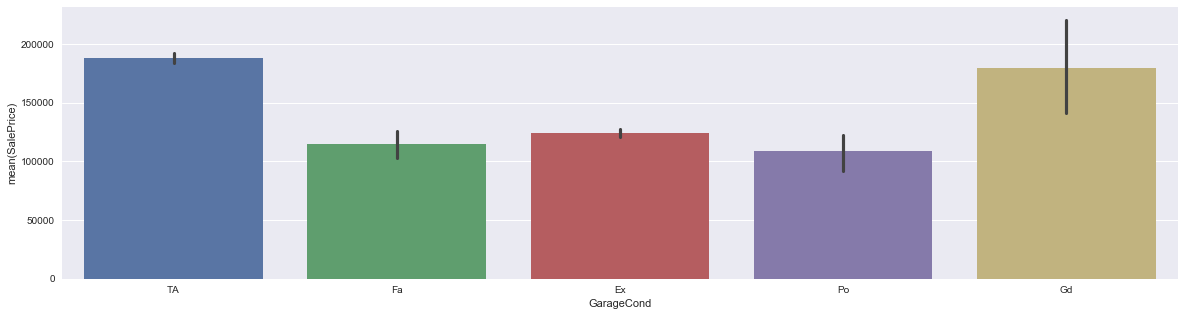

In [385]:
#GarageCond: Garage condition

bargraph('GarageCond')

In [386]:
train_test_count('GarageCond')

GarageCond  train_count  test_count
0         Ex            2           1
1         Fa           35          39
2         Gd            9           6
3         Po            7           7
4         TA         1326        1328

/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel/__main__.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


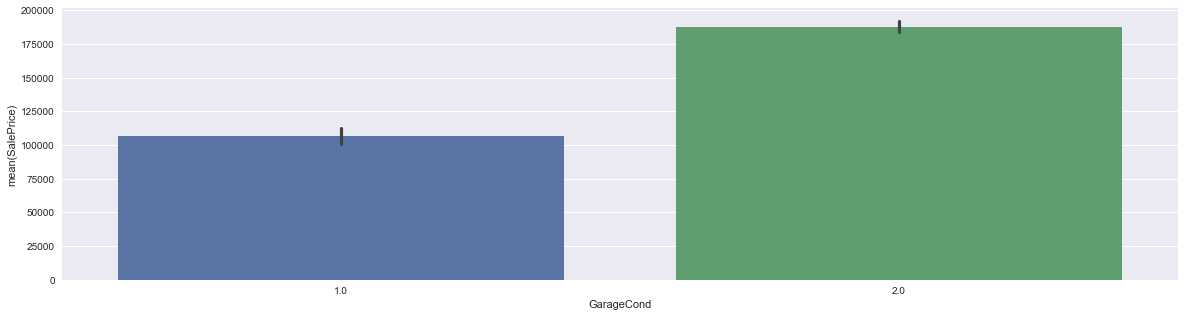

In [387]:
train_df.GarageCond.replace(['Ex','TA','Gd'],2,inplace=True)
test_df.GarageCond.replace(['Ex','TA','Gd'],2,inplace=True)

train_df.GarageCond.replace(['Fa','Po'],1,inplace=True)
test_df.GarageCond.replace(['Fa','Po'],1,inplace=True)

train_df = fill_na(train_df, 'GarageCond')
test_df = fill_na(test_df, 'GarageCond')
bargraph('GarageCond')

In [388]:
train_test_count('GarageCond')

GarageCond  train_count  test_count
0         1.0          123         124
1         2.0         1337        1335

In [389]:
next(next_cat)

'PavedDrive'

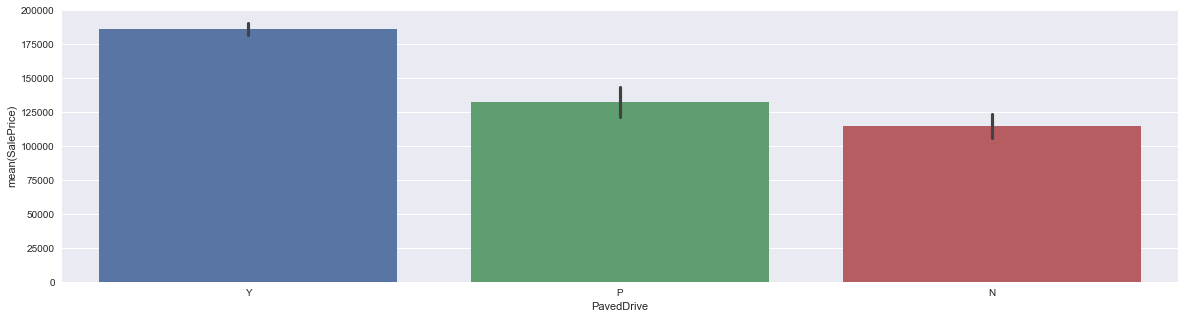

In [390]:
#PavedDrive: Paved driveway

bargraph('PavedDrive')

In [391]:
train_test_count('PavedDrive')

PavedDrive  train_count  test_count
0          N           90         126
1          P           30          32
2          Y         1340        1301

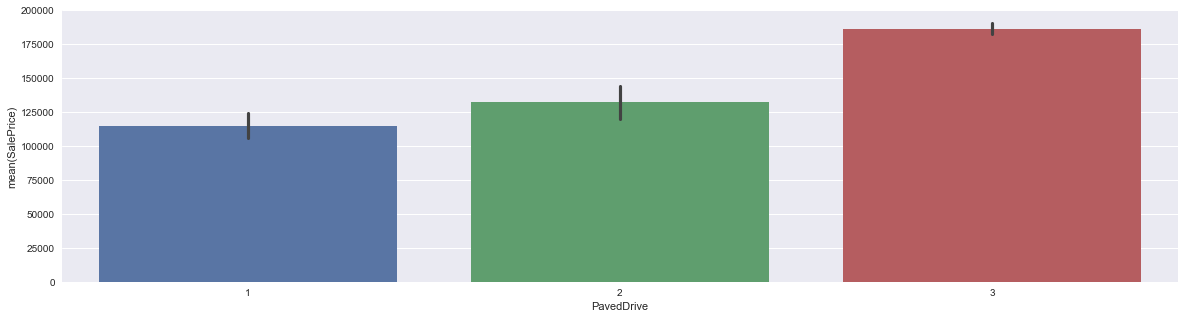

In [392]:
fs_map('PavedDrive')
bargraph('PavedDrive')

In [393]:
nullcol()

NaN of train_df   columns  NaN of test_df
0             NaN  SaleType               1

In [394]:
next(next_cat)

'WoodDeckSF'

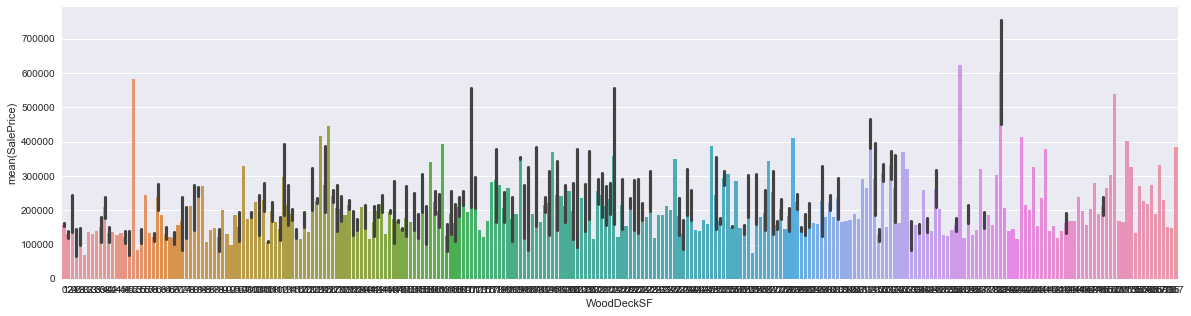

In [395]:
#WoodDeckSF: Wood deck area in square feet

bargraph('WoodDeckSF')

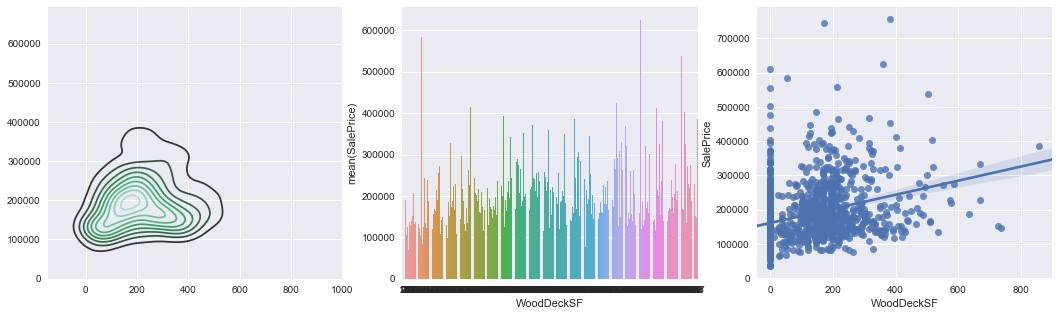

In [396]:
multiple_graphs('WoodDeckSF')

In [397]:
#Not using it
train_df.drop('WoodDeckSF',1,inplace=True)
test_df.drop('WoodDeckSF',1,inplace=True)

In [398]:
next(next_cat)

'OpenPorchSF'

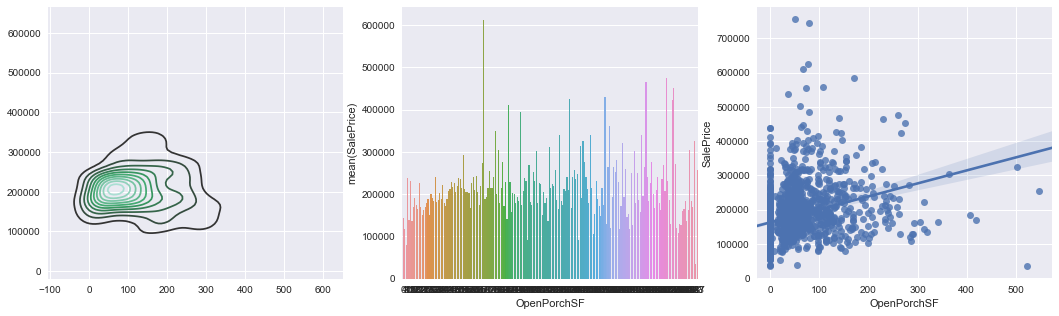

In [399]:
#OpenPorchSF: Open porch area in square feet

multiple_graphs('OpenPorchSF')

In [400]:
#Not using it
train_df.drop('OpenPorchSF',1,inplace=True)
test_df.drop('OpenPorchSF',1,inplace=True)

In [401]:
next(next_cat)

'EnclosedPorch'

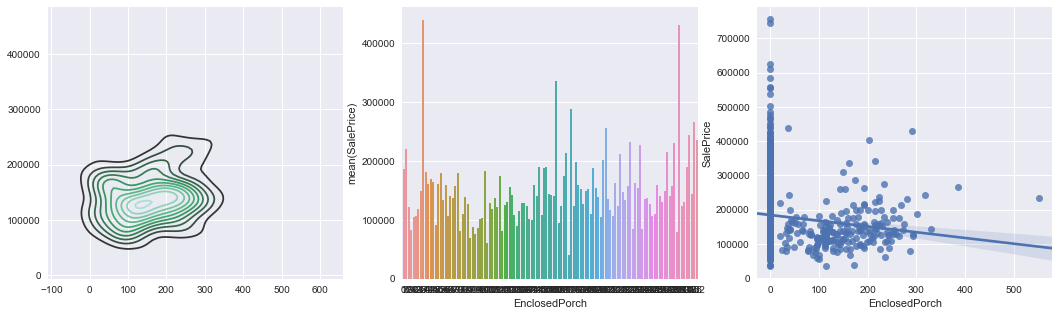

In [402]:
#EnclosedPorch: Enclosed porch area in square feet

multiple_graphs('EnclosedPorch')

In [403]:
#Not using it
train_df.drop('EnclosedPorch',1,inplace=True)
test_df.drop('EnclosedPorch',1,inplace=True)

In [404]:
next(next_cat)

'3SsnPorch'

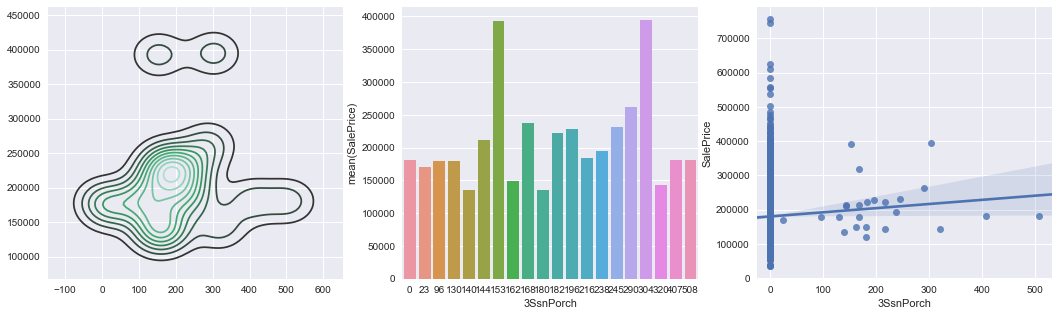

In [405]:
#3SsnPorch: Three season porch area in square feet

multiple_graphs('3SsnPorch')

In [406]:
#Not using it
train_df.drop('3SsnPorch',1,inplace=True)
test_df.drop('3SsnPorch',1,inplace=True)

In [407]:
next(next_cat)

'ScreenPorch'

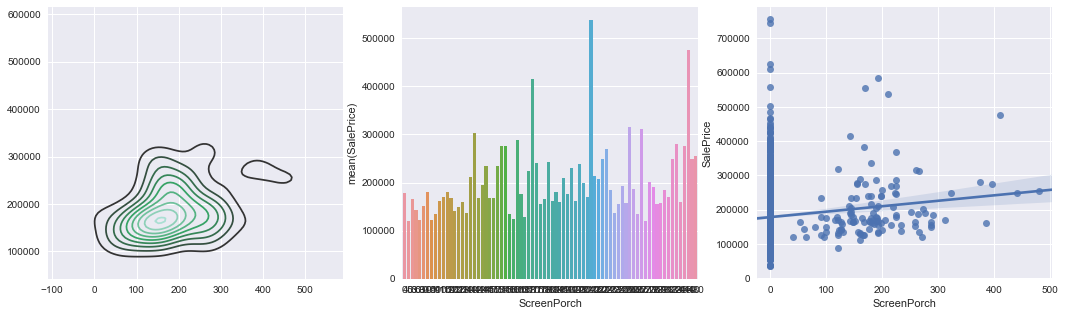

In [408]:
#ScreenPorch: Screen porch area in square feet

multiple_graphs('ScreenPorch')

In [409]:
#Not using it
train_df.drop('ScreenPorch',1,inplace=True)
test_df.drop('ScreenPorch',1,inplace=True)

In [410]:
next(next_cat)

'PoolArea'

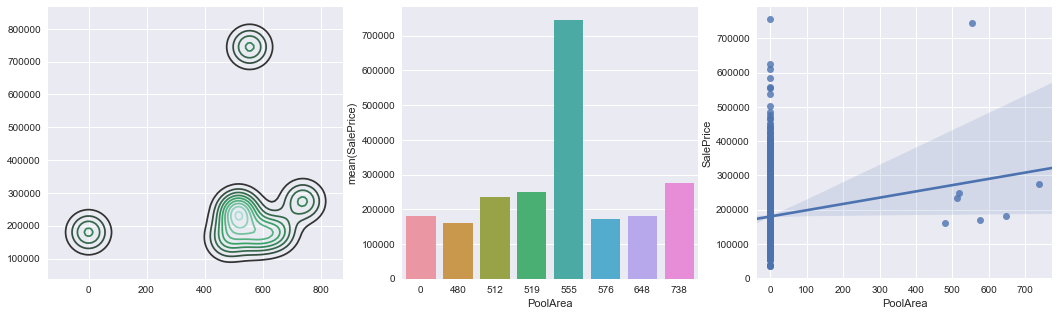

In [411]:
#PoolArea: Pool area in square feet

multiple_graphs('PoolArea')

In [412]:
train_test_count('PoolArea')

PoolArea  train_count  test_count
0          0       1453.0      1453.0
1        480          1.0         NaN
2        512          1.0         NaN
3        519          1.0         NaN
4        555          1.0         NaN
5        576          1.0         NaN
6        648          1.0         NaN
7        738          1.0         NaN
8        144          NaN         1.0
9        228          NaN         1.0
10       368          NaN         1.0
11       444          NaN         1.0
12       561          NaN         1.0
13       800          NaN         1.0

In [413]:
#Not using it
train_df.drop('PoolArea',1,inplace=True)
test_df.drop('PoolArea',1,inplace=True)

In [414]:
next(next_cat)

'PoolQC'

In [415]:
next(next_cat)

'Fence'

In [416]:
next(next_cat)

'MiscFeature'

In [417]:
next(next_cat)

'MiscVal'

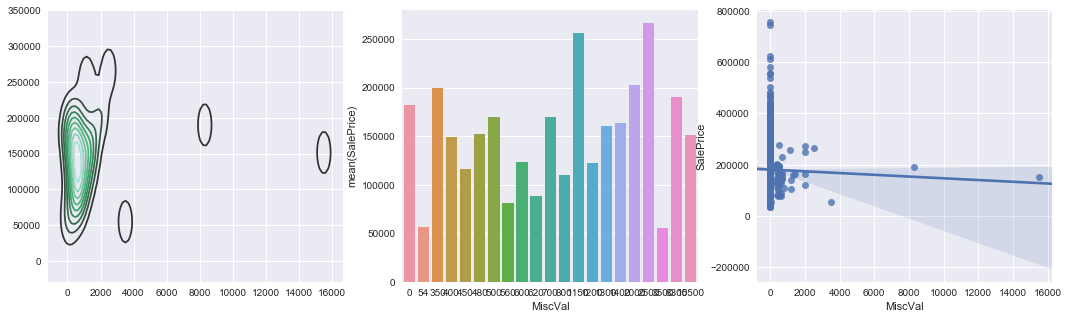

In [418]:
#MiscVal: $Value of miscellaneous feature

multiple_graphs('MiscVal')

In [419]:
train_df.drop('MiscVal',1,inplace=True)
test_df.drop('MiscVal',1,inplace=True)

In [420]:
next(next_cat)

'MoSold'

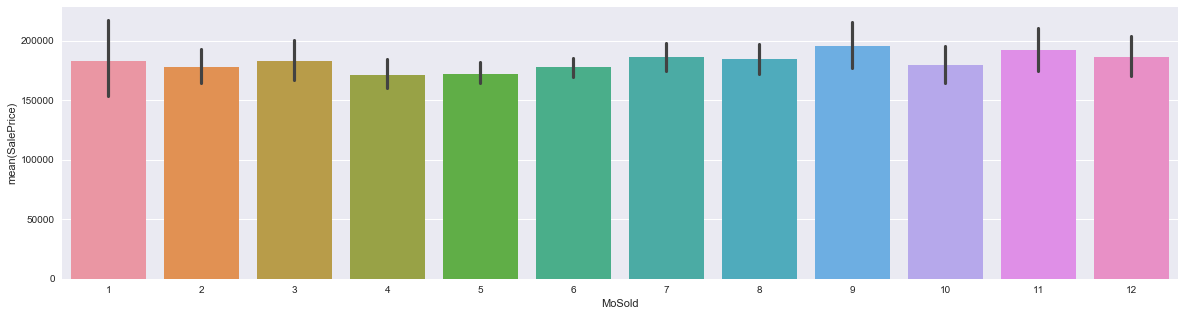

In [421]:
bargraph('MoSold')

In [422]:
train_df.drop('MoSold',1,inplace=True)
test_df.drop('MoSold',1,inplace=True)

In [423]:
next(next_cat)

'YrSold'

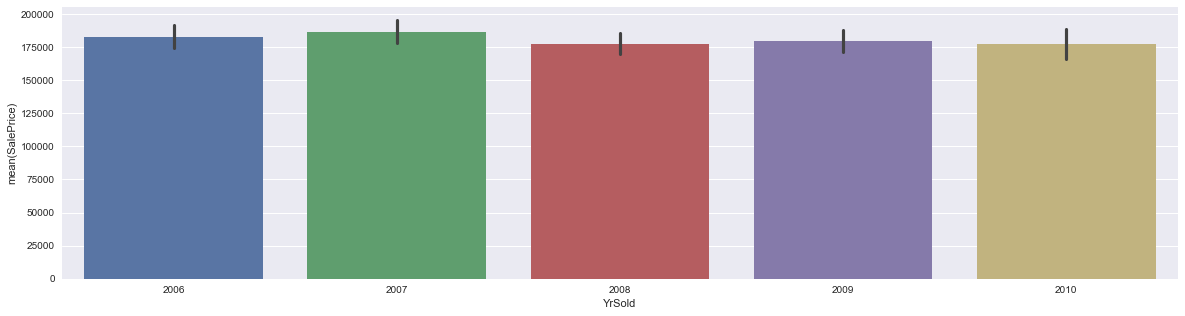

In [424]:
bargraph('YrSold')

In [425]:
train_df.drop('YrSold',1,inplace=True)
test_df.drop('YrSold',1,inplace=True)

In [426]:
next(next_cat)

'SaleType'

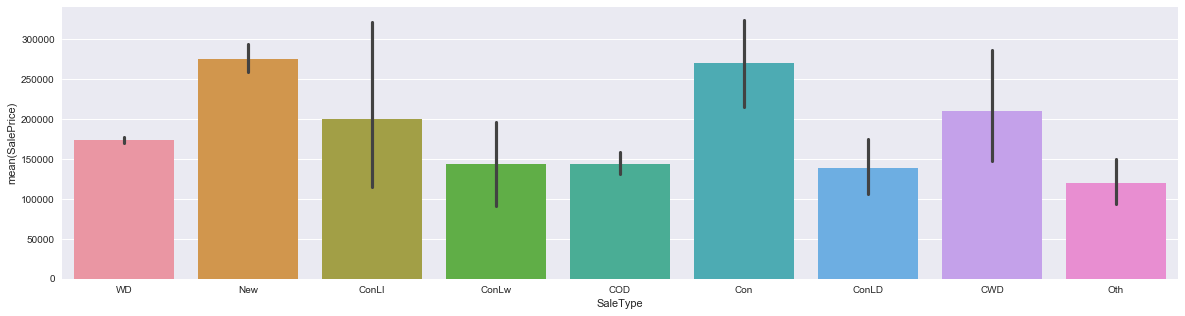

In [427]:
bargraph('SaleType')

In [428]:
train_test_count('SaleType')

SaleType  train_count  test_count
0      COD           43          44
1      CWD            4           8
2      Con            2           3
3    ConLD            9          17
4    ConLI            5           4
5    ConLw            5           3
6      New          122         117
7      Oth            3           4
8       WD         1267        1258

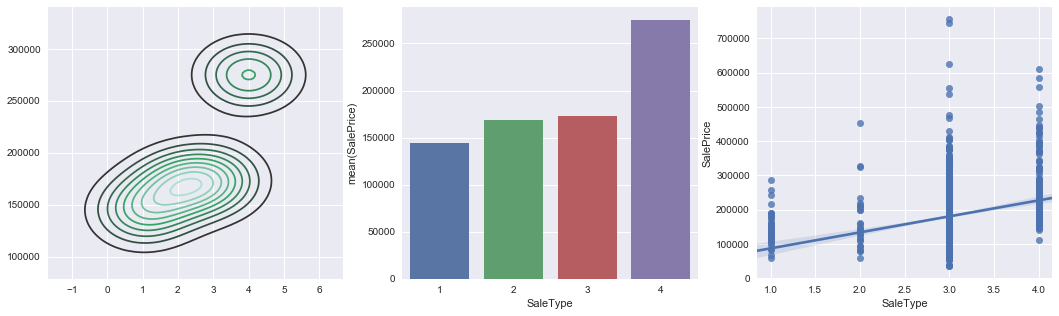

In [429]:
train_df.replace(['ConLI', 'ConLw', 'ConLD', 'Oth', 'CWD','Con'],'others',inplace=True)
test_df.replace(['ConLI', 'ConLw', 'ConLD', 'Oth', 'CWD','Con'],'others',inplace=True)
fs_map('SaleType')
multiple_graphs('SaleType')

In [430]:
next(next_cat)

'SaleCondition'

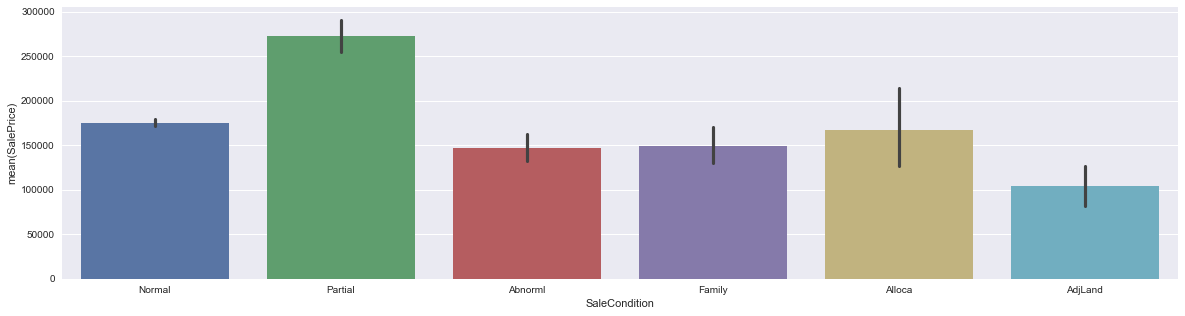

In [431]:
bargraph('SaleCondition')

In [432]:
train_test_count('SaleCondition')

SaleCondition  train_count  test_count
0       Abnorml          101          89
1       AdjLand            4           8
2        Alloca           12          12
3        Family           20          26
4        Normal         1198        1204
5       Partial          125         120

In [433]:
count_price('SaleCondition')

SaleCondition  SalePrice  count
1       AdjLand     104125      4
0       Abnorml     146526    101
3        Family     149600     20
2        Alloca     167377     12
4        Normal     175202   1198
5       Partial     272291    125

In [434]:
fs_map('SaleCondition')

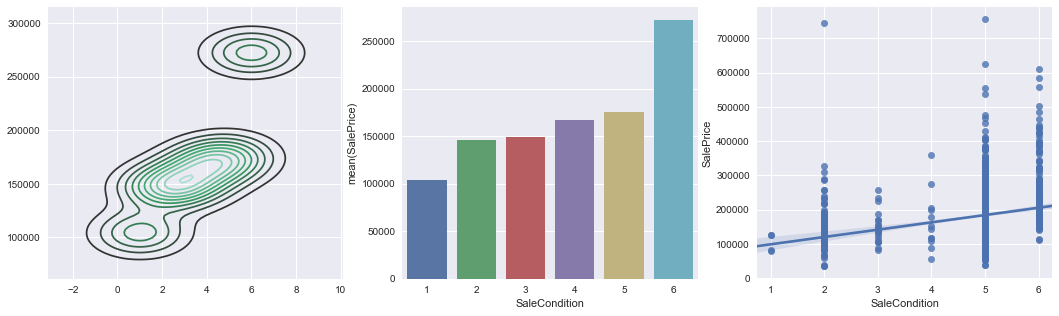

In [435]:
multiple_graphs('SaleCondition')

In [436]:
next(next_cat)

'SalePrice'

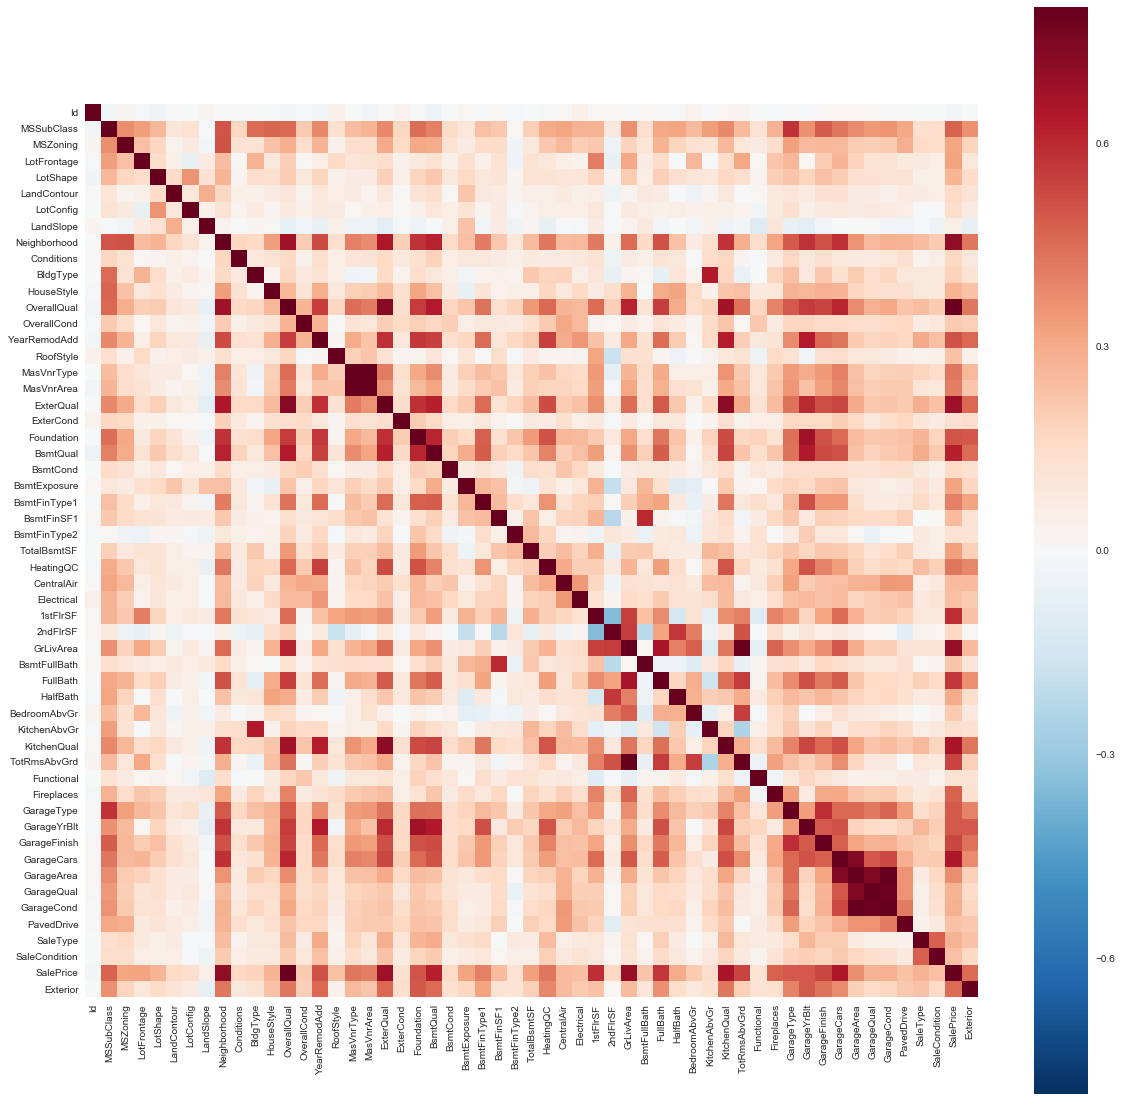

In [437]:
cor = train_df.corr()
f,ax = plt.subplots(1,1,figsize=(20,20))
sns.heatmap(cor, vmax=.8, square=True)

In [438]:
# Check the categories that correlate more than 0.3 to the SalePrice

cor_df = pd.DataFrame(cor['SalePrice'][(cor['SalePrice']>0.3) & (cor.index != 'SalePrice')])
cor_df.sort_values(by = 'SalePrice', ascending = False)

SalePrice
OverallQual    0.790982
Neighborhood   0.709325
GrLivArea      0.695147
ExterQual      0.682639
KitchenQual    0.659600
GarageCars     0.646652
BsmtQual       0.619967
1stFlrSF       0.591299
FullBath       0.570981
TotRmsAbvGrd   0.537651
GarageFinish   0.537242
YearRemodAdd   0.507101
Foundation     0.500710
GarageYrBlt    0.491663
GarageType     0.488904
MSSubClass     0.470571
Fireplaces     0.469543
Exterior       0.450682
HeatingQC      0.427647
MasVnrType     0.426703
MasVnrArea     0.409840
BsmtFinType1   0.400766
GarageArea     0.371597
TotalBsmtSF    0.325883
LotFrontage    0.322023
BsmtExposure   0.318909
MSZoning       0.315377

In [439]:
cor_list = list(cor_df.index)
cor_list

['MSSubClass',
 'MSZoning',
 'LotFrontage',
 'Neighborhood',
 'OverallQual',
 'YearRemodAdd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'Foundation',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinType1',
 'TotalBsmtSF',
 'HeatingQC',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'Exterior']

In [440]:
cor_list_df = pd.DataFrame(train_df[[x for x in cor_list]])

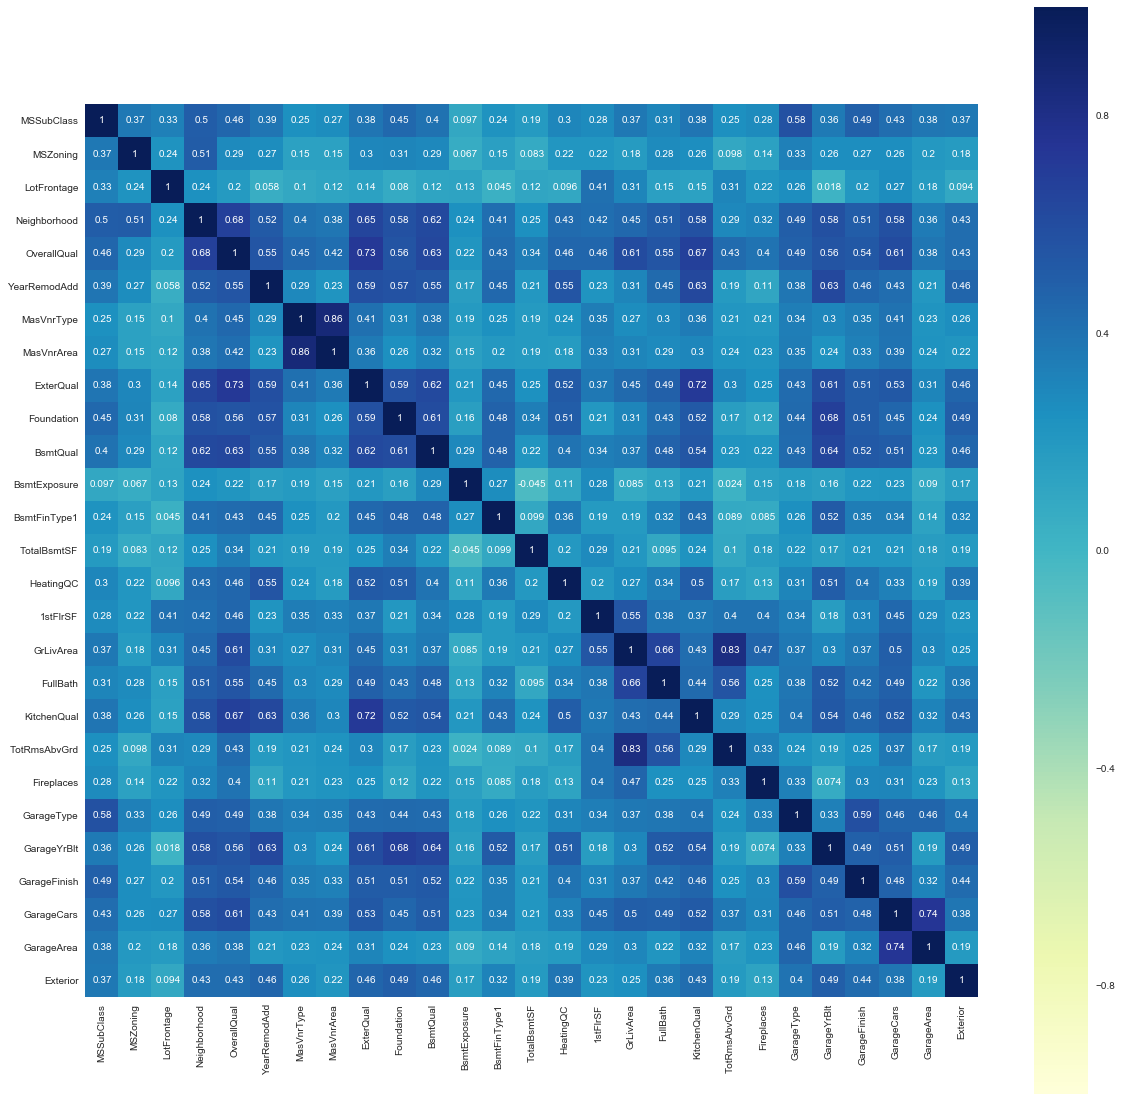

In [441]:
# Correlation among categories
cat_cor = cor_list_df.corr()
f, ax = plt.subplots(1,1,figsize=(20,20))
sns.heatmap(cat_cor, square=True, annot = True,cmap="YlGnBu")

In [442]:
#Calculate correlations between each combination of categories 
cor_comb_list = []
for x in cor_list:
    for y in cor_list:
        if (not [y,x] in cor_comb_list) & (x != y):
            cor_comb_list +=[[x,y]]
cor_dict = {}
for x,y in cor_comb_list:
    cor_dict[x,y] = cat_cor.ix[x,y]

cor_df2 = pd.DataFrame.from_dict(cor_dict, 'index')
cor_df2 = cor_df2.rename(columns = {0:'correlation'})
cor_df2[cor_df2.correlation>0.6].sort_values(by='correlation', ascending = False)

correlation
(MasVnrType, MasVnrArea)        0.864028
(GrLivArea, TotRmsAbvGrd)       0.826796
(GarageCars, GarageArea)        0.735043
(OverallQual, ExterQual)        0.726278
(ExterQual, KitchenQual)        0.716122
(Foundation, GarageYrBlt)       0.681011
(Neighborhood, OverallQual)     0.676748
(OverallQual, KitchenQual)      0.673331
(GrLivArea, FullBath)           0.659210
(Neighborhood, ExterQual)       0.645805
(BsmtQual, GarageYrBlt)         0.643397
(OverallQual, BsmtQual)         0.634917
(YearRemodAdd, GarageYrBlt)     0.631789
(YearRemodAdd, KitchenQual)     0.625316
(ExterQual, BsmtQual)           0.619076
(Neighborhood, BsmtQual)        0.618384
(OverallQual, GrLivArea)        0.614207
(OverallQual, GarageCars)       0.609512
(Foundation, BsmtQual)          0.606754
(ExterQual, GarageYrBlt)        0.605762

In [443]:
cor_list

['MSSubClass',
 'MSZoning',
 'LotFrontage',
 'Neighborhood',
 'OverallQual',
 'YearRemodAdd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'Foundation',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinType1',
 'TotalBsmtSF',
 'HeatingQC',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'Exterior']

## Aggressive feature deletion

In [444]:
# Drop the low-correlated-to-SalePrice ones and the high-among-each-other ones


# test_Id = test_df.Id.copy()
# drop_list = list(pd.DataFrame(cor['SalePrice'][(cor['SalePrice']<=0.5) & (cor.index != 'SalePrice')]).index)
# drop_list += ['TotRmsAbvGrd','GarageArea', 'BsmtQual', 'GarageYrBlt', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'MasVnrArea']
# drop_list = list(set(drop_list))
# train_df.drop(drop_list, 1, inplace=True)
# test_df.drop(drop_list, 1, inplace=True)


## Moderate feature deletion

In [445]:
# test_Id = test_df.Id.copy()
# drop_list = list(pd.DataFrame(cor['SalePrice'][(cor['SalePrice']<=0.35) & (cor.index != 'SalePrice')]).index)
# drop_list += ['TotRmsAbvGrd', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'MasVnrArea']
# drop_list = list(set(drop_list))
# train_df.drop(drop_list, 1, inplace=True)
# test_df.drop(drop_list, 1, inplace=True)

##  Conservative feature deletion 

In [446]:
# Alternatively, delete very conservatively

test_Id = test_df.Id.copy()
drop_list = list(pd.DataFrame(cor['SalePrice'][(cor['SalePrice']<=0.3) & (cor.index != 'SalePrice')]).index)
drop_list += ['Exterior1st', 'Exterior2nd']
drop_list = list(set(drop_list))
train_df.drop(drop_list, 1, inplace=True)
test_df.drop(drop_list, 1, inplace=True)

In [447]:
test_Id = test_Id.astype(int)
test_Id

0       1461
1       1463
2       1464
3       1468
4       1476
5       1477
6       1478
7       1480
8       1481
9       1482
10      1483
11      1484
12      1485
13      1486
14      1487
15      1488
16      1489
17      1490
18      1491
19      1497
20      1500
21      1502
22      1504
23      1505
24      1510
25      1519
26      1535
27      1549
28      1554
29      1558
        ... 
1429    2144
1430    2207
1431    2190
1432    2553
1433    2799
1434    2217
1435    2376
1436    2414
1437    2425
1438    2568
1439    2804
1440    2454
1441    2883
1442    2525
1443    2559
1444    2566
1445    2569
1446    2711
1447    2727
1448    2753
1449    2766
1450    2767
1451    2777
1452    2781
1453    2878
1454    2793
1455    2860
1456    2862
1457    2873
1458    2905
Name: Id, dtype: int64

In [448]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1458
Data columns (total 27 columns):
MSSubClass      1459 non-null float64
MSZoning        1459 non-null float64
LotFrontage     1459 non-null float64
Neighborhood    1459 non-null float64
OverallQual     1459 non-null float64
YearRemodAdd    1459 non-null float64
MasVnrType      1459 non-null int64
MasVnrArea      1459 non-null float64
ExterQual       1459 non-null int64
Foundation      1459 non-null int64
BsmtQual        1459 non-null float64
BsmtExposure    1459 non-null float64
BsmtFinType1    1459 non-null float64
TotalBsmtSF     1459 non-null float64
HeatingQC       1459 non-null int64
1stFlrSF        1459 non-null float64
GrLivArea       1459 non-null float64
FullBath        1459 non-null int64
KitchenQual     1459 non-null int64
TotRmsAbvGrd    1459 non-null int64
Fireplaces      1459 non-null int64
GarageType      1459 non-null int64
GarageYrBlt     1459 non-null int64
GarageFinish    1459 non-null float64
G

In [449]:
X_train, Y_train = train_df.drop('SalePrice',1), train_df.SalePrice

In [450]:
X_train.to_csv('housing_X_train.csv', index=False)
Y_train.to_csv('housing_Y_train.csv', index=False)
test_df.to_csv('housing_X_test.csv', index = False)
test_Id.to_csv('housing_Id_test.csv', index = False)

In [451]:
X_train.head()

MSSubClass  MSZoning  LotFrontage  Neighborhood  OverallQual  YearRemodAdd  \
0          12         3     4.174387            15            7      8.833333   
1          12         3     4.219508            15            7      8.666667   
2          12         3     4.430817            23            8      8.333333   
3           6         3     4.442651            10            5      7.500000   
4          10         3     4.317488            18            8      9.166667   

   MasVnrType  MasVnrArea  ExterQual  Foundation    ...      FullBath  \
0           2    5.283204          3           5    ...             2   
1           2    5.093750          3           5    ...             2   
2           2    5.860786          3           5    ...             2   
3           1    0.000000          2           4    ...             1   
4           3    5.231109          3           5    ...             2   

   KitchenQual  TotRmsAbvGrd  Fireplaces  GarageType  GarageYrBlt  \
0            3             6           1           4            3   
1            3             4           2           4            3   
2            3             7           2           4            3   
3            2             3           1           4            3   
4            3             5           2           4            3   

   GarageFinish  GarageCars  GarageArea   Exterior  
0           2.0           3    6.308098  12.277495  
1           2.0           3    6.411818  12.277495  
2           2.0           4    6.729824  12.277495  
3           1.0           3    6.175867  12.277495  
4           2.0           3    6.456770  12.277495  

[5 rows x 27 columns]

In [452]:
# Machine learning
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [453]:
# validation test & Learning curve

def compute_error(model, x, y):
    yfit = model.predict(x)
    return np.sqrt(np.mean((y - yfit) ** 2))

def valid_test(model, param, param_candidates):
    
    # candidates = np.logspace(-7, 7, 10) # for alpha, C 
    # candidates = [1,2,3,4,5,6,7,8,9,10]# for integers
    train_rmse, valid_rmse = validation_curve(model, X_cv, Y_cv, param, param_candidates, scoring= compute_error)  
    avg_te, avg_ve = train_rmse.mean(axis = 1), valid_rmse.mean(axis = 1)
    sd_te, sd_ve = train_rmse.std(axis = 1), valid_rmse.std(axis = 1)
    ve_min_ix = np.argmin(avg_ve)
    best = param_candidates[ve_min_ix]
    print('The best {} value for {} is {}'.format(param, model, best))
    plt.figure()
    plt.title('Validation Test')
    plt.ylabel('RMSE')
    plt.xlabel('Candidate {} index'.format(param))
    plt.plot(range(10), avg_te, label = 'Training Scores')
    plt.plot(range(10), avg_ve, label = 'Cross validation Scores')
    plt.legend(loc = 'best')
    return best


def Learning_curve(model):
    train_sizes = [100,200,300,400,500]
    train_sizes, train_rmse, cv_rmse = learning_curve(model, X_train, Y_train, train_sizes=train_sizes, 
                                                      scoring= compute_error)  
    train_rmse_mean, cv_rmse_mean = train_rmse.mean(axis = 1), cv_rmse.mean(axis = 1)
    train_rmse_std, cv_rmse_std = train_rmse.std(axis = 1), cv_rmse.std(axis = 1)
    plt.figure()
    plt.title('Learning curve')
    plt.ylabel('RMSE')
    plt.xlabel('Training Set')
    plt.fill_between(train_sizes, train_rmse_mean - train_rmse_std,
                     train_rmse_mean + train_rmse_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, cv_rmse_mean - cv_rmse_std,
                     cv_rmse_mean + cv_rmse_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_rmse_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, cv_rmse_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc = 'best')
    plt.show()
    


In [454]:
X_train_sub, X_cv, Y_train_sub, Y_cv = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
X_test = test_df

(array([ 148.,  723.,  373.,  135.,   51.,   19.,    4.,    3.,    2.,    2.]),
 array([  34900.,  106910.,  178920.,  250930.,  322940.,  394950.,
         466960.,  538970.,  610980.,  682990.,  755000.]),
 <a list of 10 Patch objects>)

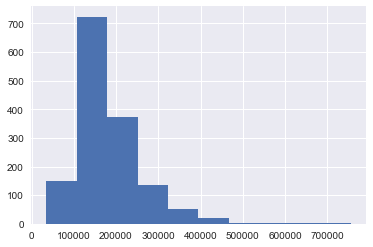

In [455]:
plt.hist(Y_train)

/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged y

The best alpha value for MLPRegressor(activation='relu', alpha=100000.0, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False) is 46.41588833612782


/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged y

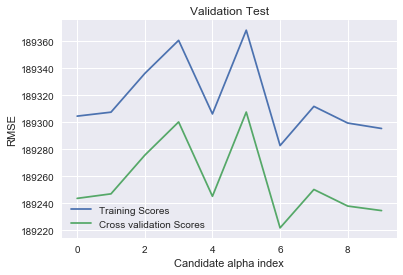

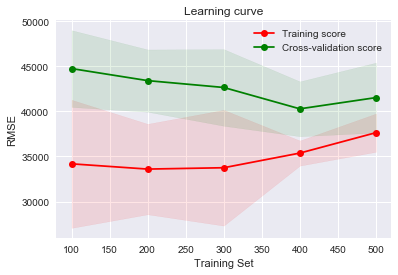

train score is 0.7825724408615851
Cross validation score is 0.7356359372179481


In [456]:
#MLP

best_alpha = valid_test(MLPRegressor(), 'alpha', np.logspace(-5, 5, 10))
MLP = MLPRegressor(alpha=best_alpha, hidden_layer_sizes=(500), random_state=1, max_iter=10000)
MLP.fit(X_train_sub, Y_train_sub)
Learning_curve(MLP)
Y_test_pred_MLP = MLP.predict(X_test)

print('train score is {}'.format(MLP.score(X_train_sub, Y_train_sub)))
print('Cross validation score is {}'.format(MLP.score(X_cv, Y_cv)))

# MLP = MLPClassifier(alpha=3.6, hidden_layer_sizes=(100, 100, 100), random_state=1, max_iter=200)
# MLP.fit(X_train, Y_train)
# Y_test_pred_MLP = MLP.predict(X_test)
# Learning_curve(MLP)
# print('train score is {}'.format(MLP.score(X_train, Y_train)))

The best max_depth value for DecisionTreeRegressor(criterion='mse', max_depth=11, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best') is 4


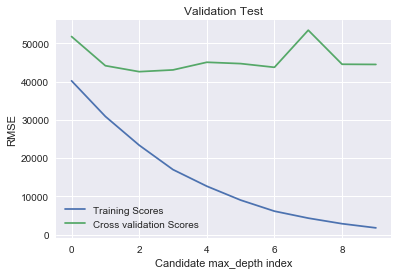

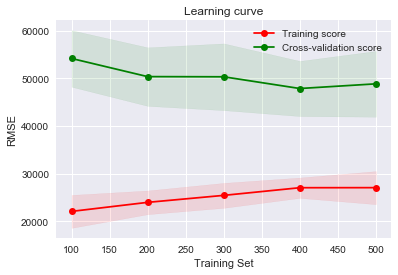

Train score is 0.817679111867066
Cross validation score is 0.7227584544054377


In [457]:
# DecisionTreeRegressor
best_max_depth = valid_test(DecisionTreeRegressor(), "max_depth", [2,3,4,5,6,7,8,9,10,11])
RF = DecisionTreeRegressor(max_depth = best_max_depth)
RF.fit(X_train_sub, Y_train_sub)
Y_test_pred_RF = RF.predict(X_test)
Learning_curve(RF)
print('Train score is {}'.format(RF.score(X_train_sub, Y_train_sub)))
print('Cross validation score is {}'.format(RF.score(X_cv, Y_cv)))


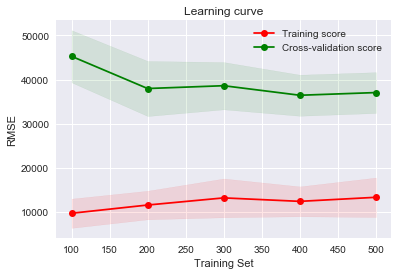

train score is 0.9669253150644412
Cross validation score is 0.9740744109694619


In [458]:
#Support Vector Machines
# best_gamma = valid_test(SVR(), "gamma", np.logspace(-3, 0, 10))
# best_C = valid_test(SVR(gamma = best_gamma), "C", np.logspace(6, 9, 10))
# svm = SVR(C = best_C, gamma = best_gamma)
# svm.fit(X_train_sub, Y_train_sub)
# Learning_curve(svm)
# Y_test_pred_svm = svm.predict(X_test)
# print('train score is {}'.format(svm.score(X_train_sub, Y_train_sub)))
# print('Cross validation score is {}'.format(svm.score(X_cv, Y_cv)))

svm = SVR(C = 2000000, gamma = 0.01)
svm.fit(X_train, Y_train)
Learning_curve(svm)
Y_test_pred_svm = svm.predict(X_test)
print('train score is {}'.format(svm.score(X_train, Y_train)))
print('Cross validation score is {}'.format(svm.score(X_cv, Y_cv)))

The best alpha value for Lasso(alpha=1000.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False) is 1000.0


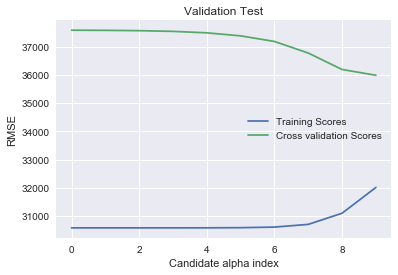

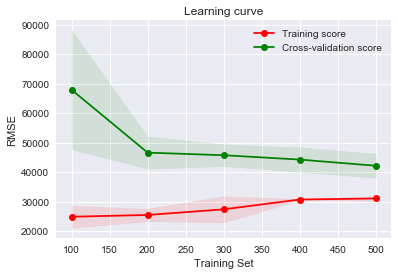

Train score is 0.8106418687997716
Cross validation score is 0.7948178868860181


In [459]:
best_alpha = valid_test(Lasso(), "alpha", np.logspace(0, 3, 10))
LS= Lasso()
Learning_curve(LS)
LS.fit(X_train, Y_train)
Y_test_pred_LS = LS.predict(X_test)
print('Train score is {}'.format(LS.score(X_train, Y_train)))
print('Cross validation score is {}'.format(LS.score(X_cv, Y_cv)))

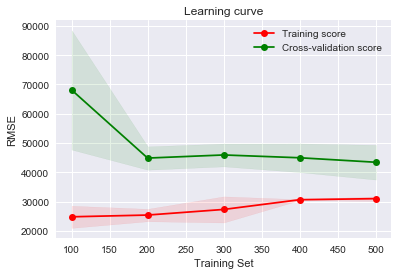

Train score is 0.810641892164933
Cross validation score is 0.794823294407174


In [460]:
LR = LinearRegression()
Learning_curve(LR)
LR.fit(X_train, Y_train)
Y_test_pred_LR = LR.predict(X_test)
print('Train score is {}'.format(LR.score(X_train, Y_train)))
print('Cross validation score is {}'.format(LR.score(X_cv, Y_cv)))

The best n_neighbors value for KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=11, p=2,
          weights='uniform') is 3


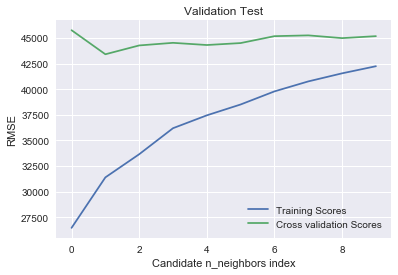

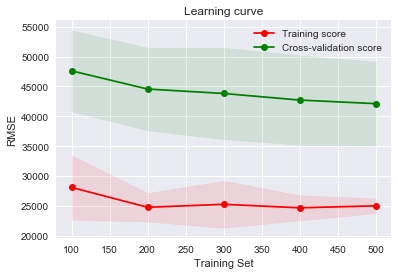

CPU times: user 2.5 ms, sys: 210 µs, total: 2.71 ms
Wall time: 2.8 ms
Train score is 0.9036946880782003
Cross validation score is 0.9005797032703265


In [461]:
best_n_neighbors = valid_test(KNeighborsRegressor(), "n_neighbors", [2,3,4,5,6,7,8,9,10,11])
nb = KNeighborsRegressor(n_neighbors = best_n_neighbors)
#nb = MultinomialNB()
Learning_curve(nb)
%time nb.fit(X_train, Y_train)
Y_test_pred_nb = nb.predict(X_test)   
print('Train score is {}'.format(nb.score(X_train, Y_train)))
print('Cross validation score is {}'.format(nb.score(X_cv, Y_cv)))

In [462]:
submission = pd.DataFrame({"Id": test_Id, "SalePrice": Y_test_pred_svm})
submission.to_csv('housing_3_cons.csv', index=False)


In [463]:
A = pd.read_csv('housing_3_cons.csv')
A.head()

Id      SalePrice
0  1461  117775.920254
1  1463  181474.414368
2  1464  182967.788107
3  1468  169246.149042
4  1476  369951.616697